In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import os
import torch.optim as optim
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)


In [2]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [3]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp4/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp4/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp4/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [4]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Training on bin 1/50
Bin 1, Epoch 1/4000, Train Loss: 0.7213, Validation Loss: 0.6938,  Accuracy: 0.2401, LR: 0.000010
Bin 1, Epoch 101/4000, Train Loss: 0.6279, Validation Loss: 0.6660,  Accuracy: 0.6384, LR: 0.000010
Bin 1, Epoch 201/4000, Train Loss: 0.5661, Validation Loss: 0.5812,  Accuracy: 0.8220, LR: 0.000010
Bin 1, Epoch 301/4000, Train Loss: 0.5032, Validation Loss: 0.5108,  Accuracy: 0.8418, LR: 0.000010
Bin 1, Epoch 401/4000, Train Loss: 0.4655, Validation Loss: 0.4194,  Accuracy: 0.8559, LR: 0.000010
Bin 1, Epoch 501/4000, Train Loss: 0.4157, Validation Loss: 0.4136,  Accuracy: 0.8559, LR: 0.000010
Bin 1, Epoch 601/4000, Train Loss: 0.3762, Validation Loss: 0.3806,  Accuracy: 0.8672, LR: 0.000010
Bin 1, Epoch 701/4000, Train Loss: 0.3773, Validation Loss: 0.3298,  Accuracy: 0.8785, LR: 0.000010
Bin 1, Epoch 801/4000, Train Loss: 0.3628, Validation Loss: 0.3495,  Accuracy: 0.8672, LR: 0.000009
Bin 1, Epoch 901/4000, Train Loss: 0.3440, Validation Loss: 0.3075,  Accuracy: 0.

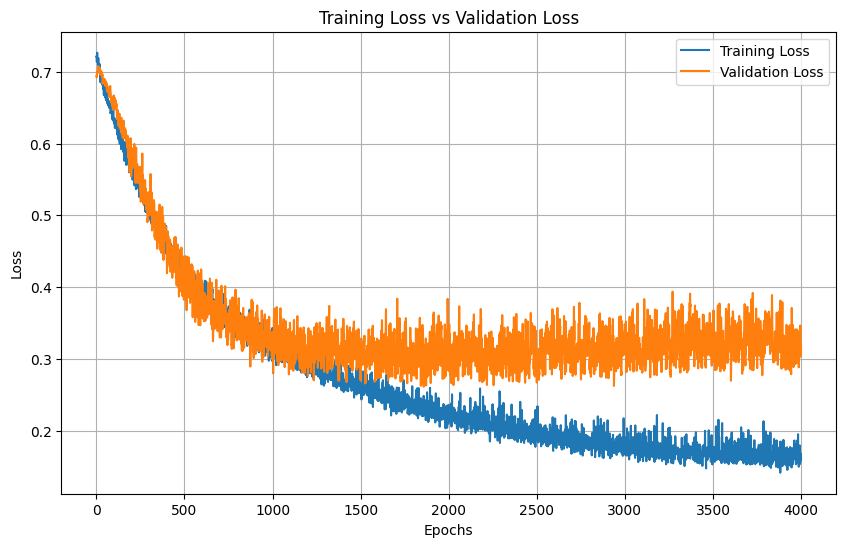

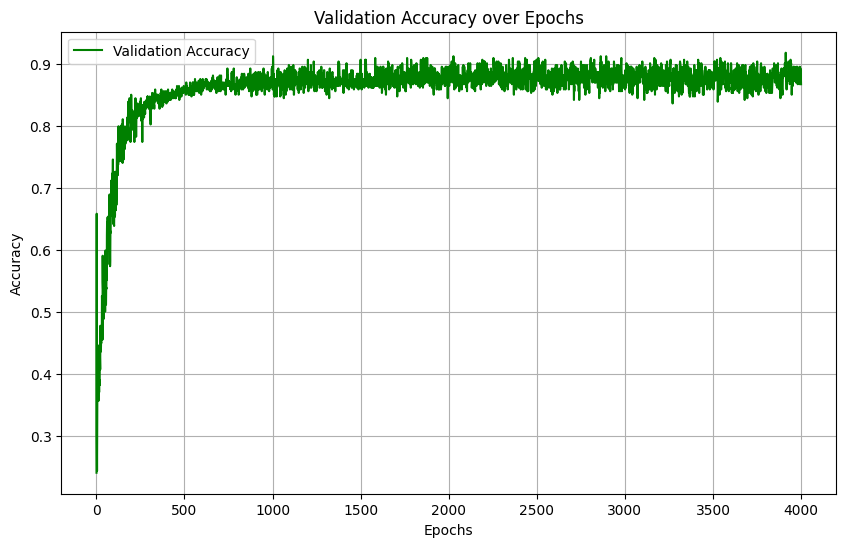

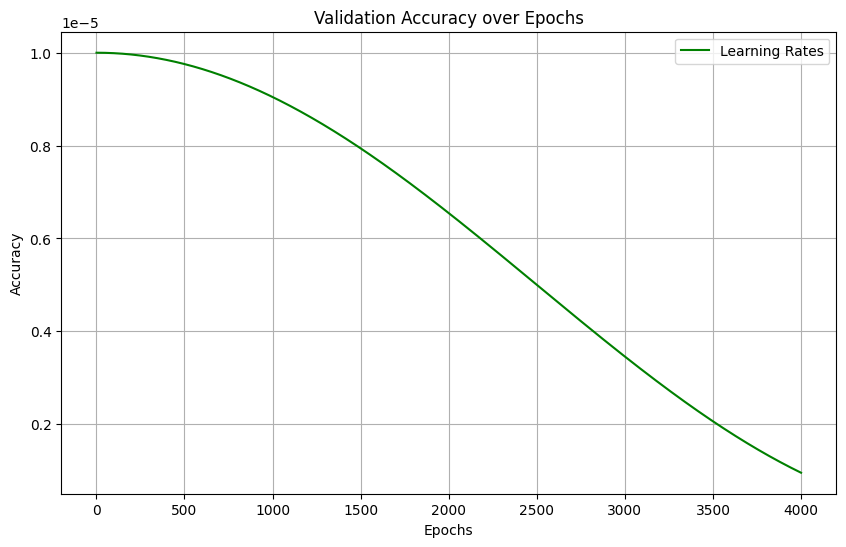

Model for bin 1 saved to GCNModels-5A_exp4/model_bin_1.pth
Training on bin 2/50
Bin 2, Epoch 1/4000, Train Loss: 0.7088, Validation Loss: 0.6949,  Accuracy: 0.2175, LR: 0.000010
Bin 2, Epoch 101/4000, Train Loss: 0.6418, Validation Loss: 0.6467,  Accuracy: 0.7175, LR: 0.000010
Bin 2, Epoch 201/4000, Train Loss: 0.5955, Validation Loss: 0.5827,  Accuracy: 0.7797, LR: 0.000010
Bin 2, Epoch 301/4000, Train Loss: 0.5276, Validation Loss: 0.5020,  Accuracy: 0.8333, LR: 0.000010
Bin 2, Epoch 401/4000, Train Loss: 0.4891, Validation Loss: 0.4517,  Accuracy: 0.8418, LR: 0.000010
Bin 2, Epoch 501/4000, Train Loss: 0.4397, Validation Loss: 0.4004,  Accuracy: 0.8729, LR: 0.000010
Bin 2, Epoch 601/4000, Train Loss: 0.4285, Validation Loss: 0.3879,  Accuracy: 0.8616, LR: 0.000010
Bin 2, Epoch 701/4000, Train Loss: 0.4014, Validation Loss: 0.3523,  Accuracy: 0.8701, LR: 0.000010
Bin 2, Epoch 801/4000, Train Loss: 0.3835, Validation Loss: 0.3678,  Accuracy: 0.8616, LR: 0.000009
Bin 2, Epoch 901/4000,

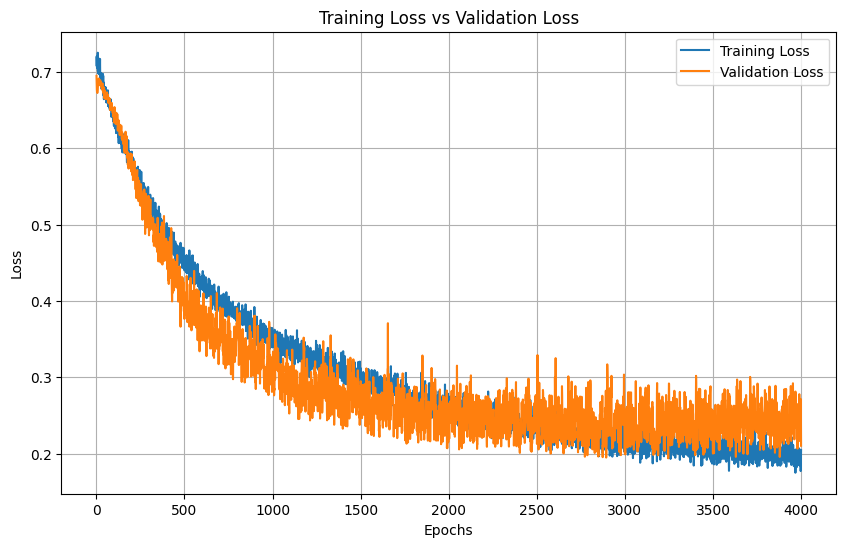

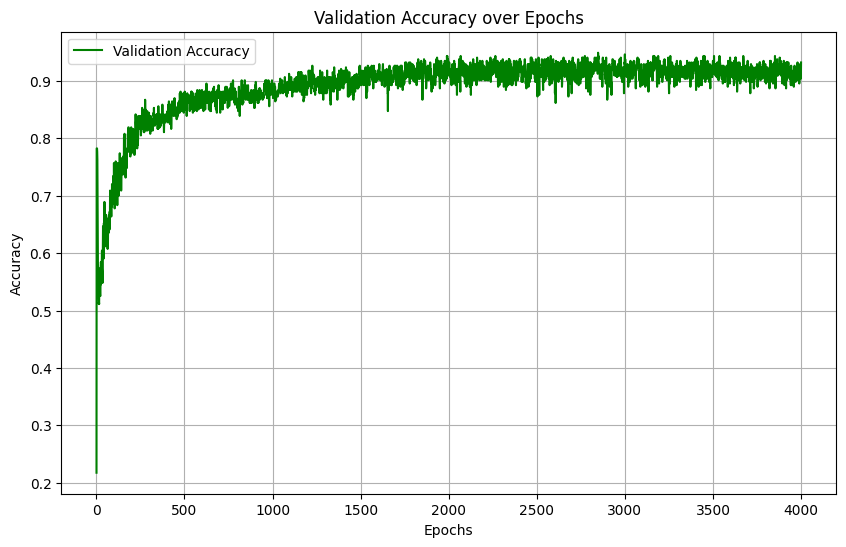

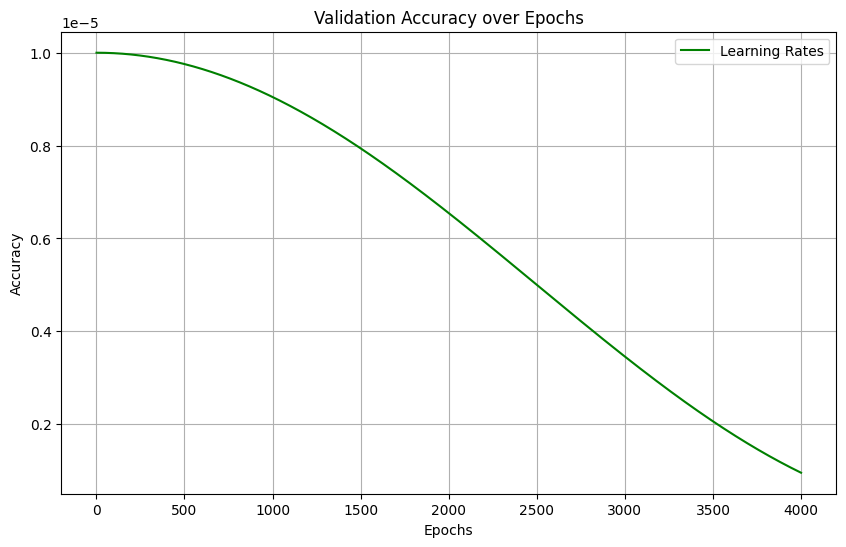

Model for bin 2 saved to GCNModels-5A_exp4/model_bin_2.pth
Training on bin 3/50
Bin 3, Epoch 1/4000, Train Loss: 0.6875, Validation Loss: 0.6791,  Accuracy: 0.7825, LR: 0.000010
Bin 3, Epoch 101/4000, Train Loss: 0.6096, Validation Loss: 0.6019,  Accuracy: 0.8136, LR: 0.000010
Bin 3, Epoch 201/4000, Train Loss: 0.5540, Validation Loss: 0.5556,  Accuracy: 0.8277, LR: 0.000010
Bin 3, Epoch 301/4000, Train Loss: 0.4992, Validation Loss: 0.4703,  Accuracy: 0.8757, LR: 0.000010
Bin 3, Epoch 401/4000, Train Loss: 0.4589, Validation Loss: 0.4369,  Accuracy: 0.8644, LR: 0.000010
Bin 3, Epoch 501/4000, Train Loss: 0.4272, Validation Loss: 0.4137,  Accuracy: 0.8616, LR: 0.000010
Bin 3, Epoch 601/4000, Train Loss: 0.4102, Validation Loss: 0.3701,  Accuracy: 0.8842, LR: 0.000010
Bin 3, Epoch 701/4000, Train Loss: 0.4065, Validation Loss: 0.3707,  Accuracy: 0.8785, LR: 0.000010
Bin 3, Epoch 801/4000, Train Loss: 0.3915, Validation Loss: 0.3380,  Accuracy: 0.8814, LR: 0.000009
Bin 3, Epoch 901/4000,

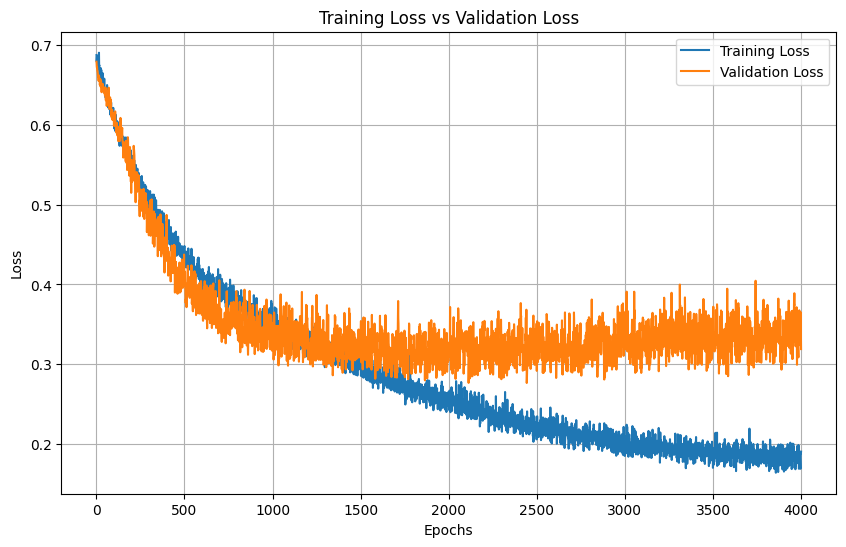

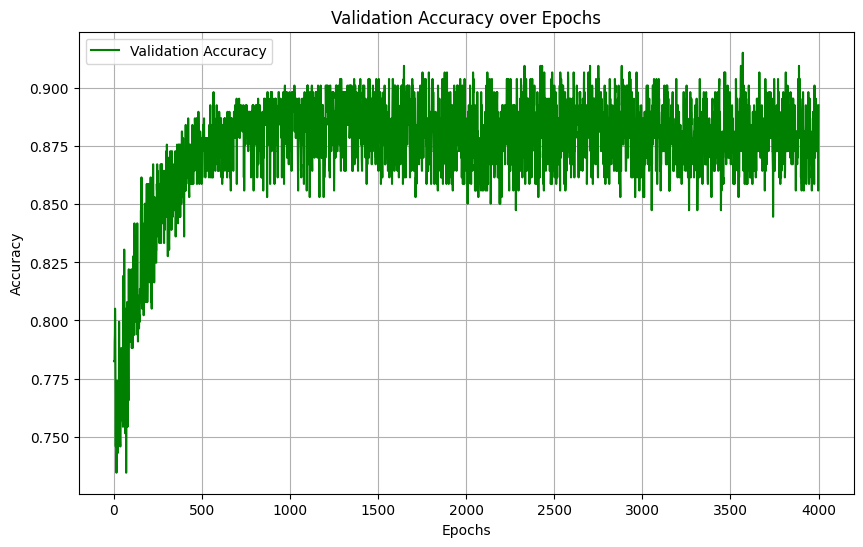

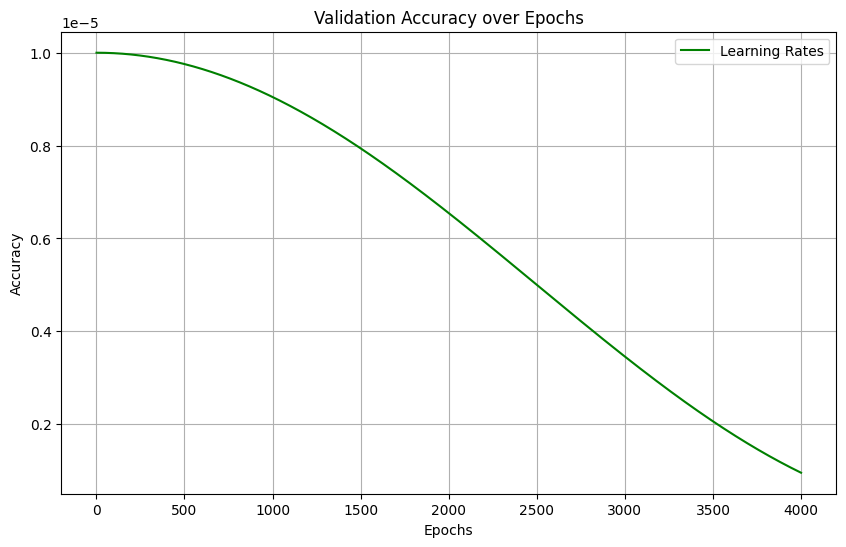

Model for bin 3 saved to GCNModels-5A_exp4/model_bin_3.pth
Training on bin 4/50
Bin 4, Epoch 1/4000, Train Loss: 0.6861, Validation Loss: 0.7070,  Accuracy: 0.2175, LR: 0.000010
Bin 4, Epoch 101/4000, Train Loss: 0.6183, Validation Loss: 0.6328,  Accuracy: 0.7825, LR: 0.000010
Bin 4, Epoch 201/4000, Train Loss: 0.5778, Validation Loss: 0.5685,  Accuracy: 0.8107, LR: 0.000010
Bin 4, Epoch 301/4000, Train Loss: 0.5250, Validation Loss: 0.5382,  Accuracy: 0.8305, LR: 0.000010
Bin 4, Epoch 401/4000, Train Loss: 0.4784, Validation Loss: 0.4492,  Accuracy: 0.8588, LR: 0.000010
Bin 4, Epoch 501/4000, Train Loss: 0.4393, Validation Loss: 0.4285,  Accuracy: 0.8616, LR: 0.000010
Bin 4, Epoch 601/4000, Train Loss: 0.4313, Validation Loss: 0.3816,  Accuracy: 0.8814, LR: 0.000010
Bin 4, Epoch 701/4000, Train Loss: 0.3843, Validation Loss: 0.3982,  Accuracy: 0.8588, LR: 0.000010
Bin 4, Epoch 801/4000, Train Loss: 0.3683, Validation Loss: 0.3543,  Accuracy: 0.8870, LR: 0.000009
Bin 4, Epoch 901/4000,

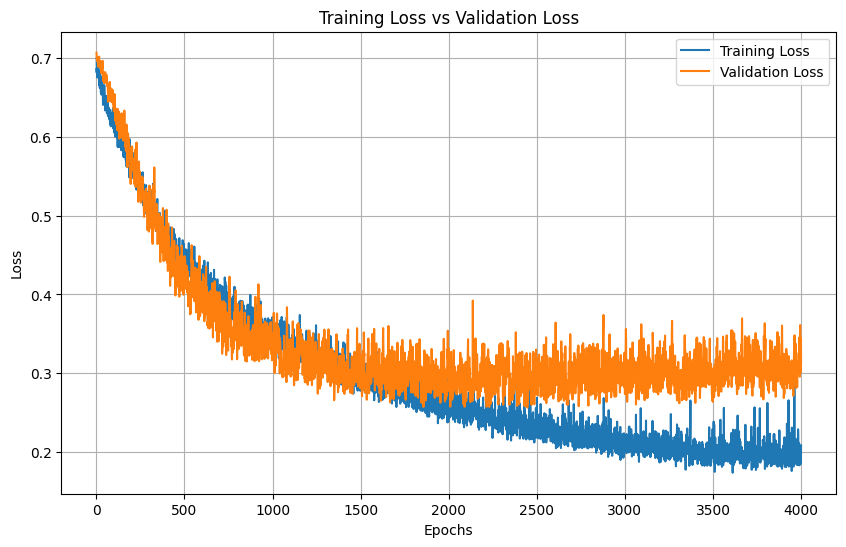

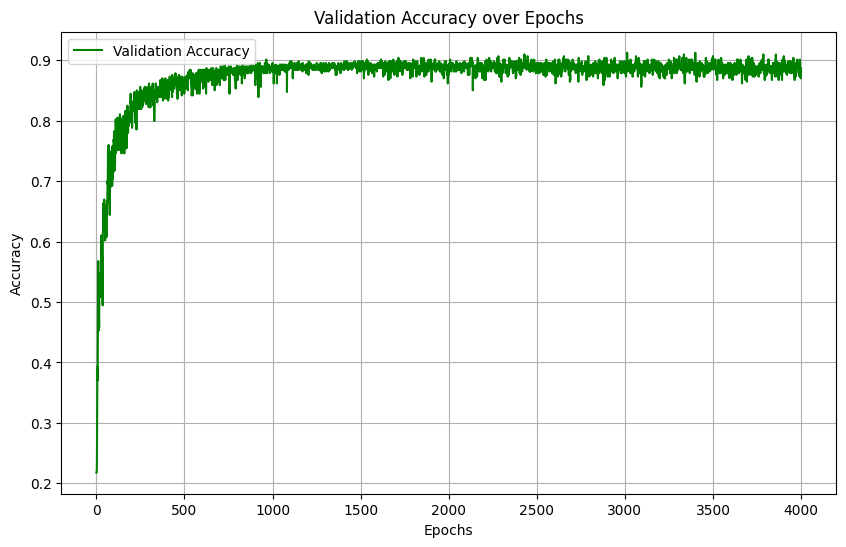

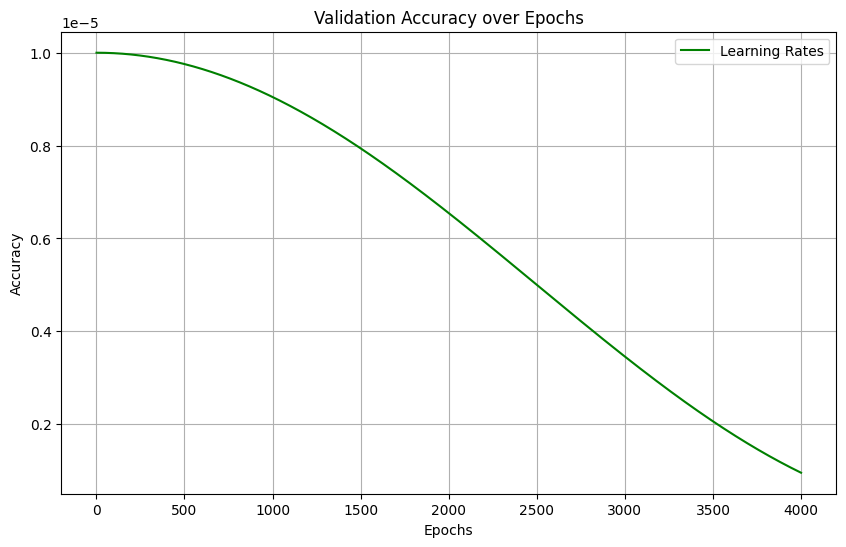

Model for bin 4 saved to GCNModels-5A_exp4/model_bin_4.pth
Training on bin 5/50
Bin 5, Epoch 1/4000, Train Loss: 0.7466, Validation Loss: 0.6550,  Accuracy: 0.7825, LR: 0.000010
Bin 5, Epoch 101/4000, Train Loss: 0.6097, Validation Loss: 0.6062,  Accuracy: 0.8220, LR: 0.000010
Bin 5, Epoch 201/4000, Train Loss: 0.5385, Validation Loss: 0.5444,  Accuracy: 0.8588, LR: 0.000010
Bin 5, Epoch 301/4000, Train Loss: 0.4905, Validation Loss: 0.4926,  Accuracy: 0.8531, LR: 0.000010
Bin 5, Epoch 401/4000, Train Loss: 0.4481, Validation Loss: 0.4586,  Accuracy: 0.8531, LR: 0.000010
Bin 5, Epoch 501/4000, Train Loss: 0.4388, Validation Loss: 0.4071,  Accuracy: 0.8644, LR: 0.000010
Bin 5, Epoch 601/4000, Train Loss: 0.4166, Validation Loss: 0.4373,  Accuracy: 0.8503, LR: 0.000010
Bin 5, Epoch 701/4000, Train Loss: 0.3904, Validation Loss: 0.3713,  Accuracy: 0.8616, LR: 0.000010
Bin 5, Epoch 801/4000, Train Loss: 0.3678, Validation Loss: 0.3368,  Accuracy: 0.8842, LR: 0.000009
Bin 5, Epoch 901/4000,

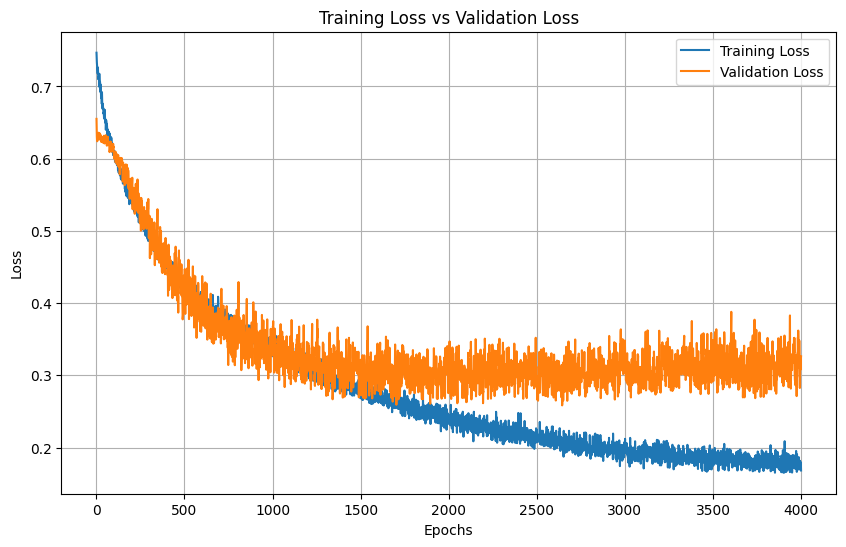

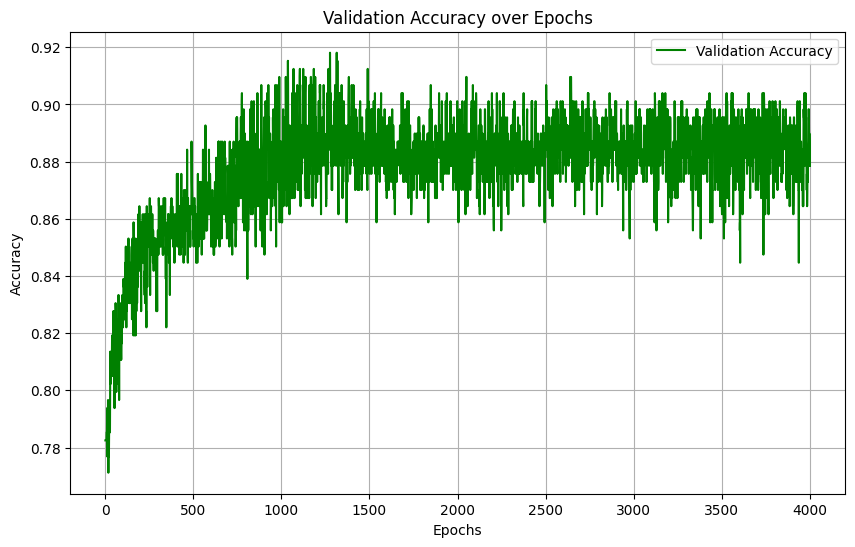

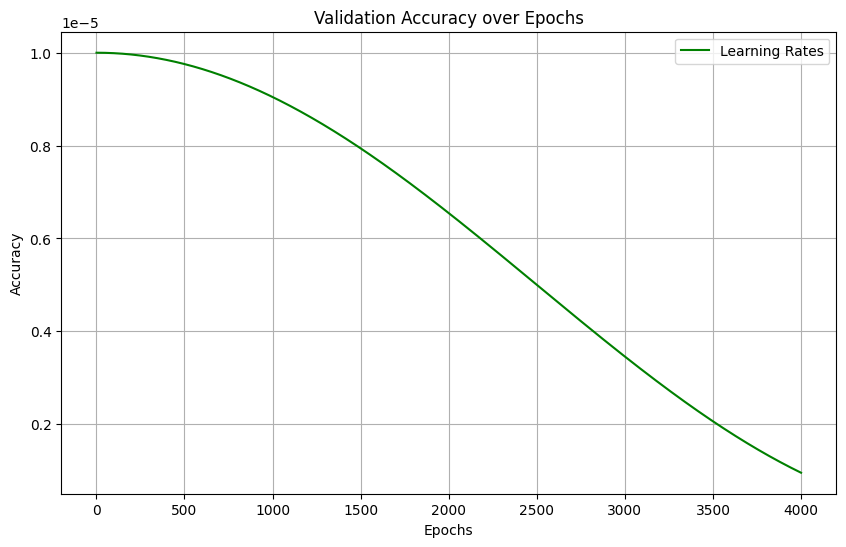

Model for bin 5 saved to GCNModels-5A_exp4/model_bin_5.pth
Training on bin 6/50
Bin 6, Epoch 1/4000, Train Loss: 0.7231, Validation Loss: 0.7213,  Accuracy: 0.2175, LR: 0.000010
Bin 6, Epoch 101/4000, Train Loss: 0.6418, Validation Loss: 0.6781,  Accuracy: 0.6299, LR: 0.000010
Bin 6, Epoch 201/4000, Train Loss: 0.5910, Validation Loss: 0.5948,  Accuracy: 0.7740, LR: 0.000010
Bin 6, Epoch 301/4000, Train Loss: 0.5497, Validation Loss: 0.5219,  Accuracy: 0.8220, LR: 0.000010
Bin 6, Epoch 401/4000, Train Loss: 0.5014, Validation Loss: 0.4596,  Accuracy: 0.8362, LR: 0.000010
Bin 6, Epoch 501/4000, Train Loss: 0.4697, Validation Loss: 0.4546,  Accuracy: 0.8192, LR: 0.000010
Bin 6, Epoch 601/4000, Train Loss: 0.4473, Validation Loss: 0.3976,  Accuracy: 0.8446, LR: 0.000010
Bin 6, Epoch 701/4000, Train Loss: 0.4278, Validation Loss: 0.3628,  Accuracy: 0.8588, LR: 0.000010
Bin 6, Epoch 801/4000, Train Loss: 0.4020, Validation Loss: 0.3273,  Accuracy: 0.8757, LR: 0.000009
Bin 6, Epoch 901/4000,

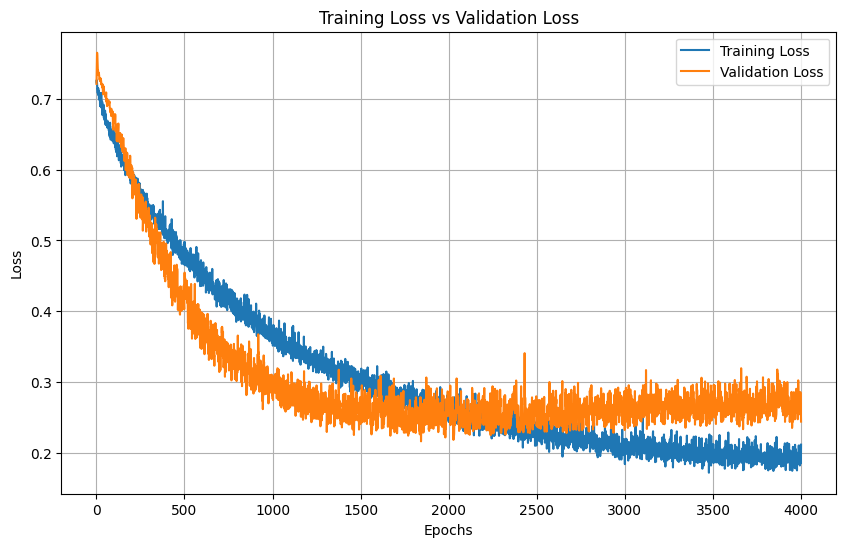

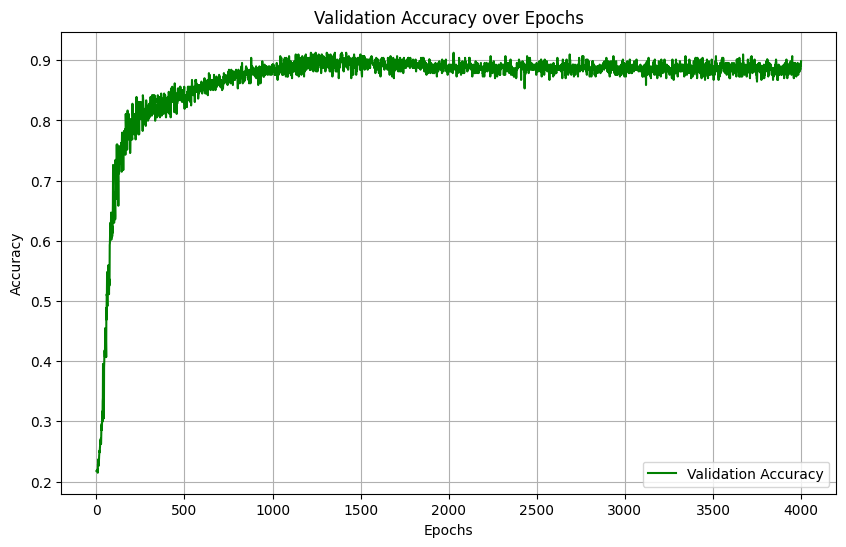

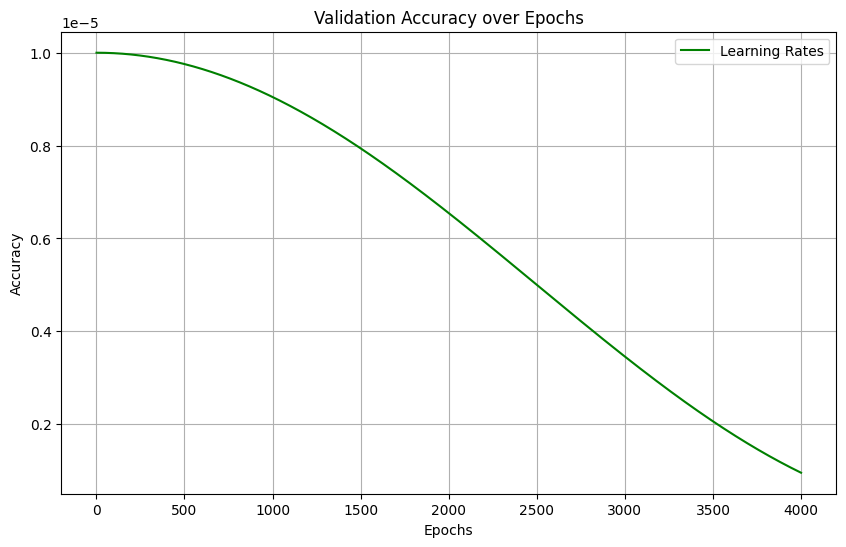

Model for bin 6 saved to GCNModels-5A_exp4/model_bin_6.pth
Training on bin 7/50
Bin 7, Epoch 1/4000, Train Loss: 0.6801, Validation Loss: 0.7207,  Accuracy: 0.2175, LR: 0.000010
Bin 7, Epoch 101/4000, Train Loss: 0.6176, Validation Loss: 0.6700,  Accuracy: 0.6949, LR: 0.000010
Bin 7, Epoch 201/4000, Train Loss: 0.5762, Validation Loss: 0.5866,  Accuracy: 0.8164, LR: 0.000010
Bin 7, Epoch 301/4000, Train Loss: 0.5285, Validation Loss: 0.5002,  Accuracy: 0.8503, LR: 0.000010
Bin 7, Epoch 401/4000, Train Loss: 0.4736, Validation Loss: 0.4376,  Accuracy: 0.8644, LR: 0.000010
Bin 7, Epoch 501/4000, Train Loss: 0.4482, Validation Loss: 0.4321,  Accuracy: 0.8531, LR: 0.000010
Bin 7, Epoch 601/4000, Train Loss: 0.4337, Validation Loss: 0.3758,  Accuracy: 0.8757, LR: 0.000010
Bin 7, Epoch 701/4000, Train Loss: 0.4109, Validation Loss: 0.3556,  Accuracy: 0.8757, LR: 0.000010
Bin 7, Epoch 801/4000, Train Loss: 0.3958, Validation Loss: 0.3650,  Accuracy: 0.8672, LR: 0.000009
Bin 7, Epoch 901/4000,

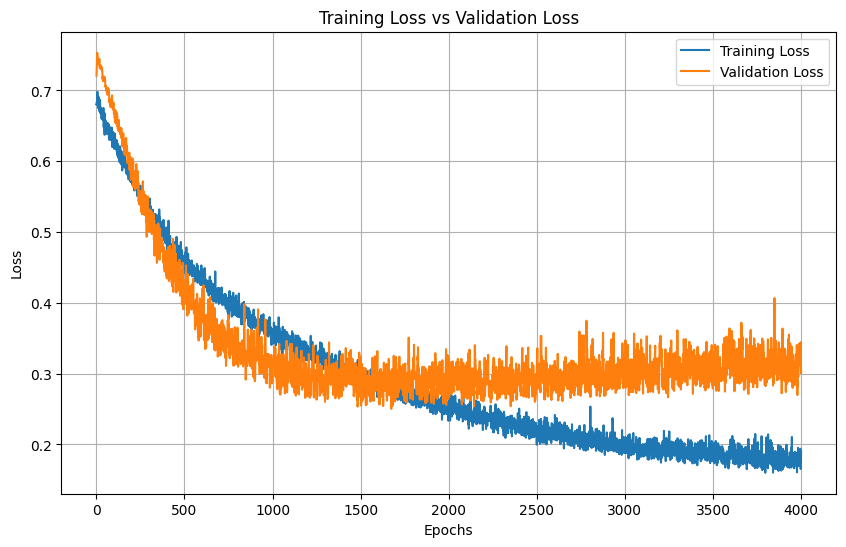

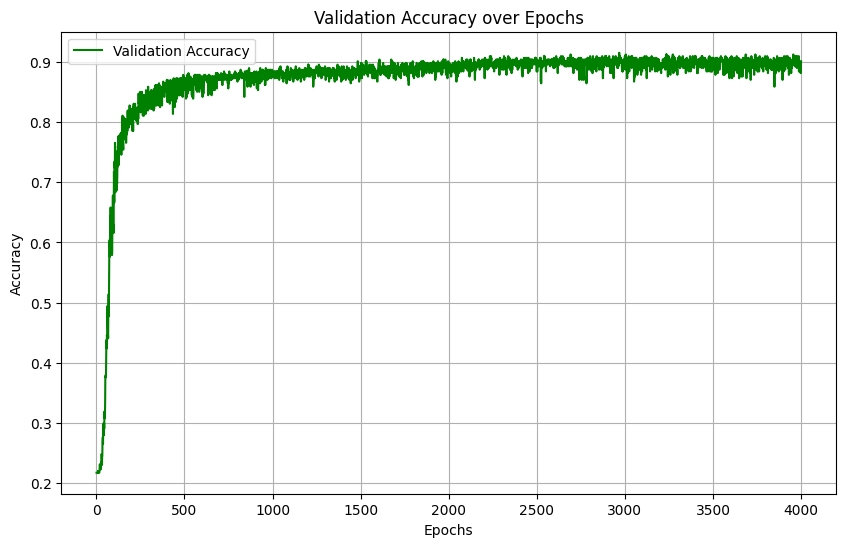

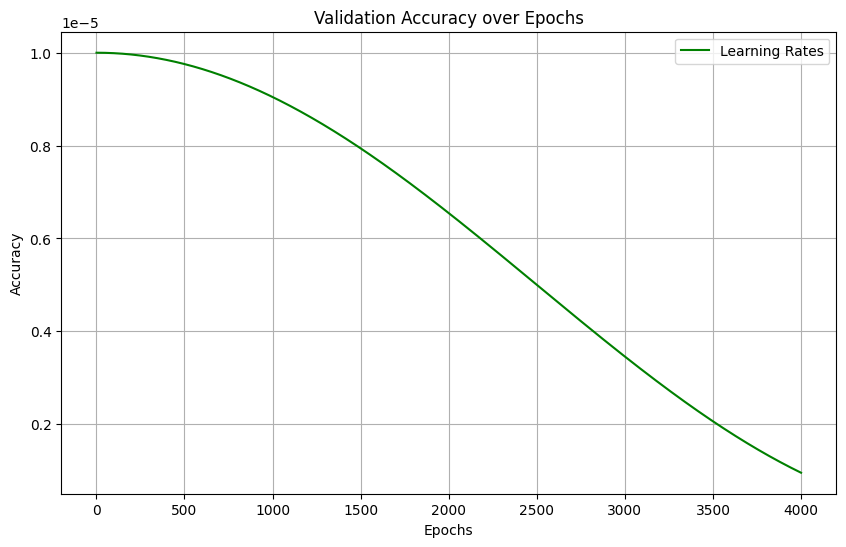

Model for bin 7 saved to GCNModels-5A_exp4/model_bin_7.pth
Training on bin 8/50
Bin 8, Epoch 1/4000, Train Loss: 0.7274, Validation Loss: 0.6513,  Accuracy: 0.7825, LR: 0.000010
Bin 8, Epoch 101/4000, Train Loss: 0.6332, Validation Loss: 0.5798,  Accuracy: 0.8333, LR: 0.000010
Bin 8, Epoch 201/4000, Train Loss: 0.5745, Validation Loss: 0.5120,  Accuracy: 0.8672, LR: 0.000010
Bin 8, Epoch 301/4000, Train Loss: 0.5296, Validation Loss: 0.4557,  Accuracy: 0.8616, LR: 0.000010
Bin 8, Epoch 401/4000, Train Loss: 0.5033, Validation Loss: 0.4397,  Accuracy: 0.8446, LR: 0.000010
Bin 8, Epoch 501/4000, Train Loss: 0.4707, Validation Loss: 0.3879,  Accuracy: 0.8559, LR: 0.000010
Bin 8, Epoch 601/4000, Train Loss: 0.4346, Validation Loss: 0.3527,  Accuracy: 0.8588, LR: 0.000010
Bin 8, Epoch 701/4000, Train Loss: 0.4239, Validation Loss: 0.3360,  Accuracy: 0.8616, LR: 0.000010
Bin 8, Epoch 801/4000, Train Loss: 0.4071, Validation Loss: 0.3028,  Accuracy: 0.8701, LR: 0.000009
Bin 8, Epoch 901/4000,

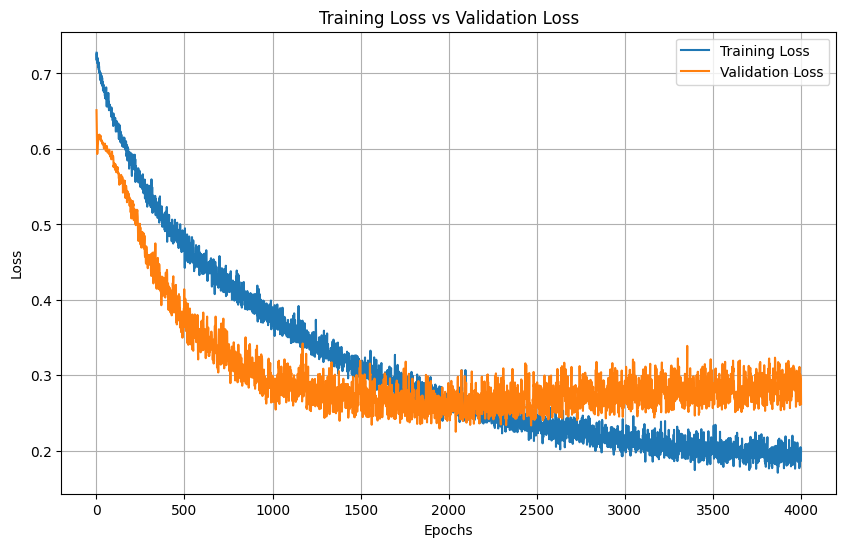

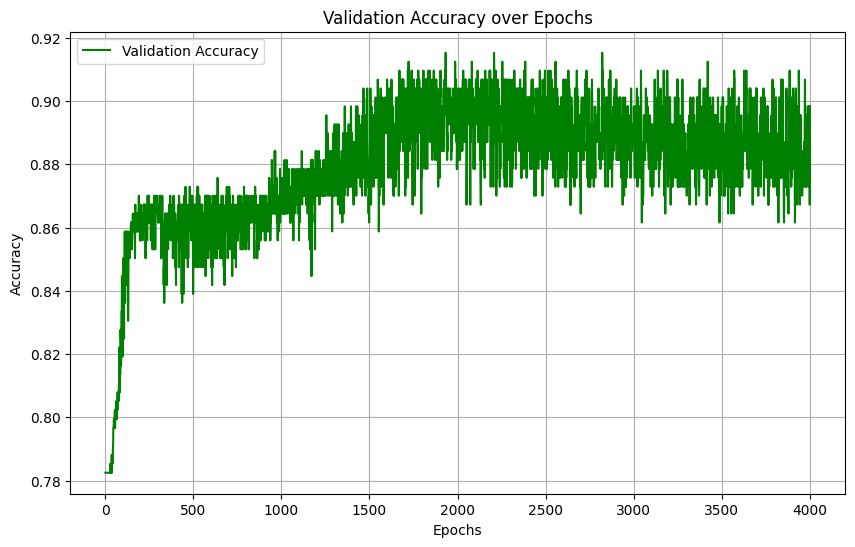

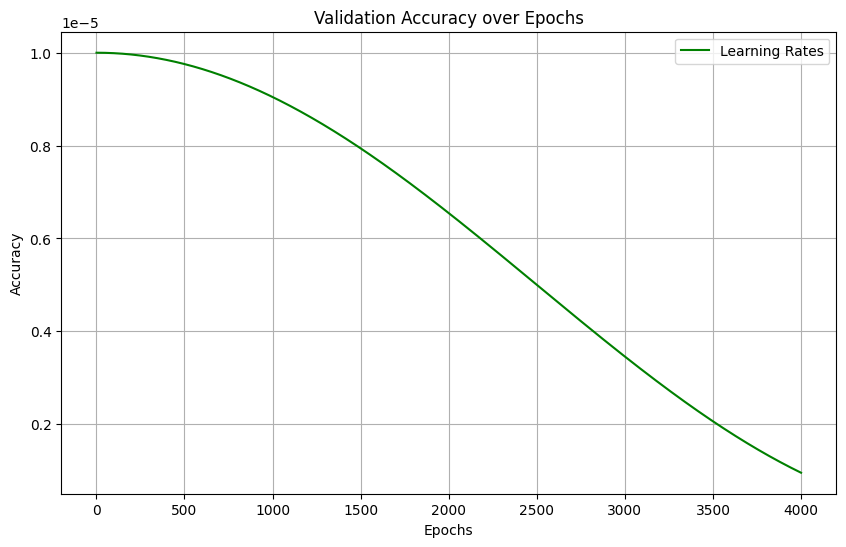

Model for bin 8 saved to GCNModels-5A_exp4/model_bin_8.pth
Training on bin 9/50
Bin 9, Epoch 1/4000, Train Loss: 0.6923, Validation Loss: 0.7175,  Accuracy: 0.2175, LR: 0.000010
Bin 9, Epoch 101/4000, Train Loss: 0.6146, Validation Loss: 0.5932,  Accuracy: 0.8051, LR: 0.000010
Bin 9, Epoch 201/4000, Train Loss: 0.5715, Validation Loss: 0.5251,  Accuracy: 0.8362, LR: 0.000010
Bin 9, Epoch 301/4000, Train Loss: 0.5240, Validation Loss: 0.4700,  Accuracy: 0.8588, LR: 0.000010
Bin 9, Epoch 401/4000, Train Loss: 0.4763, Validation Loss: 0.4306,  Accuracy: 0.8559, LR: 0.000010
Bin 9, Epoch 501/4000, Train Loss: 0.4426, Validation Loss: 0.3722,  Accuracy: 0.8672, LR: 0.000010
Bin 9, Epoch 601/4000, Train Loss: 0.4269, Validation Loss: 0.3593,  Accuracy: 0.8588, LR: 0.000010
Bin 9, Epoch 701/4000, Train Loss: 0.4039, Validation Loss: 0.3579,  Accuracy: 0.8559, LR: 0.000010
Bin 9, Epoch 801/4000, Train Loss: 0.3990, Validation Loss: 0.3122,  Accuracy: 0.8757, LR: 0.000009
Bin 9, Epoch 901/4000,

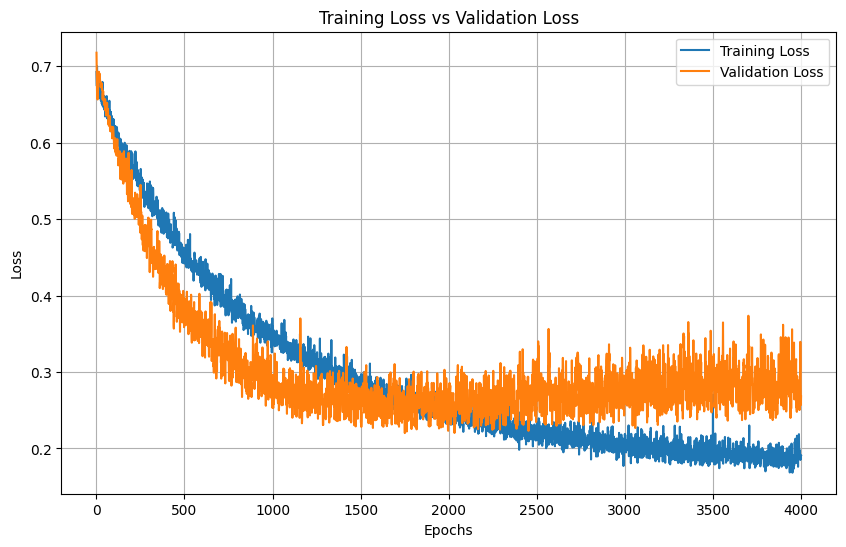

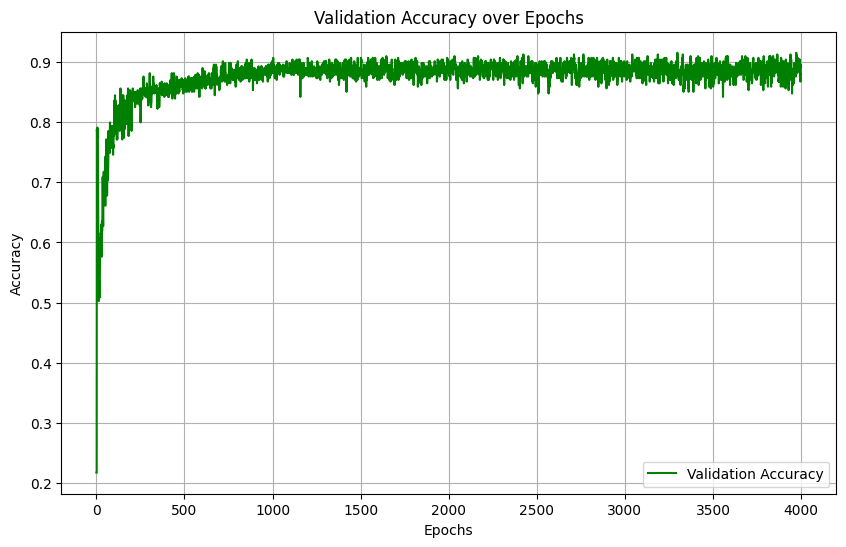

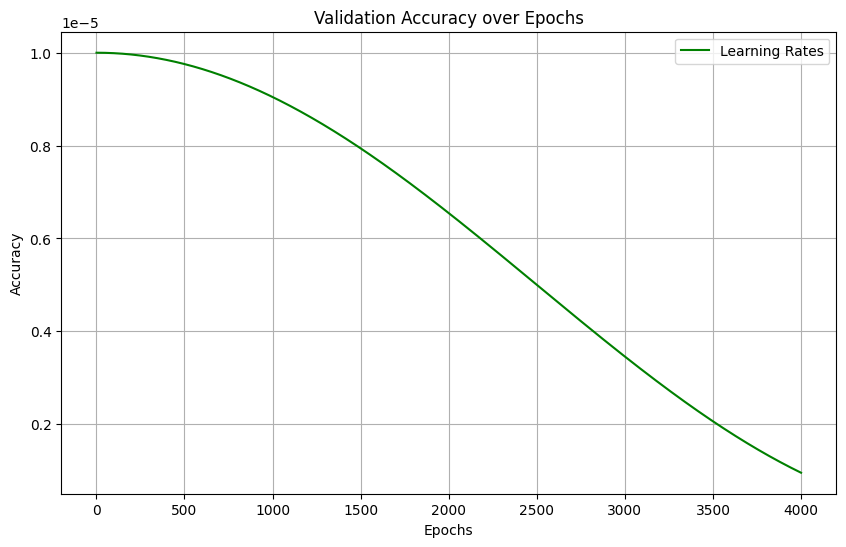

Model for bin 9 saved to GCNModels-5A_exp4/model_bin_9.pth
Training on bin 10/50
Bin 10, Epoch 1/4000, Train Loss: 0.7031, Validation Loss: 0.7202,  Accuracy: 0.2175, LR: 0.000010
Bin 10, Epoch 101/4000, Train Loss: 0.6390, Validation Loss: 0.6376,  Accuracy: 0.7458, LR: 0.000010
Bin 10, Epoch 201/4000, Train Loss: 0.5987, Validation Loss: 0.5943,  Accuracy: 0.7966, LR: 0.000010
Bin 10, Epoch 301/4000, Train Loss: 0.5474, Validation Loss: 0.5177,  Accuracy: 0.8390, LR: 0.000010
Bin 10, Epoch 401/4000, Train Loss: 0.5061, Validation Loss: 0.4889,  Accuracy: 0.8390, LR: 0.000010
Bin 10, Epoch 501/4000, Train Loss: 0.4682, Validation Loss: 0.3987,  Accuracy: 0.8559, LR: 0.000010
Bin 10, Epoch 601/4000, Train Loss: 0.4465, Validation Loss: 0.3900,  Accuracy: 0.8588, LR: 0.000010
Bin 10, Epoch 701/4000, Train Loss: 0.4043, Validation Loss: 0.3989,  Accuracy: 0.8559, LR: 0.000010
Bin 10, Epoch 801/4000, Train Loss: 0.4041, Validation Loss: 0.3709,  Accuracy: 0.8644, LR: 0.000009
Bin 10, Epoc

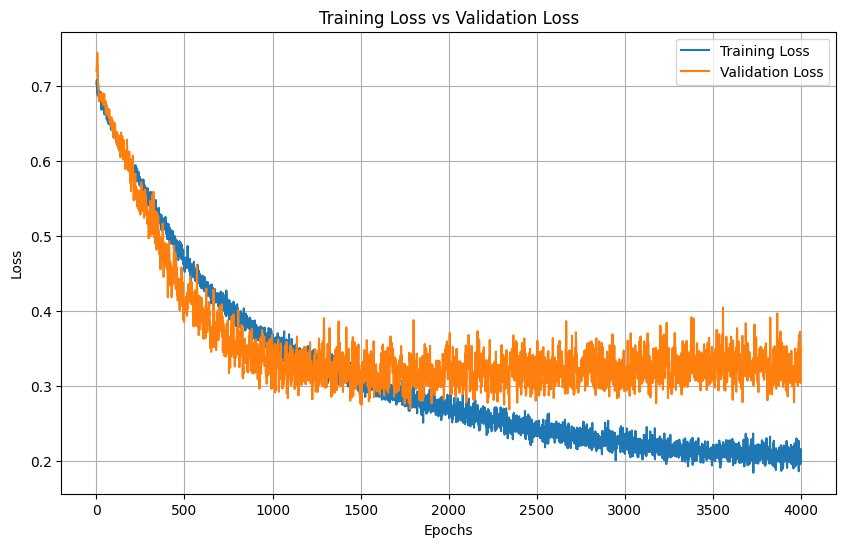

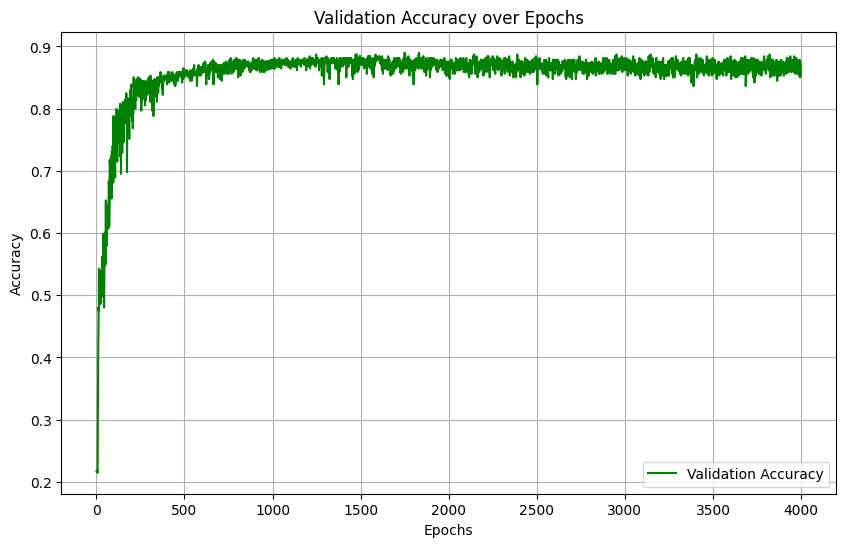

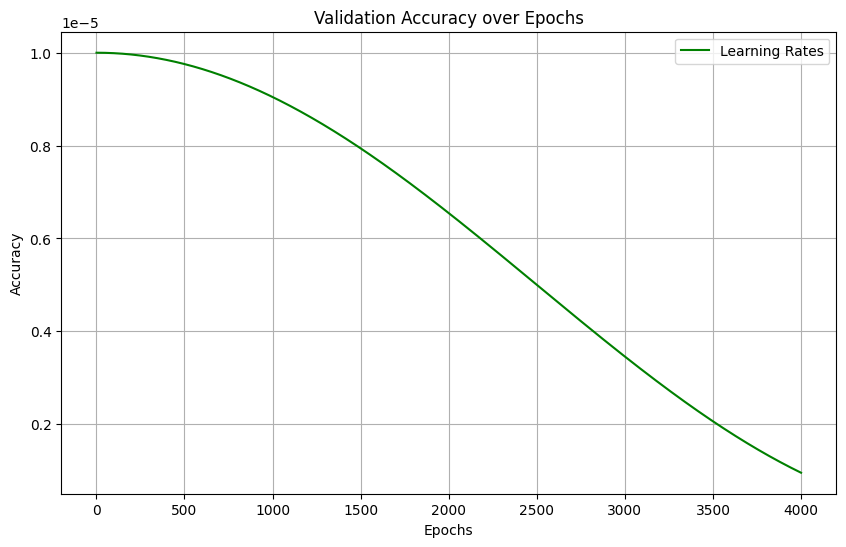

Model for bin 10 saved to GCNModels-5A_exp4/model_bin_10.pth
Training on bin 11/50
Bin 11, Epoch 1/4000, Train Loss: 0.6961, Validation Loss: 0.6757,  Accuracy: 0.7825, LR: 0.000010
Bin 11, Epoch 101/4000, Train Loss: 0.6044, Validation Loss: 0.5914,  Accuracy: 0.8531, LR: 0.000010
Bin 11, Epoch 201/4000, Train Loss: 0.5498, Validation Loss: 0.5133,  Accuracy: 0.8559, LR: 0.000010
Bin 11, Epoch 301/4000, Train Loss: 0.5151, Validation Loss: 0.4627,  Accuracy: 0.8446, LR: 0.000010
Bin 11, Epoch 401/4000, Train Loss: 0.4719, Validation Loss: 0.4326,  Accuracy: 0.8475, LR: 0.000010
Bin 11, Epoch 501/4000, Train Loss: 0.4514, Validation Loss: 0.3786,  Accuracy: 0.8503, LR: 0.000010
Bin 11, Epoch 601/4000, Train Loss: 0.4379, Validation Loss: 0.3289,  Accuracy: 0.8701, LR: 0.000010
Bin 11, Epoch 701/4000, Train Loss: 0.4057, Validation Loss: 0.3581,  Accuracy: 0.8418, LR: 0.000010
Bin 11, Epoch 801/4000, Train Loss: 0.3849, Validation Loss: 0.3171,  Accuracy: 0.8785, LR: 0.000009
Bin 11, Ep

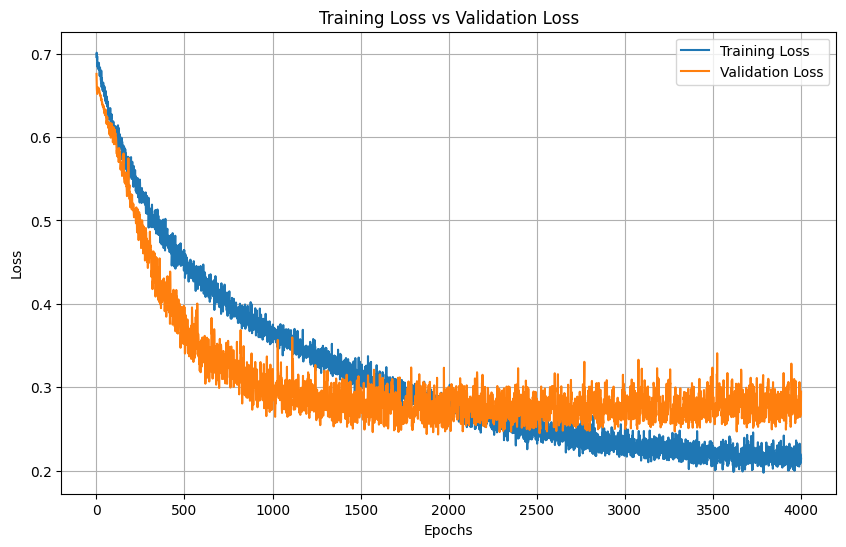

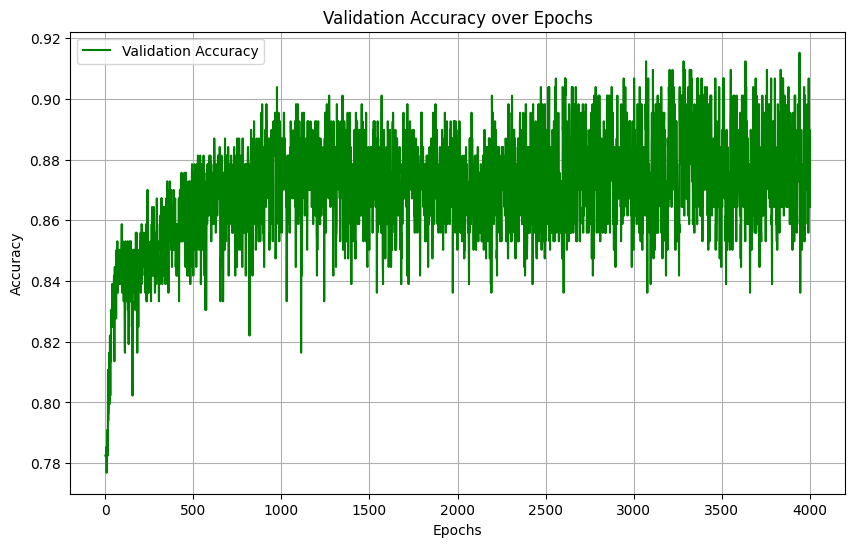

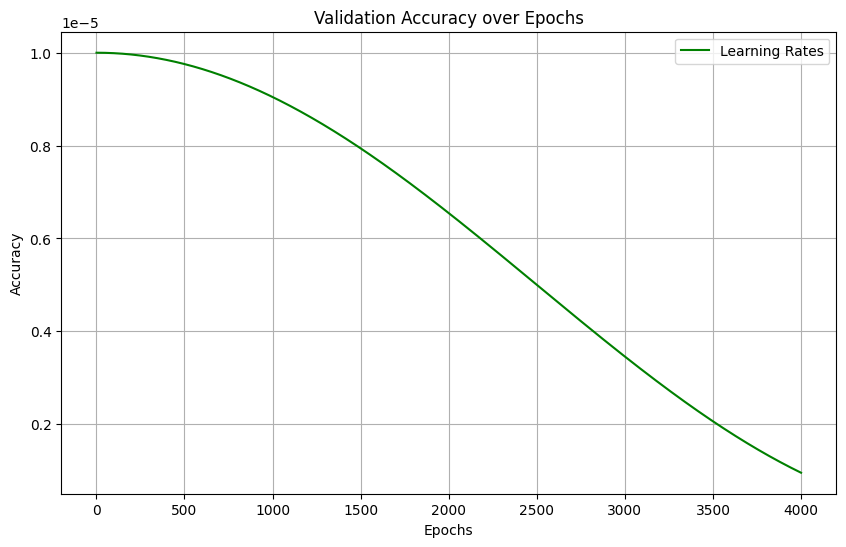

Model for bin 11 saved to GCNModels-5A_exp4/model_bin_11.pth
Training on bin 12/50
Bin 12, Epoch 1/4000, Train Loss: 0.7130, Validation Loss: 0.6986,  Accuracy: 0.2175, LR: 0.000010
Bin 12, Epoch 101/4000, Train Loss: 0.6394, Validation Loss: 0.6644,  Accuracy: 0.6497, LR: 0.000010
Bin 12, Epoch 201/4000, Train Loss: 0.5788, Validation Loss: 0.5900,  Accuracy: 0.8023, LR: 0.000010
Bin 12, Epoch 301/4000, Train Loss: 0.5230, Validation Loss: 0.5200,  Accuracy: 0.8305, LR: 0.000010
Bin 12, Epoch 401/4000, Train Loss: 0.4967, Validation Loss: 0.4601,  Accuracy: 0.8588, LR: 0.000010
Bin 12, Epoch 501/4000, Train Loss: 0.4362, Validation Loss: 0.4396,  Accuracy: 0.8588, LR: 0.000010
Bin 12, Epoch 601/4000, Train Loss: 0.3989, Validation Loss: 0.4073,  Accuracy: 0.8531, LR: 0.000010
Bin 12, Epoch 701/4000, Train Loss: 0.3738, Validation Loss: 0.3525,  Accuracy: 0.8870, LR: 0.000010
Bin 12, Epoch 801/4000, Train Loss: 0.3458, Validation Loss: 0.3361,  Accuracy: 0.8842, LR: 0.000009
Bin 12, Ep

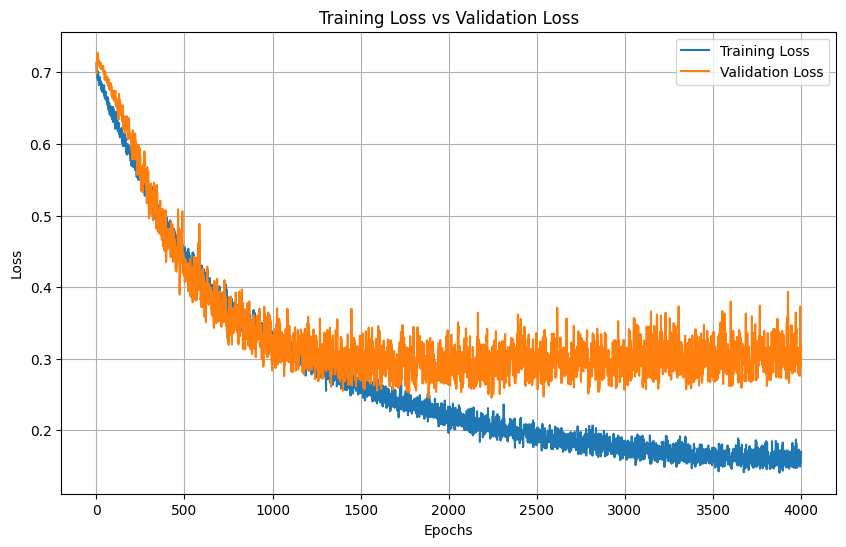

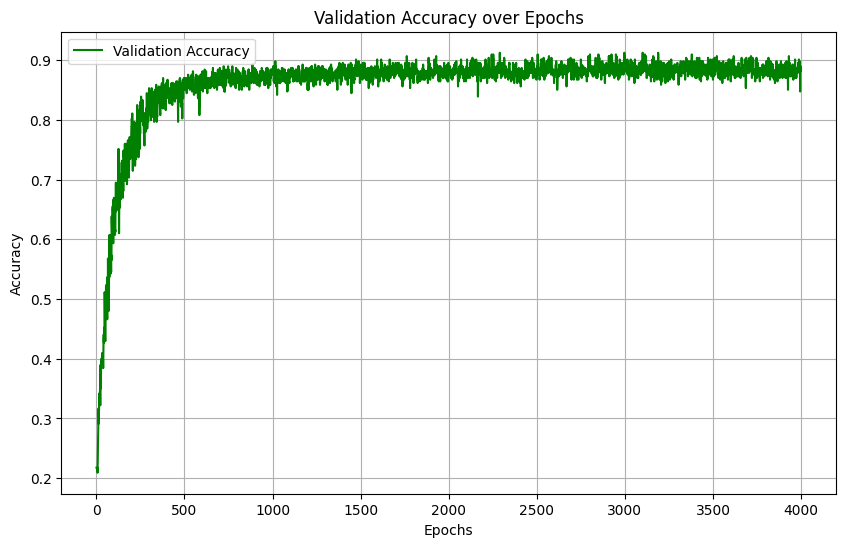

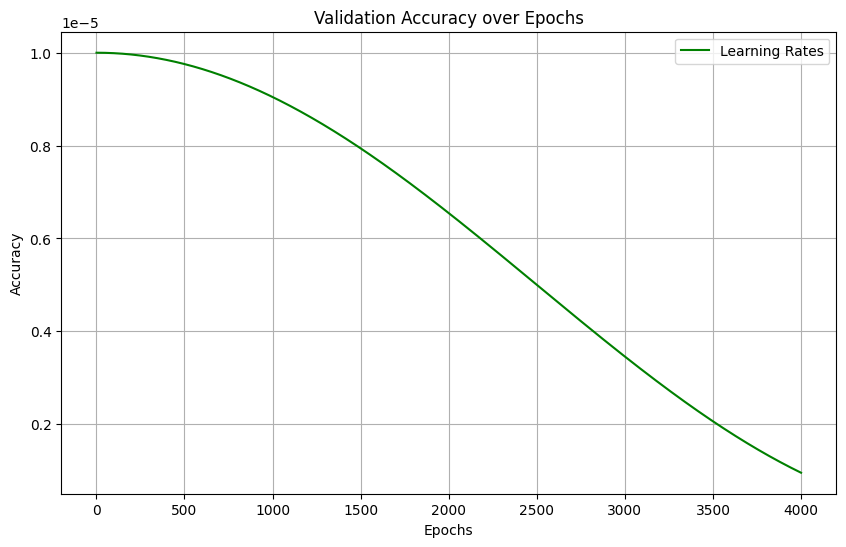

Model for bin 12 saved to GCNModels-5A_exp4/model_bin_12.pth
Training on bin 13/50
Bin 13, Epoch 1/4000, Train Loss: 0.6807, Validation Loss: 0.6791,  Accuracy: 0.7825, LR: 0.000010
Bin 13, Epoch 101/4000, Train Loss: 0.5980, Validation Loss: 0.5980,  Accuracy: 0.8079, LR: 0.000010
Bin 13, Epoch 201/4000, Train Loss: 0.5331, Validation Loss: 0.5324,  Accuracy: 0.8136, LR: 0.000010
Bin 13, Epoch 301/4000, Train Loss: 0.4758, Validation Loss: 0.5435,  Accuracy: 0.8079, LR: 0.000010
Bin 13, Epoch 401/4000, Train Loss: 0.4341, Validation Loss: 0.4842,  Accuracy: 0.8362, LR: 0.000010
Bin 13, Epoch 501/4000, Train Loss: 0.4078, Validation Loss: 0.4284,  Accuracy: 0.8531, LR: 0.000010
Bin 13, Epoch 601/4000, Train Loss: 0.4009, Validation Loss: 0.4184,  Accuracy: 0.8588, LR: 0.000010
Bin 13, Epoch 701/4000, Train Loss: 0.3841, Validation Loss: 0.4339,  Accuracy: 0.8446, LR: 0.000010
Bin 13, Epoch 801/4000, Train Loss: 0.3532, Validation Loss: 0.3904,  Accuracy: 0.8672, LR: 0.000009
Bin 13, Ep

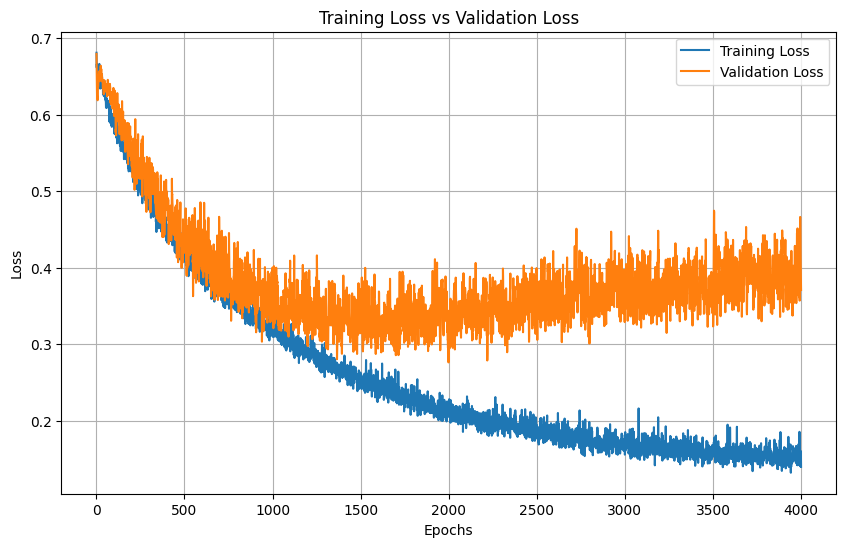

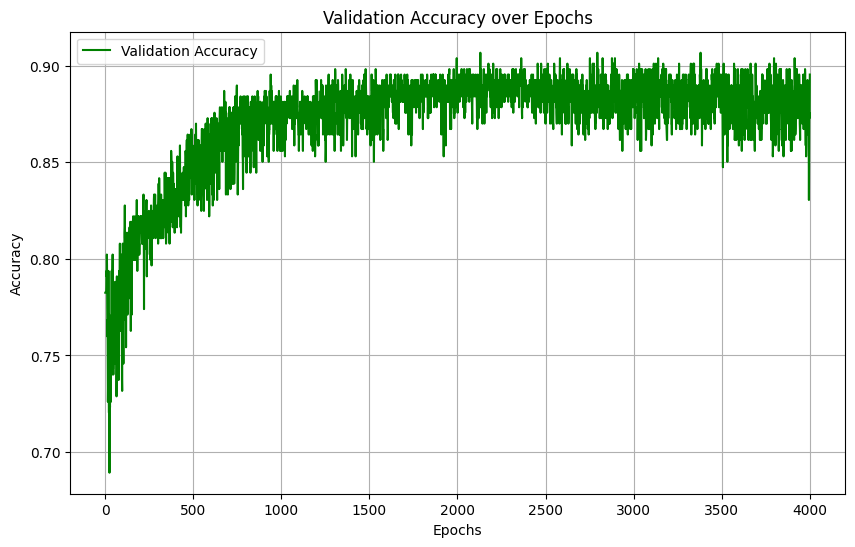

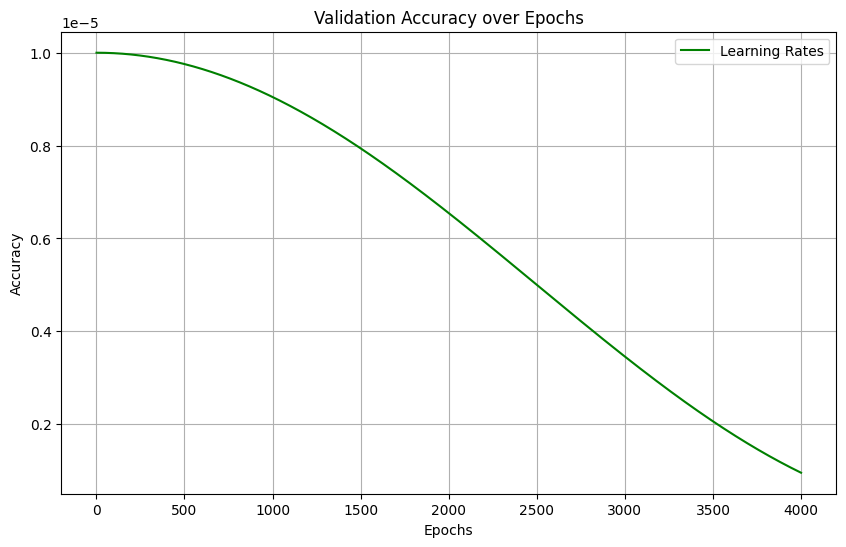

Model for bin 13 saved to GCNModels-5A_exp4/model_bin_13.pth
Training on bin 14/50
Bin 14, Epoch 1/4000, Train Loss: 0.6967, Validation Loss: 0.6665,  Accuracy: 0.7825, LR: 0.000010
Bin 14, Epoch 101/4000, Train Loss: 0.6663, Validation Loss: 0.6121,  Accuracy: 0.8249, LR: 0.000010
Bin 14, Epoch 201/4000, Train Loss: 0.5948, Validation Loss: 0.5477,  Accuracy: 0.8418, LR: 0.000010
Bin 14, Epoch 301/4000, Train Loss: 0.5498, Validation Loss: 0.5027,  Accuracy: 0.8333, LR: 0.000010
Bin 14, Epoch 401/4000, Train Loss: 0.5081, Validation Loss: 0.4460,  Accuracy: 0.8503, LR: 0.000010
Bin 14, Epoch 501/4000, Train Loss: 0.4781, Validation Loss: 0.3734,  Accuracy: 0.8616, LR: 0.000010
Bin 14, Epoch 601/4000, Train Loss: 0.4404, Validation Loss: 0.3745,  Accuracy: 0.8531, LR: 0.000010
Bin 14, Epoch 701/4000, Train Loss: 0.4082, Validation Loss: 0.3686,  Accuracy: 0.8559, LR: 0.000010
Bin 14, Epoch 801/4000, Train Loss: 0.3847, Validation Loss: 0.2983,  Accuracy: 0.8927, LR: 0.000009
Bin 14, Ep

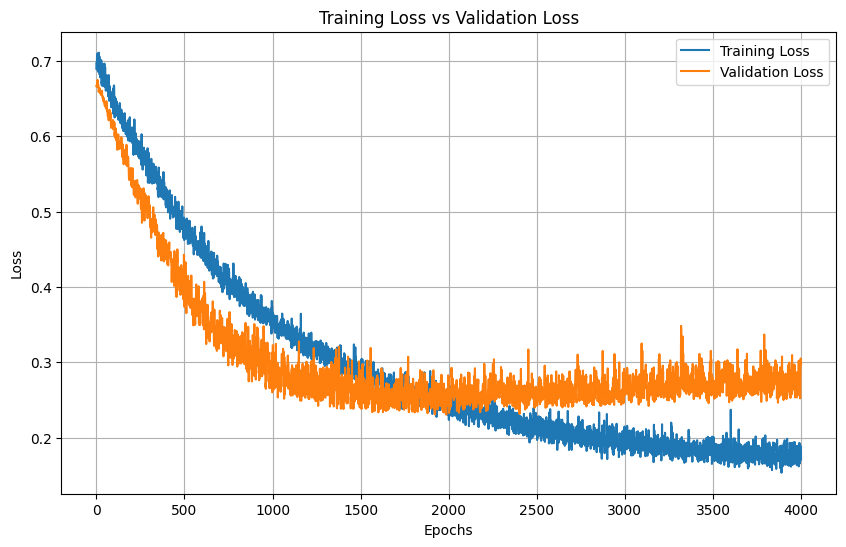

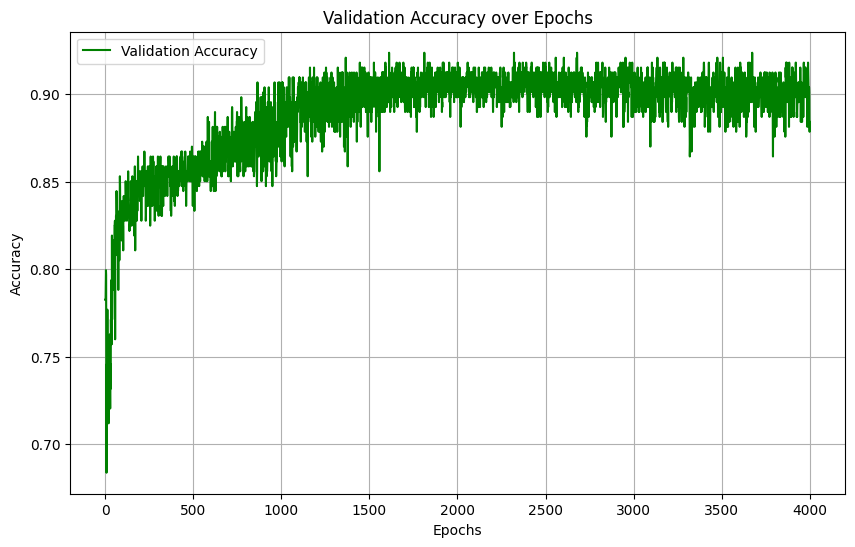

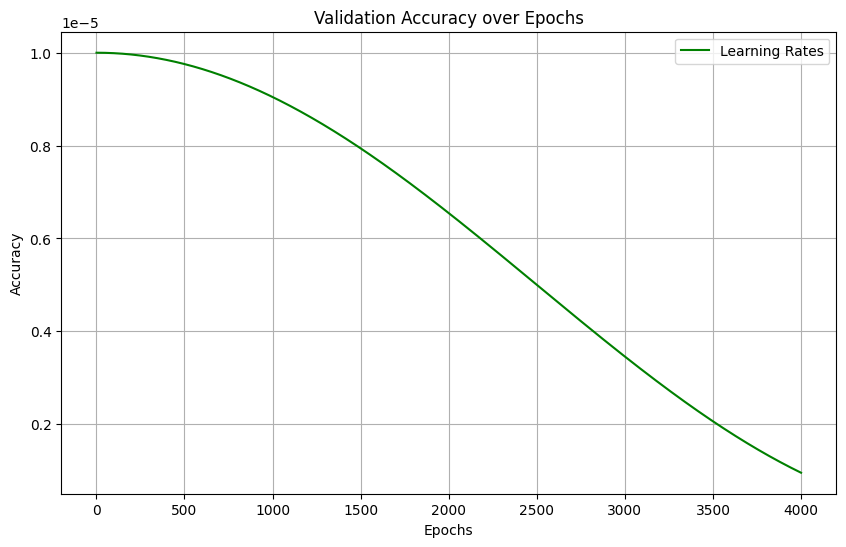

Model for bin 14 saved to GCNModels-5A_exp4/model_bin_14.pth
Training on bin 15/50
Bin 15, Epoch 1/4000, Train Loss: 0.7218, Validation Loss: 0.6761,  Accuracy: 0.7825, LR: 0.000010
Bin 15, Epoch 101/4000, Train Loss: 0.6471, Validation Loss: 0.6417,  Accuracy: 0.7740, LR: 0.000010
Bin 15, Epoch 201/4000, Train Loss: 0.6167, Validation Loss: 0.6008,  Accuracy: 0.7938, LR: 0.000010
Bin 15, Epoch 301/4000, Train Loss: 0.5760, Validation Loss: 0.5671,  Accuracy: 0.7910, LR: 0.000010
Bin 15, Epoch 401/4000, Train Loss: 0.5347, Validation Loss: 0.4832,  Accuracy: 0.8362, LR: 0.000010
Bin 15, Epoch 501/4000, Train Loss: 0.5048, Validation Loss: 0.4287,  Accuracy: 0.8475, LR: 0.000010
Bin 15, Epoch 601/4000, Train Loss: 0.4728, Validation Loss: 0.3909,  Accuracy: 0.8559, LR: 0.000010
Bin 15, Epoch 701/4000, Train Loss: 0.4470, Validation Loss: 0.3538,  Accuracy: 0.8729, LR: 0.000010
Bin 15, Epoch 801/4000, Train Loss: 0.3949, Validation Loss: 0.3645,  Accuracy: 0.8672, LR: 0.000009
Bin 15, Ep

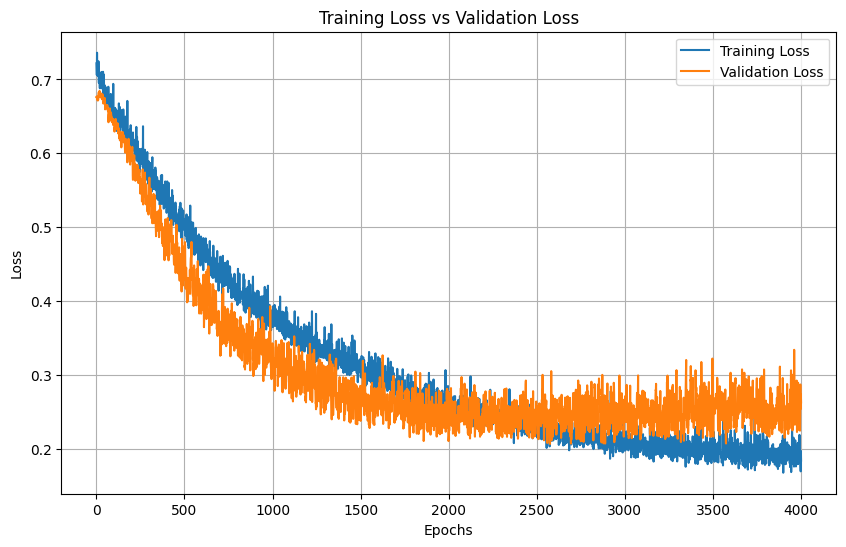

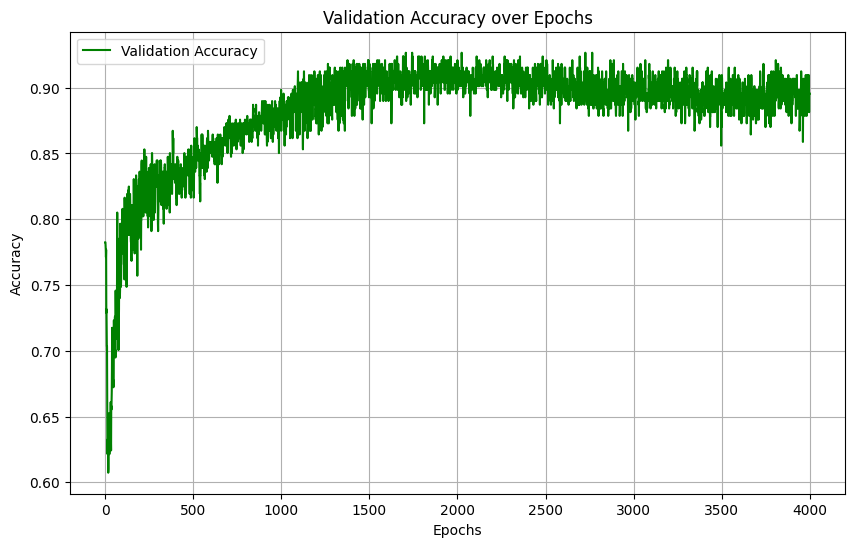

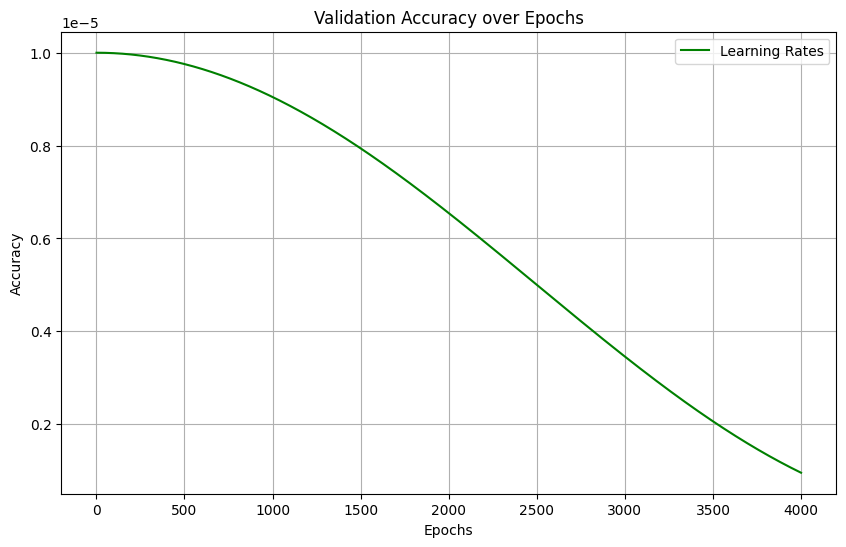

Model for bin 15 saved to GCNModels-5A_exp4/model_bin_15.pth
Training on bin 16/50
Bin 16, Epoch 1/4000, Train Loss: 0.7298, Validation Loss: 0.6699,  Accuracy: 0.7825, LR: 0.000010
Bin 16, Epoch 101/4000, Train Loss: 0.6244, Validation Loss: 0.5976,  Accuracy: 0.8023, LR: 0.000010
Bin 16, Epoch 201/4000, Train Loss: 0.5839, Validation Loss: 0.5520,  Accuracy: 0.8220, LR: 0.000010
Bin 16, Epoch 301/4000, Train Loss: 0.5414, Validation Loss: 0.4905,  Accuracy: 0.8277, LR: 0.000010
Bin 16, Epoch 401/4000, Train Loss: 0.5269, Validation Loss: 0.4637,  Accuracy: 0.8362, LR: 0.000010
Bin 16, Epoch 501/4000, Train Loss: 0.4901, Validation Loss: 0.4182,  Accuracy: 0.8418, LR: 0.000010
Bin 16, Epoch 601/4000, Train Loss: 0.4624, Validation Loss: 0.3885,  Accuracy: 0.8701, LR: 0.000010
Bin 16, Epoch 701/4000, Train Loss: 0.4282, Validation Loss: 0.3718,  Accuracy: 0.8701, LR: 0.000010
Bin 16, Epoch 801/4000, Train Loss: 0.4090, Validation Loss: 0.3743,  Accuracy: 0.8757, LR: 0.000009
Bin 16, Ep

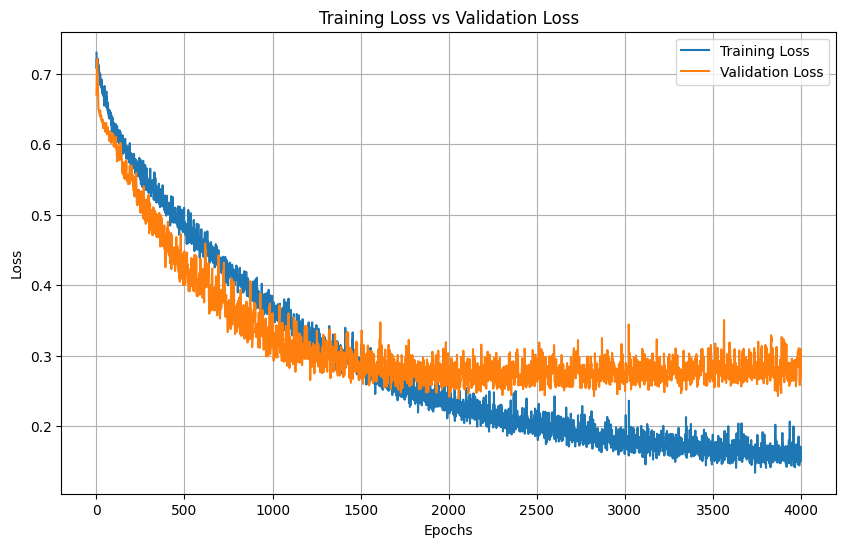

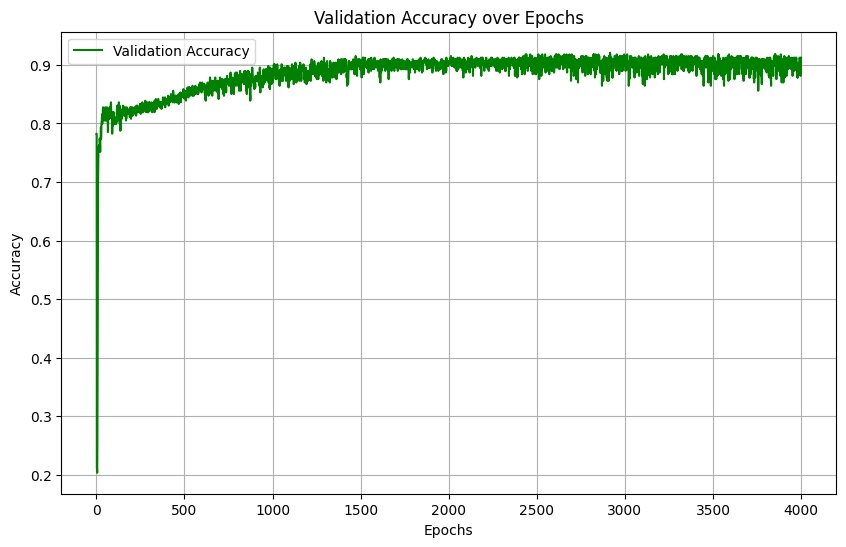

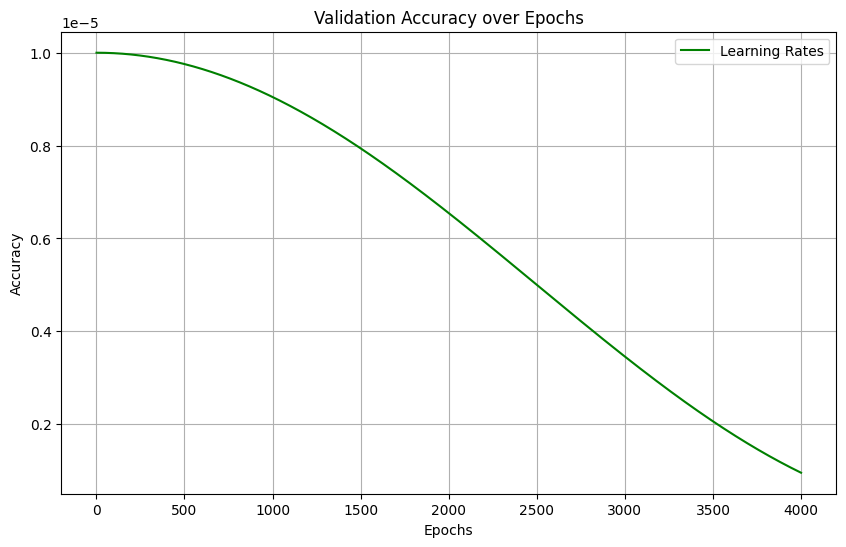

Model for bin 16 saved to GCNModels-5A_exp4/model_bin_16.pth
Training on bin 17/50
Bin 17, Epoch 1/4000, Train Loss: 0.7345, Validation Loss: 0.6582,  Accuracy: 0.7825, LR: 0.000010
Bin 17, Epoch 101/4000, Train Loss: 0.6344, Validation Loss: 0.5913,  Accuracy: 0.8249, LR: 0.000010
Bin 17, Epoch 201/4000, Train Loss: 0.5665, Validation Loss: 0.5118,  Accuracy: 0.8475, LR: 0.000010
Bin 17, Epoch 301/4000, Train Loss: 0.5267, Validation Loss: 0.4333,  Accuracy: 0.8616, LR: 0.000010
Bin 17, Epoch 401/4000, Train Loss: 0.4699, Validation Loss: 0.4060,  Accuracy: 0.8616, LR: 0.000010
Bin 17, Epoch 501/4000, Train Loss: 0.4621, Validation Loss: 0.3748,  Accuracy: 0.8588, LR: 0.000010
Bin 17, Epoch 601/4000, Train Loss: 0.4190, Validation Loss: 0.3695,  Accuracy: 0.8616, LR: 0.000010
Bin 17, Epoch 701/4000, Train Loss: 0.3972, Validation Loss: 0.3370,  Accuracy: 0.8588, LR: 0.000010
Bin 17, Epoch 801/4000, Train Loss: 0.4015, Validation Loss: 0.3319,  Accuracy: 0.8616, LR: 0.000009
Bin 17, Ep

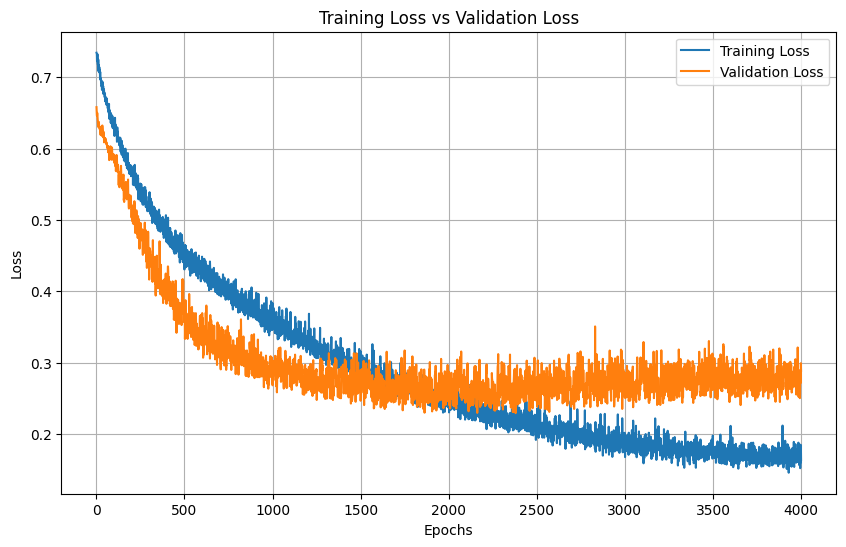

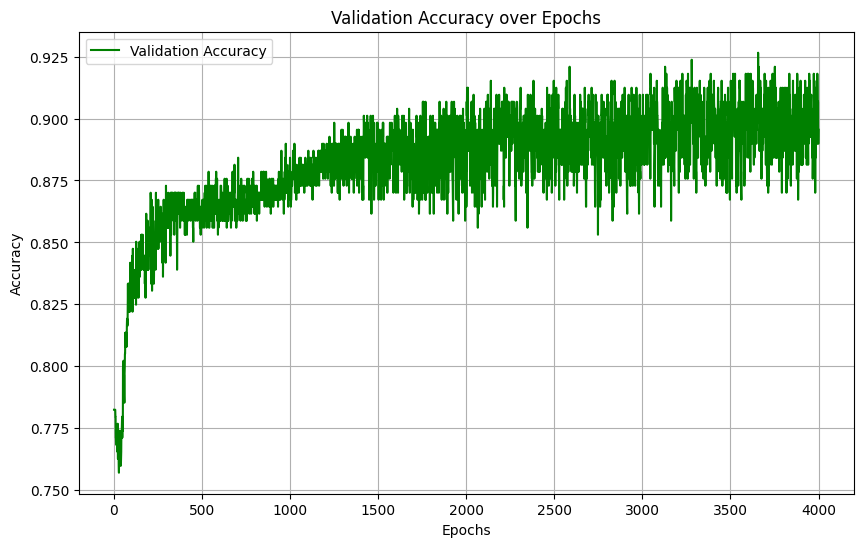

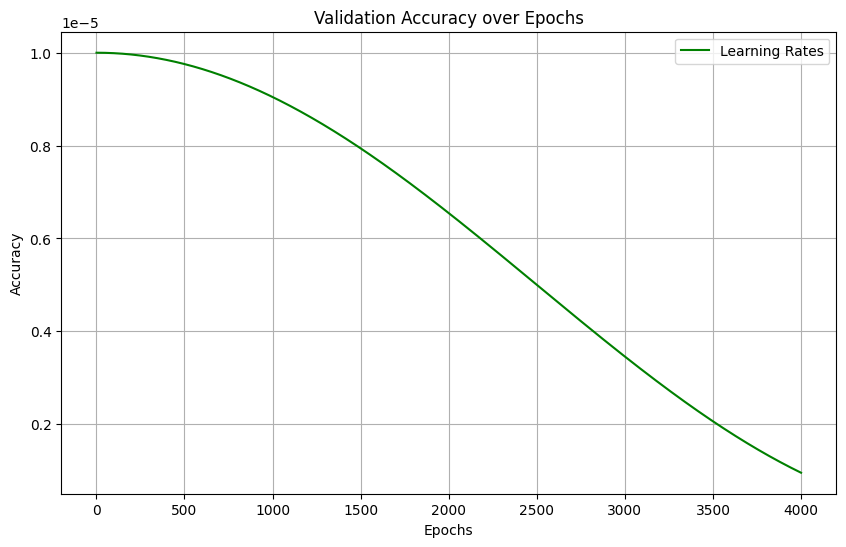

Model for bin 17 saved to GCNModels-5A_exp4/model_bin_17.pth
Training on bin 18/50
Bin 18, Epoch 1/4000, Train Loss: 0.7186, Validation Loss: 0.6590,  Accuracy: 0.7825, LR: 0.000010
Bin 18, Epoch 101/4000, Train Loss: 0.6081, Validation Loss: 0.5949,  Accuracy: 0.8305, LR: 0.000010
Bin 18, Epoch 201/4000, Train Loss: 0.5402, Validation Loss: 0.5204,  Accuracy: 0.8559, LR: 0.000010
Bin 18, Epoch 301/4000, Train Loss: 0.4713, Validation Loss: 0.4592,  Accuracy: 0.8475, LR: 0.000010
Bin 18, Epoch 401/4000, Train Loss: 0.4382, Validation Loss: 0.4290,  Accuracy: 0.8418, LR: 0.000010
Bin 18, Epoch 501/4000, Train Loss: 0.4152, Validation Loss: 0.3968,  Accuracy: 0.8729, LR: 0.000010
Bin 18, Epoch 601/4000, Train Loss: 0.3923, Validation Loss: 0.3549,  Accuracy: 0.8842, LR: 0.000010
Bin 18, Epoch 701/4000, Train Loss: 0.3772, Validation Loss: 0.3329,  Accuracy: 0.8898, LR: 0.000010
Bin 18, Epoch 801/4000, Train Loss: 0.3592, Validation Loss: 0.3512,  Accuracy: 0.8616, LR: 0.000009
Bin 18, Ep

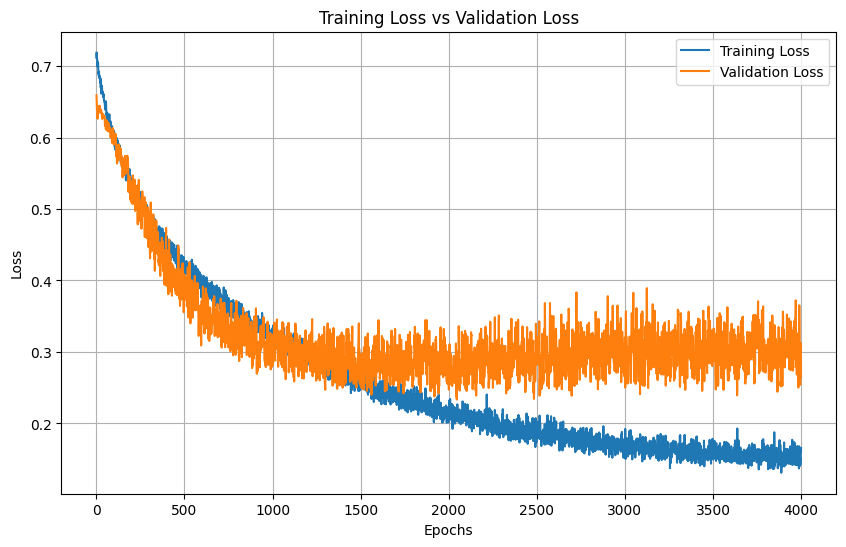

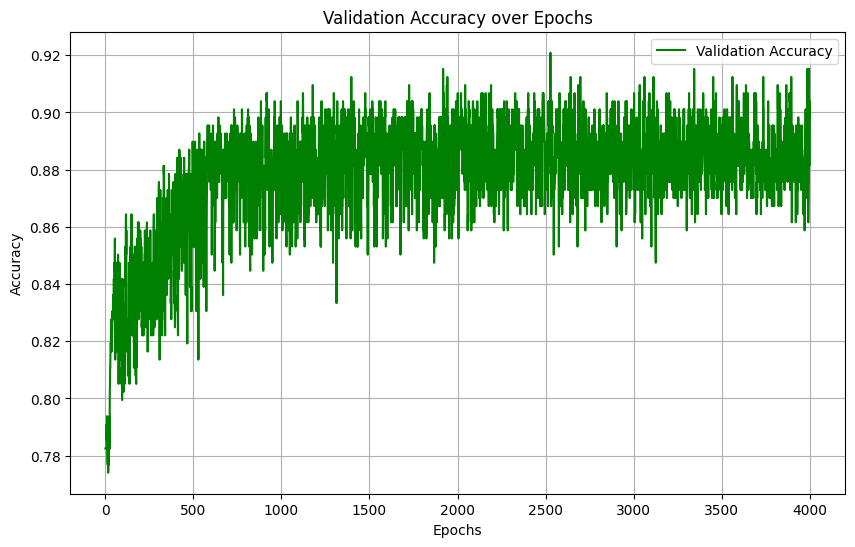

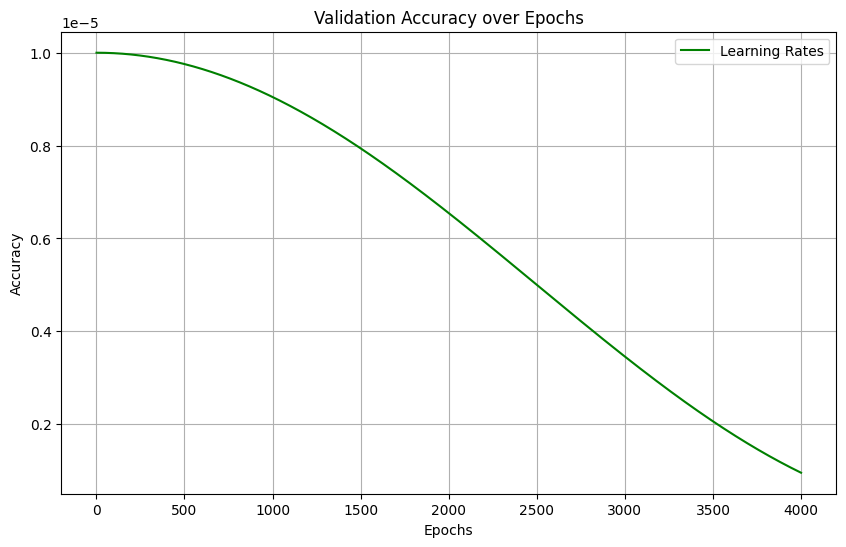

Model for bin 18 saved to GCNModels-5A_exp4/model_bin_18.pth
Training on bin 19/50
Bin 19, Epoch 1/4000, Train Loss: 0.7171, Validation Loss: 0.6947,  Accuracy: 0.2090, LR: 0.000010
Bin 19, Epoch 101/4000, Train Loss: 0.6229, Validation Loss: 0.5730,  Accuracy: 0.8531, LR: 0.000010
Bin 19, Epoch 201/4000, Train Loss: 0.5572, Validation Loss: 0.5001,  Accuracy: 0.8390, LR: 0.000010
Bin 19, Epoch 301/4000, Train Loss: 0.5110, Validation Loss: 0.4522,  Accuracy: 0.8475, LR: 0.000010
Bin 19, Epoch 401/4000, Train Loss: 0.4831, Validation Loss: 0.3857,  Accuracy: 0.8644, LR: 0.000010
Bin 19, Epoch 501/4000, Train Loss: 0.4549, Validation Loss: 0.3653,  Accuracy: 0.8757, LR: 0.000010
Bin 19, Epoch 601/4000, Train Loss: 0.4253, Validation Loss: 0.3263,  Accuracy: 0.8842, LR: 0.000010
Bin 19, Epoch 701/4000, Train Loss: 0.4064, Validation Loss: 0.3051,  Accuracy: 0.8927, LR: 0.000010
Bin 19, Epoch 801/4000, Train Loss: 0.3873, Validation Loss: 0.3023,  Accuracy: 0.8983, LR: 0.000009
Bin 19, Ep

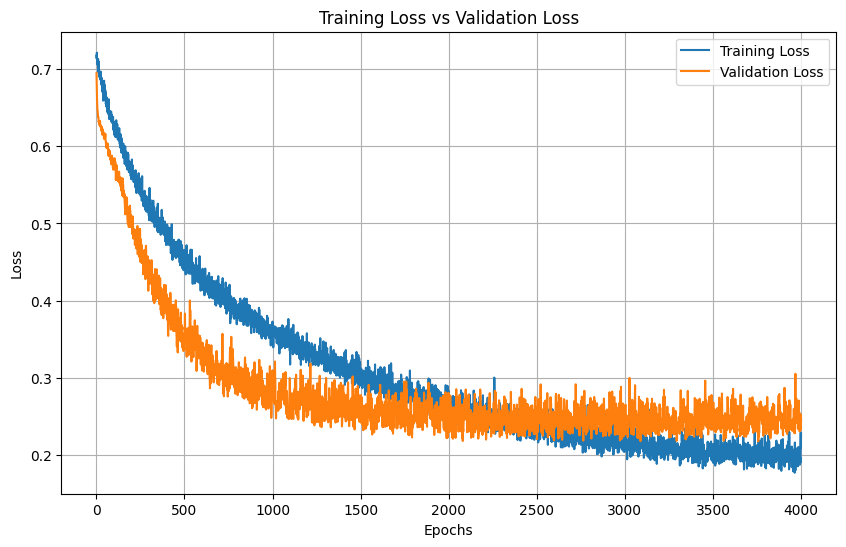

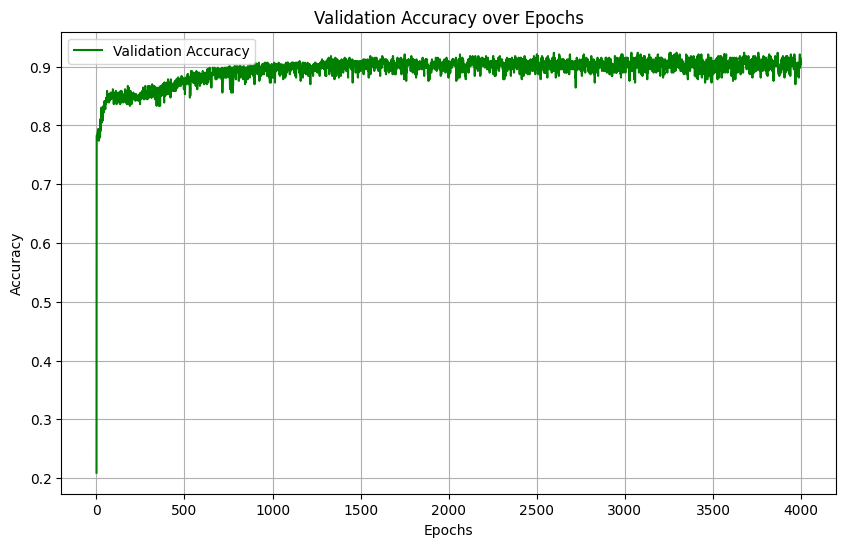

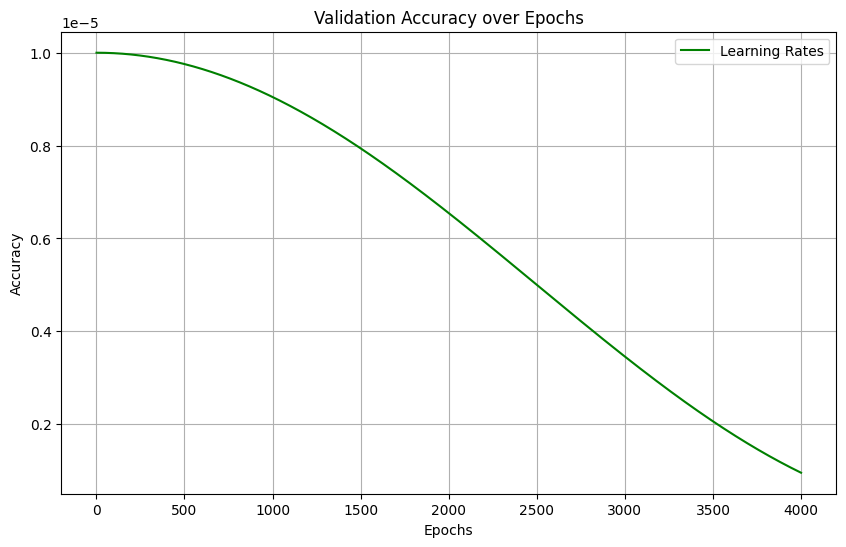

Model for bin 19 saved to GCNModels-5A_exp4/model_bin_19.pth
Training on bin 20/50
Bin 20, Epoch 1/4000, Train Loss: 0.7106, Validation Loss: 0.7192,  Accuracy: 0.2175, LR: 0.000010
Bin 20, Epoch 101/4000, Train Loss: 0.6329, Validation Loss: 0.6370,  Accuracy: 0.6949, LR: 0.000010
Bin 20, Epoch 201/4000, Train Loss: 0.5666, Validation Loss: 0.5408,  Accuracy: 0.7938, LR: 0.000010
Bin 20, Epoch 301/4000, Train Loss: 0.5162, Validation Loss: 0.4654,  Accuracy: 0.8192, LR: 0.000010
Bin 20, Epoch 401/4000, Train Loss: 0.4696, Validation Loss: 0.4342,  Accuracy: 0.8192, LR: 0.000010
Bin 20, Epoch 501/4000, Train Loss: 0.4346, Validation Loss: 0.4274,  Accuracy: 0.8192, LR: 0.000010
Bin 20, Epoch 601/4000, Train Loss: 0.4156, Validation Loss: 0.3501,  Accuracy: 0.8475, LR: 0.000010
Bin 20, Epoch 701/4000, Train Loss: 0.3979, Validation Loss: 0.3381,  Accuracy: 0.8503, LR: 0.000010
Bin 20, Epoch 801/4000, Train Loss: 0.3701, Validation Loss: 0.2920,  Accuracy: 0.8785, LR: 0.000009
Bin 20, Ep

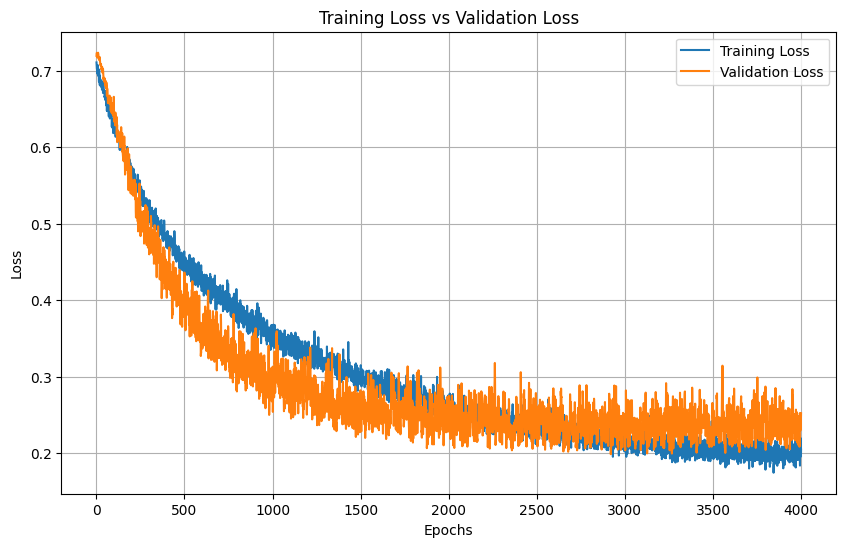

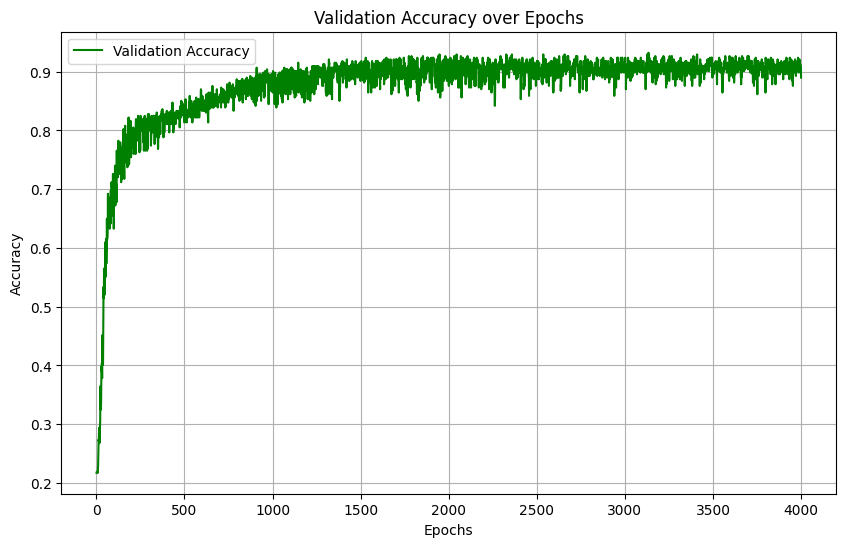

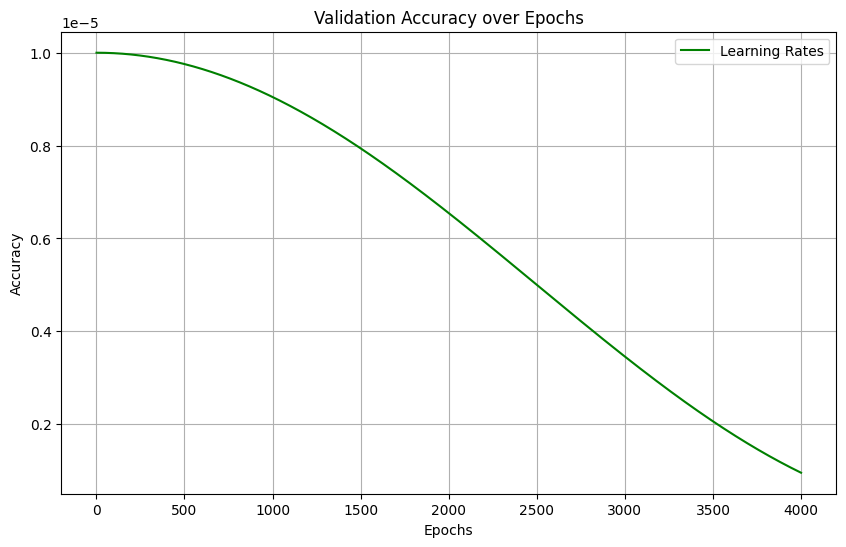

Model for bin 20 saved to GCNModels-5A_exp4/model_bin_20.pth
Training on bin 21/50
Bin 21, Epoch 1/4000, Train Loss: 0.7019, Validation Loss: 0.7186,  Accuracy: 0.2175, LR: 0.000010
Bin 21, Epoch 101/4000, Train Loss: 0.6210, Validation Loss: 0.6414,  Accuracy: 0.7740, LR: 0.000010
Bin 21, Epoch 201/4000, Train Loss: 0.5758, Validation Loss: 0.5200,  Accuracy: 0.8390, LR: 0.000010
Bin 21, Epoch 301/4000, Train Loss: 0.5088, Validation Loss: 0.4615,  Accuracy: 0.8588, LR: 0.000010
Bin 21, Epoch 401/4000, Train Loss: 0.4705, Validation Loss: 0.4176,  Accuracy: 0.8503, LR: 0.000010
Bin 21, Epoch 501/4000, Train Loss: 0.4633, Validation Loss: 0.4031,  Accuracy: 0.8531, LR: 0.000010
Bin 21, Epoch 601/4000, Train Loss: 0.4291, Validation Loss: 0.3727,  Accuracy: 0.8503, LR: 0.000010
Bin 21, Epoch 701/4000, Train Loss: 0.4036, Validation Loss: 0.3538,  Accuracy: 0.8644, LR: 0.000010
Bin 21, Epoch 801/4000, Train Loss: 0.3944, Validation Loss: 0.3502,  Accuracy: 0.8644, LR: 0.000009
Bin 21, Ep

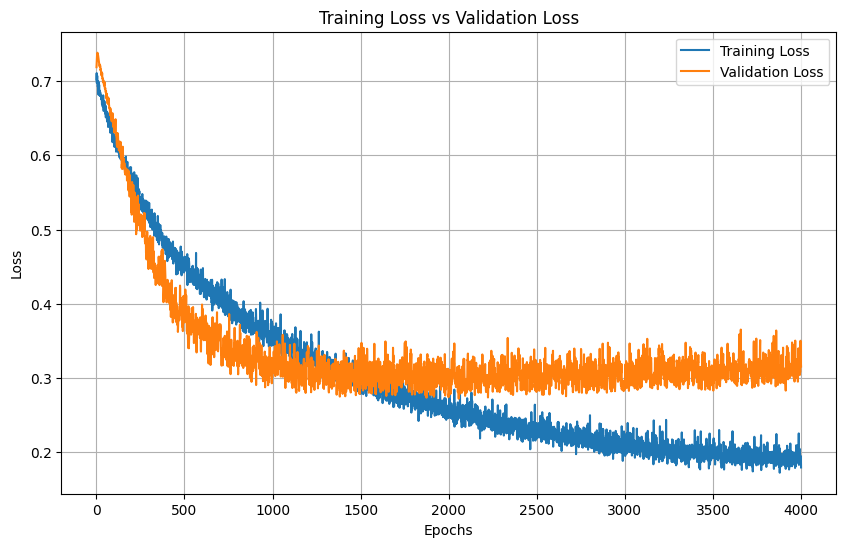

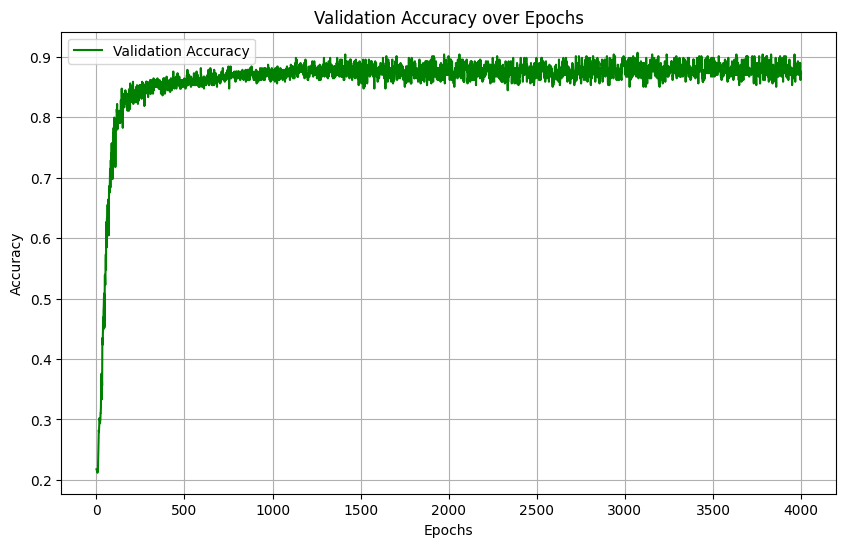

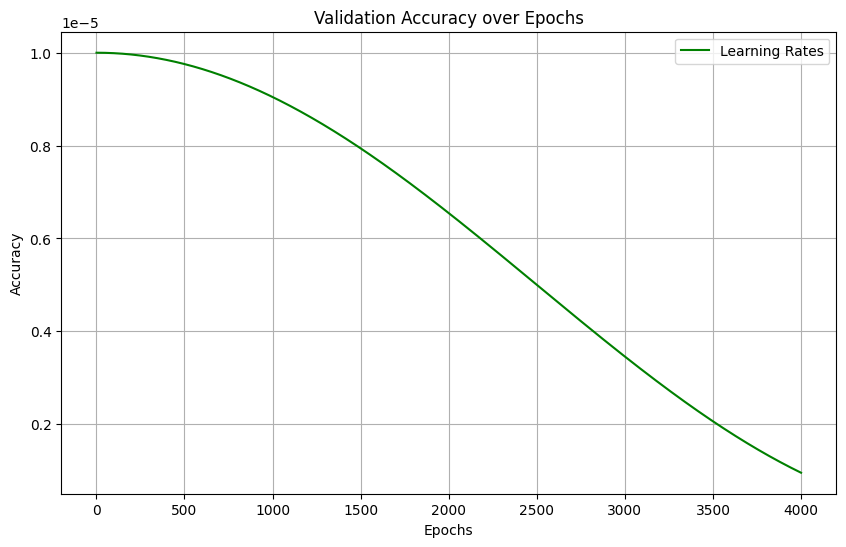

Model for bin 21 saved to GCNModels-5A_exp4/model_bin_21.pth
Training on bin 22/50
Bin 22, Epoch 1/4000, Train Loss: 0.7148, Validation Loss: 0.7269,  Accuracy: 0.2175, LR: 0.000010
Bin 22, Epoch 101/4000, Train Loss: 0.6479, Validation Loss: 0.6706,  Accuracy: 0.6582, LR: 0.000010
Bin 22, Epoch 201/4000, Train Loss: 0.6082, Validation Loss: 0.5821,  Accuracy: 0.7881, LR: 0.000010
Bin 22, Epoch 301/4000, Train Loss: 0.5343, Validation Loss: 0.5480,  Accuracy: 0.7712, LR: 0.000010
Bin 22, Epoch 401/4000, Train Loss: 0.4937, Validation Loss: 0.4668,  Accuracy: 0.8136, LR: 0.000010
Bin 22, Epoch 501/4000, Train Loss: 0.4514, Validation Loss: 0.4140,  Accuracy: 0.8362, LR: 0.000010
Bin 22, Epoch 601/4000, Train Loss: 0.4215, Validation Loss: 0.3416,  Accuracy: 0.8672, LR: 0.000010
Bin 22, Epoch 701/4000, Train Loss: 0.3994, Validation Loss: 0.3529,  Accuracy: 0.8616, LR: 0.000010
Bin 22, Epoch 801/4000, Train Loss: 0.3810, Validation Loss: 0.3813,  Accuracy: 0.8305, LR: 0.000009
Bin 22, Ep

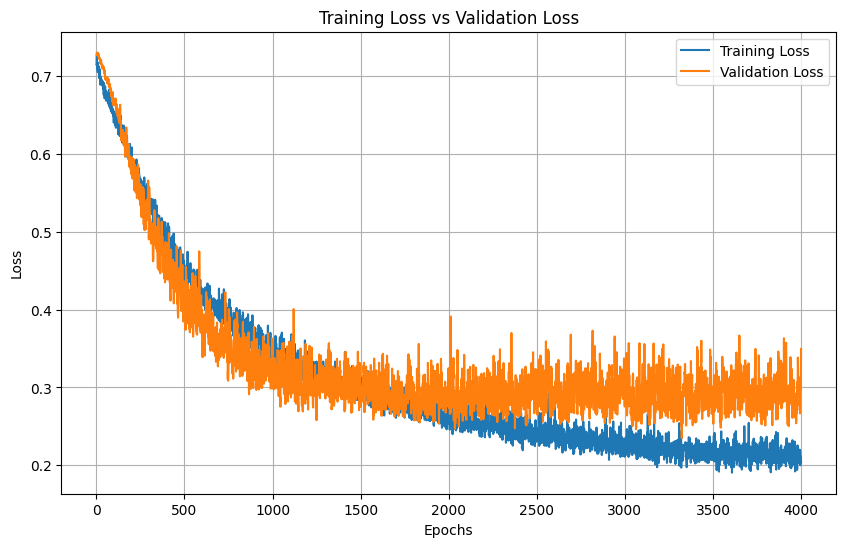

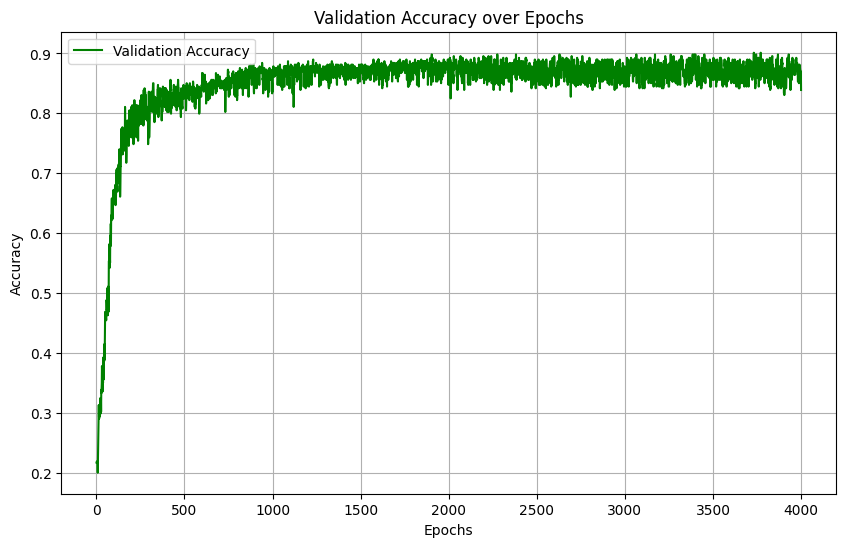

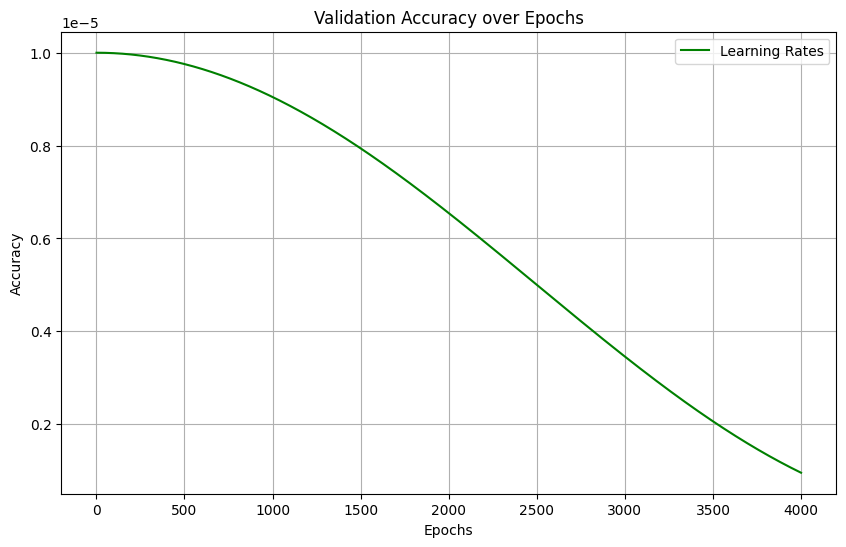

Model for bin 22 saved to GCNModels-5A_exp4/model_bin_22.pth
Training on bin 23/50
Bin 23, Epoch 1/4000, Train Loss: 0.7001, Validation Loss: 0.6736,  Accuracy: 0.7825, LR: 0.000010
Bin 23, Epoch 101/4000, Train Loss: 0.6099, Validation Loss: 0.6399,  Accuracy: 0.7373, LR: 0.000010
Bin 23, Epoch 201/4000, Train Loss: 0.5456, Validation Loss: 0.5803,  Accuracy: 0.7994, LR: 0.000010
Bin 23, Epoch 301/4000, Train Loss: 0.4935, Validation Loss: 0.5041,  Accuracy: 0.8305, LR: 0.000010
Bin 23, Epoch 401/4000, Train Loss: 0.4385, Validation Loss: 0.4442,  Accuracy: 0.8559, LR: 0.000010
Bin 23, Epoch 501/4000, Train Loss: 0.3930, Validation Loss: 0.3929,  Accuracy: 0.8729, LR: 0.000010
Bin 23, Epoch 601/4000, Train Loss: 0.3787, Validation Loss: 0.3824,  Accuracy: 0.8701, LR: 0.000010
Bin 23, Epoch 701/4000, Train Loss: 0.3337, Validation Loss: 0.3224,  Accuracy: 0.8785, LR: 0.000010
Bin 23, Epoch 801/4000, Train Loss: 0.3114, Validation Loss: 0.3587,  Accuracy: 0.8729, LR: 0.000009
Bin 23, Ep

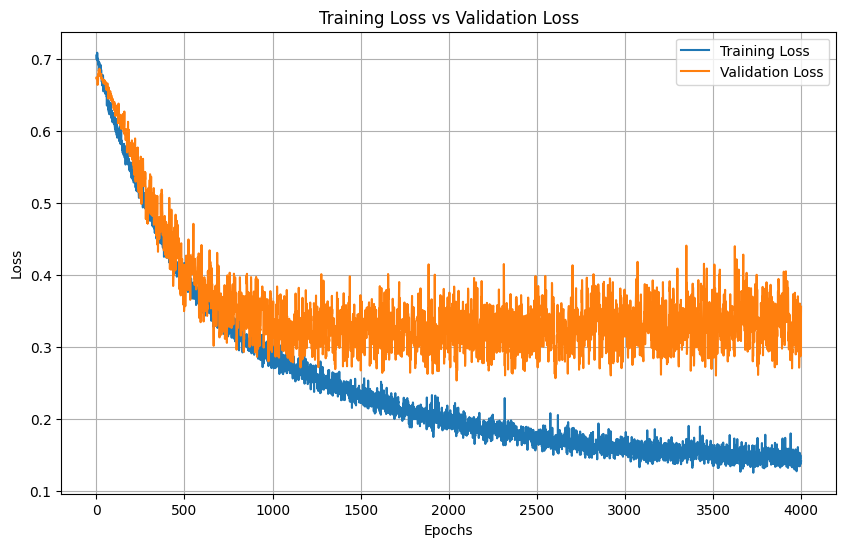

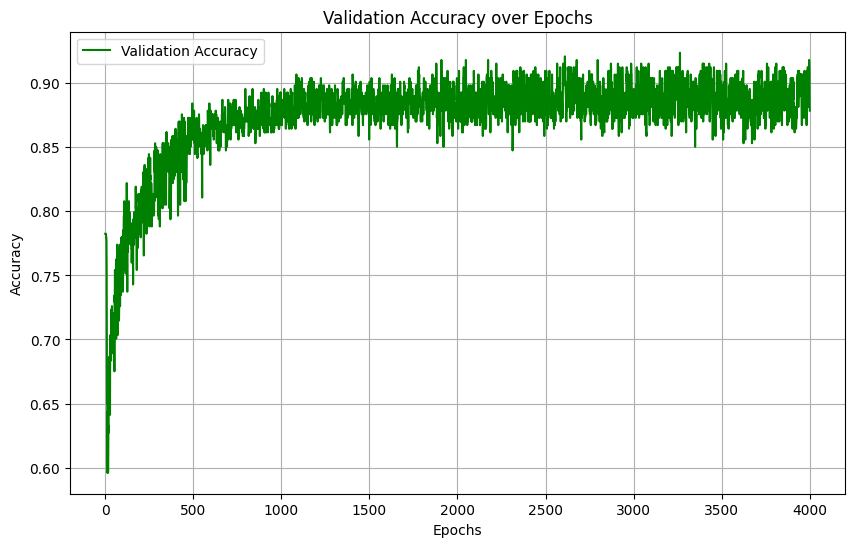

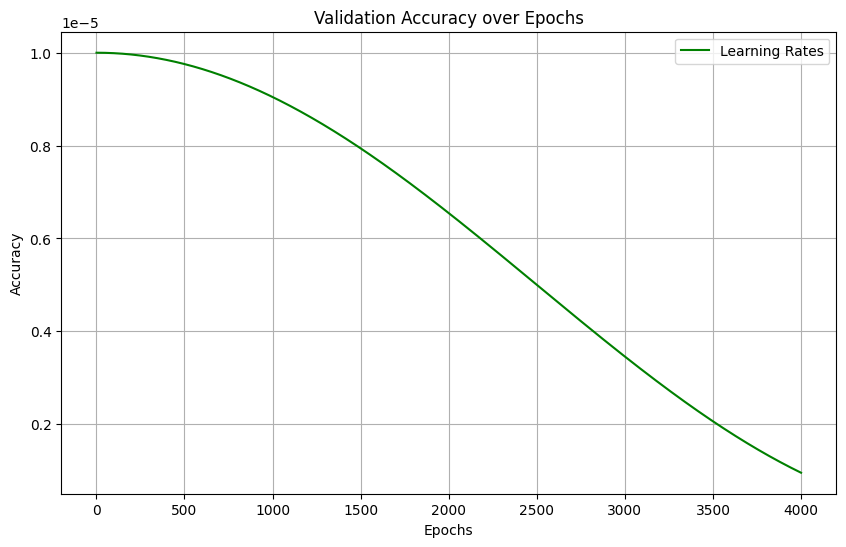

Model for bin 23 saved to GCNModels-5A_exp4/model_bin_23.pth
Training on bin 24/50
Bin 24, Epoch 1/4000, Train Loss: 0.6944, Validation Loss: 0.6875,  Accuracy: 0.7825, LR: 0.000010
Bin 24, Epoch 101/4000, Train Loss: 0.6409, Validation Loss: 0.6193,  Accuracy: 0.7316, LR: 0.000010
Bin 24, Epoch 201/4000, Train Loss: 0.5920, Validation Loss: 0.5704,  Accuracy: 0.7401, LR: 0.000010
Bin 24, Epoch 301/4000, Train Loss: 0.5336, Validation Loss: 0.5048,  Accuracy: 0.7994, LR: 0.000010
Bin 24, Epoch 401/4000, Train Loss: 0.5003, Validation Loss: 0.4532,  Accuracy: 0.8277, LR: 0.000010
Bin 24, Epoch 501/4000, Train Loss: 0.4738, Validation Loss: 0.4155,  Accuracy: 0.8362, LR: 0.000010
Bin 24, Epoch 601/4000, Train Loss: 0.4420, Validation Loss: 0.4018,  Accuracy: 0.8362, LR: 0.000010
Bin 24, Epoch 701/4000, Train Loss: 0.4283, Validation Loss: 0.3642,  Accuracy: 0.8559, LR: 0.000010
Bin 24, Epoch 801/4000, Train Loss: 0.4076, Validation Loss: 0.3666,  Accuracy: 0.8503, LR: 0.000009
Bin 24, Ep

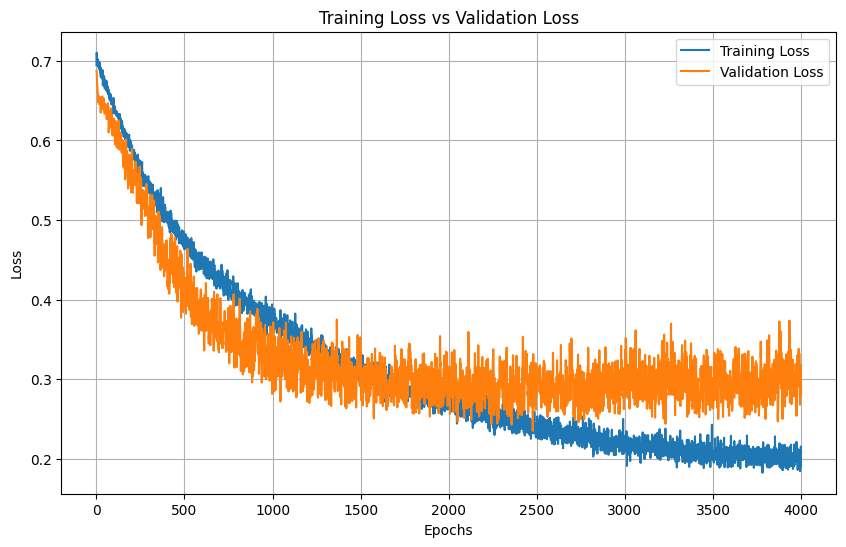

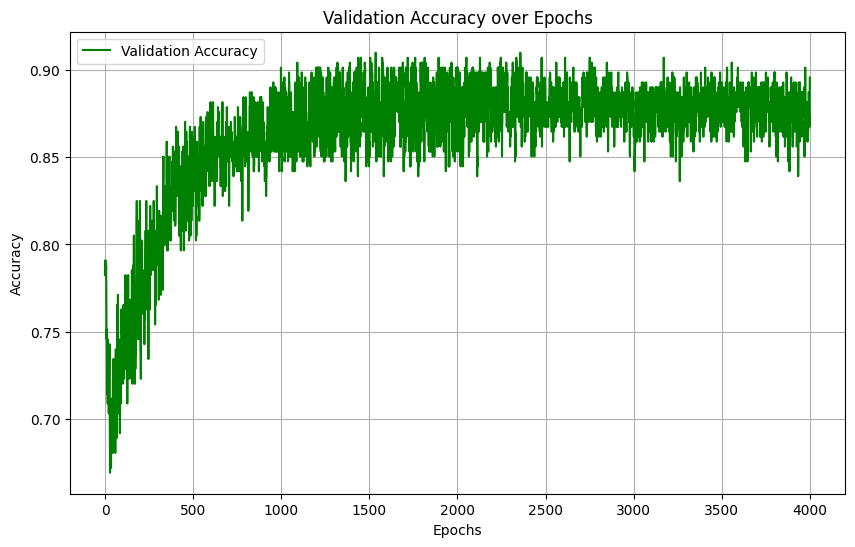

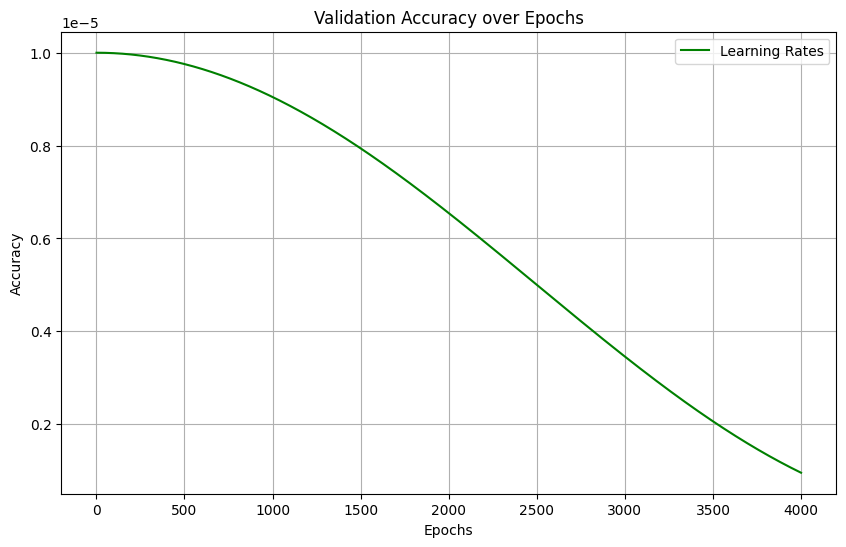

Model for bin 24 saved to GCNModels-5A_exp4/model_bin_24.pth
Training on bin 25/50
Bin 25, Epoch 1/4000, Train Loss: 0.6945, Validation Loss: 0.7071,  Accuracy: 0.2175, LR: 0.000010
Bin 25, Epoch 101/4000, Train Loss: 0.6263, Validation Loss: 0.6449,  Accuracy: 0.7232, LR: 0.000010
Bin 25, Epoch 201/4000, Train Loss: 0.5833, Validation Loss: 0.5790,  Accuracy: 0.8107, LR: 0.000010
Bin 25, Epoch 301/4000, Train Loss: 0.5381, Validation Loss: 0.5135,  Accuracy: 0.8305, LR: 0.000010
Bin 25, Epoch 401/4000, Train Loss: 0.5029, Validation Loss: 0.4460,  Accuracy: 0.8616, LR: 0.000010
Bin 25, Epoch 501/4000, Train Loss: 0.4560, Validation Loss: 0.4422,  Accuracy: 0.8475, LR: 0.000010
Bin 25, Epoch 601/4000, Train Loss: 0.4456, Validation Loss: 0.3770,  Accuracy: 0.8672, LR: 0.000010
Bin 25, Epoch 701/4000, Train Loss: 0.4034, Validation Loss: 0.3994,  Accuracy: 0.8503, LR: 0.000010
Bin 25, Epoch 801/4000, Train Loss: 0.4023, Validation Loss: 0.3395,  Accuracy: 0.8898, LR: 0.000009
Bin 25, Ep

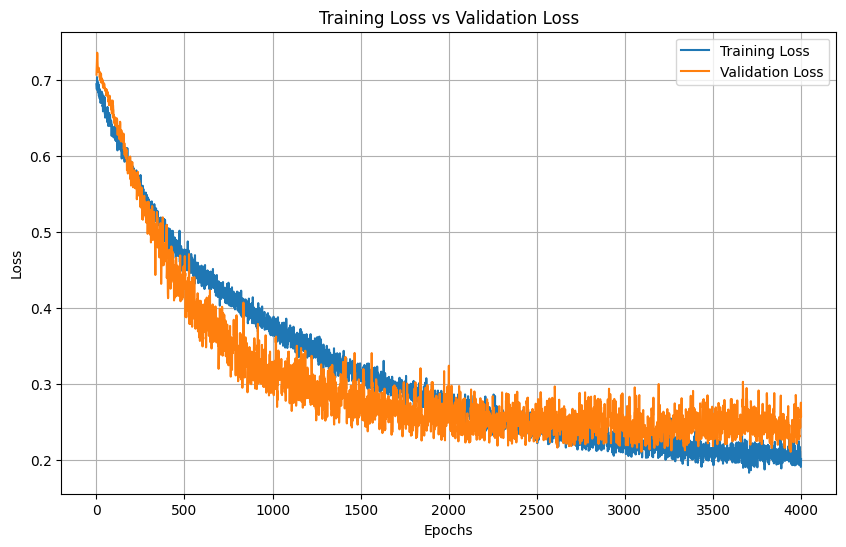

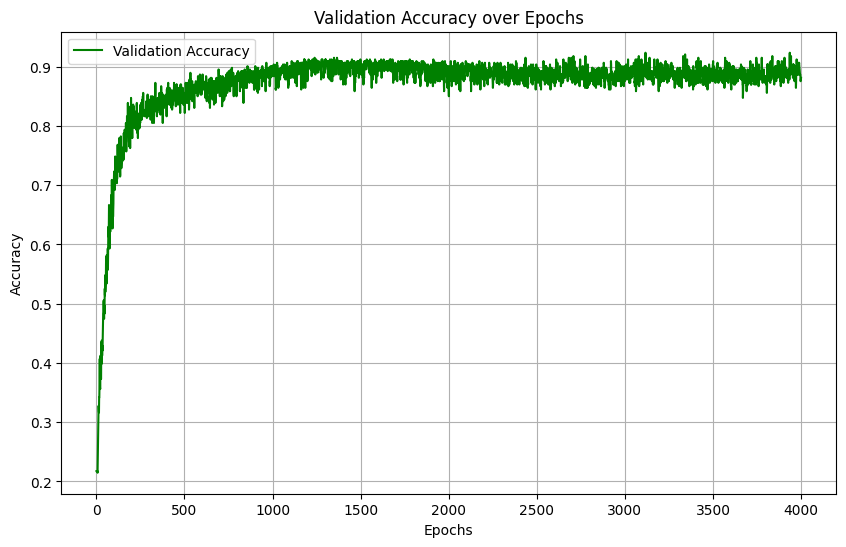

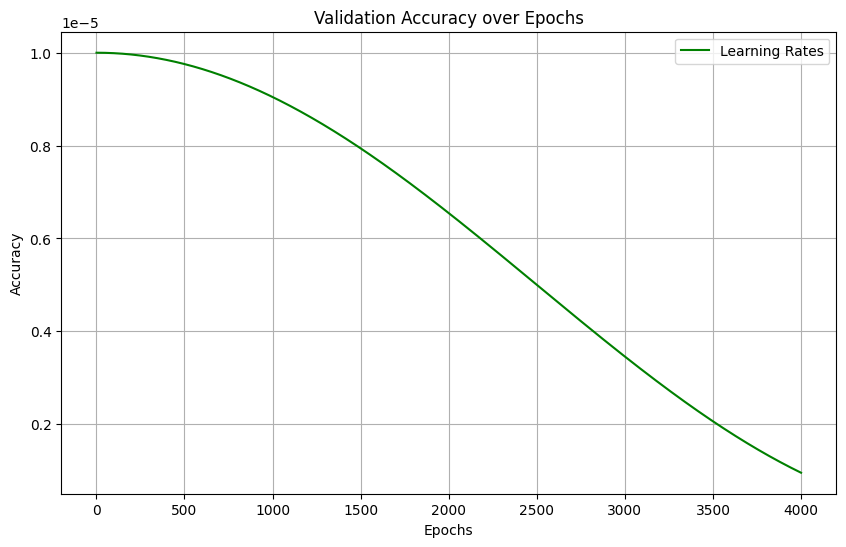

Model for bin 25 saved to GCNModels-5A_exp4/model_bin_25.pth
Training on bin 26/50
Bin 26, Epoch 1/4000, Train Loss: 0.6906, Validation Loss: 0.6744,  Accuracy: 0.7825, LR: 0.000010
Bin 26, Epoch 101/4000, Train Loss: 0.6288, Validation Loss: 0.6320,  Accuracy: 0.8164, LR: 0.000010
Bin 26, Epoch 201/4000, Train Loss: 0.5691, Validation Loss: 0.5831,  Accuracy: 0.8305, LR: 0.000010
Bin 26, Epoch 301/4000, Train Loss: 0.5269, Validation Loss: 0.5222,  Accuracy: 0.8475, LR: 0.000010
Bin 26, Epoch 401/4000, Train Loss: 0.5092, Validation Loss: 0.5064,  Accuracy: 0.8418, LR: 0.000010
Bin 26, Epoch 501/4000, Train Loss: 0.4753, Validation Loss: 0.4711,  Accuracy: 0.8475, LR: 0.000010
Bin 26, Epoch 601/4000, Train Loss: 0.4376, Validation Loss: 0.4069,  Accuracy: 0.8757, LR: 0.000010
Bin 26, Epoch 701/4000, Train Loss: 0.4116, Validation Loss: 0.3775,  Accuracy: 0.8701, LR: 0.000010
Bin 26, Epoch 801/4000, Train Loss: 0.4027, Validation Loss: 0.4066,  Accuracy: 0.8588, LR: 0.000009
Bin 26, Ep

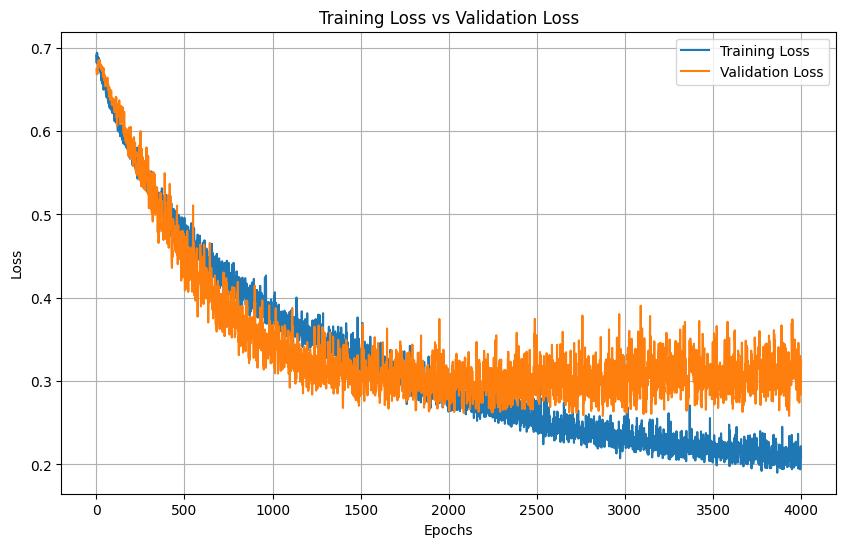

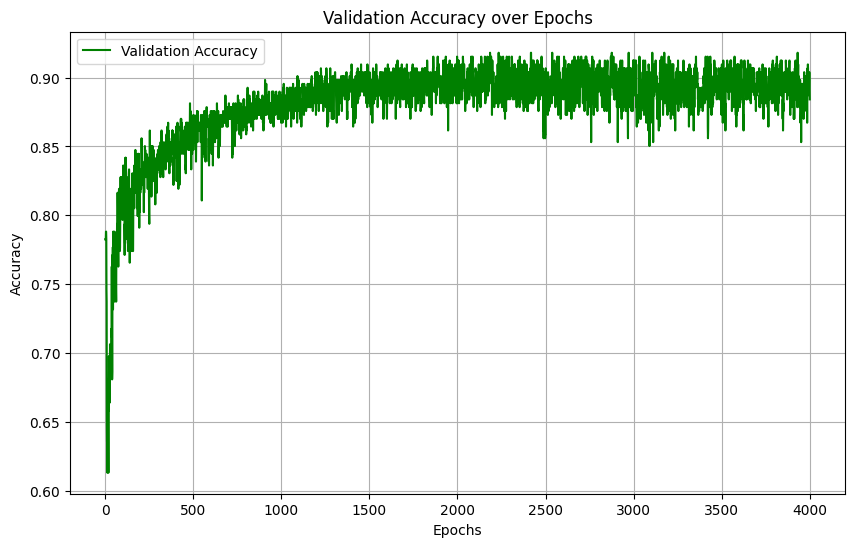

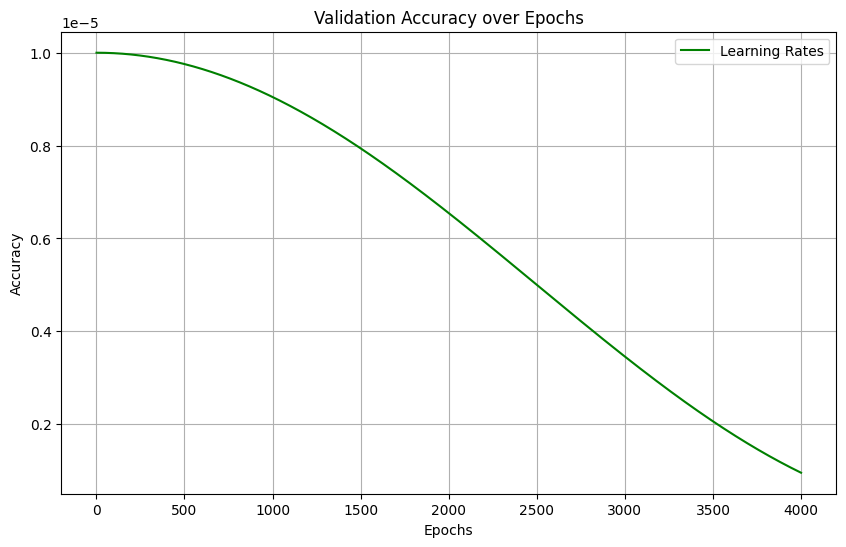

Model for bin 26 saved to GCNModels-5A_exp4/model_bin_26.pth
Training on bin 27/50
Bin 27, Epoch 1/4000, Train Loss: 0.7107, Validation Loss: 0.6588,  Accuracy: 0.7825, LR: 0.000010
Bin 27, Epoch 101/4000, Train Loss: 0.6348, Validation Loss: 0.6090,  Accuracy: 0.8164, LR: 0.000010
Bin 27, Epoch 201/4000, Train Loss: 0.5773, Validation Loss: 0.5570,  Accuracy: 0.8220, LR: 0.000010
Bin 27, Epoch 301/4000, Train Loss: 0.5385, Validation Loss: 0.4983,  Accuracy: 0.8390, LR: 0.000010
Bin 27, Epoch 401/4000, Train Loss: 0.4882, Validation Loss: 0.4697,  Accuracy: 0.8333, LR: 0.000010
Bin 27, Epoch 501/4000, Train Loss: 0.4769, Validation Loss: 0.3843,  Accuracy: 0.8588, LR: 0.000010
Bin 27, Epoch 601/4000, Train Loss: 0.4353, Validation Loss: 0.3854,  Accuracy: 0.8503, LR: 0.000010
Bin 27, Epoch 701/4000, Train Loss: 0.4171, Validation Loss: 0.3346,  Accuracy: 0.8729, LR: 0.000010
Bin 27, Epoch 801/4000, Train Loss: 0.4254, Validation Loss: 0.3522,  Accuracy: 0.8672, LR: 0.000009
Bin 27, Ep

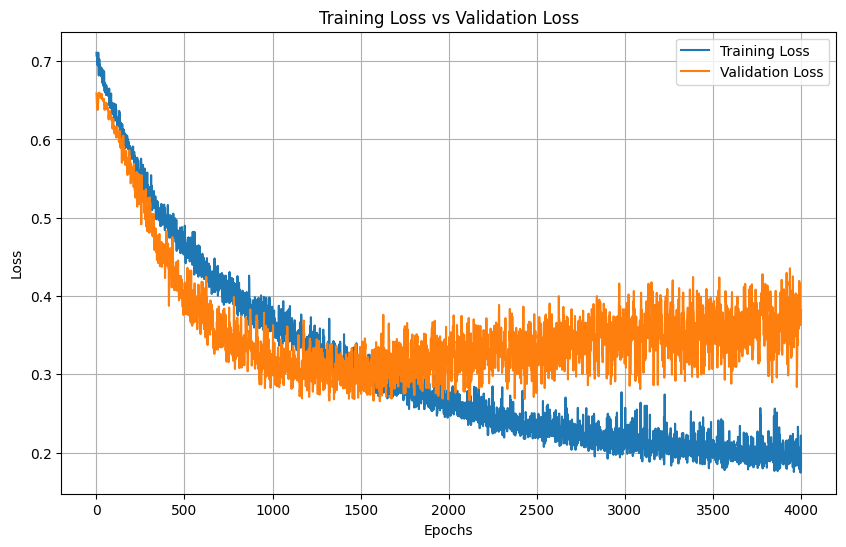

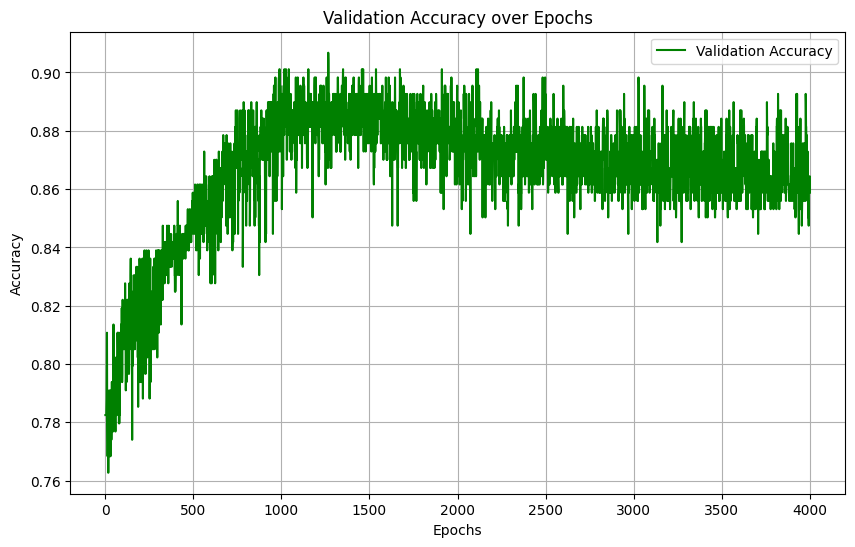

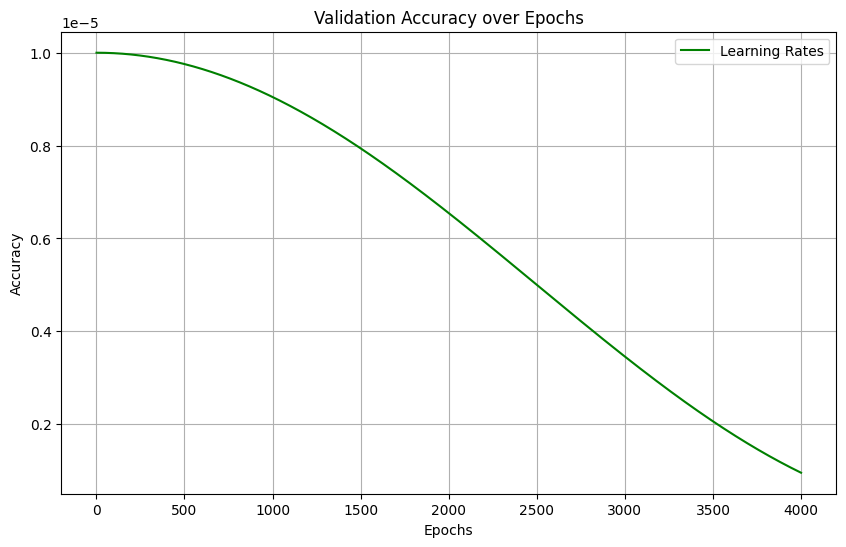

Model for bin 27 saved to GCNModels-5A_exp4/model_bin_27.pth
Training on bin 28/50
Bin 28, Epoch 1/4000, Train Loss: 0.6963, Validation Loss: 0.7026,  Accuracy: 0.2175, LR: 0.000010
Bin 28, Epoch 101/4000, Train Loss: 0.6489, Validation Loss: 0.6688,  Accuracy: 0.6243, LR: 0.000010
Bin 28, Epoch 201/4000, Train Loss: 0.6095, Validation Loss: 0.6139,  Accuracy: 0.7316, LR: 0.000010
Bin 28, Epoch 301/4000, Train Loss: 0.5606, Validation Loss: 0.5267,  Accuracy: 0.8192, LR: 0.000010
Bin 28, Epoch 401/4000, Train Loss: 0.5216, Validation Loss: 0.4700,  Accuracy: 0.8277, LR: 0.000010
Bin 28, Epoch 501/4000, Train Loss: 0.4781, Validation Loss: 0.4494,  Accuracy: 0.8249, LR: 0.000010
Bin 28, Epoch 601/4000, Train Loss: 0.4571, Validation Loss: 0.3963,  Accuracy: 0.8446, LR: 0.000010
Bin 28, Epoch 701/4000, Train Loss: 0.4413, Validation Loss: 0.3978,  Accuracy: 0.8390, LR: 0.000010
Bin 28, Epoch 801/4000, Train Loss: 0.4228, Validation Loss: 0.3772,  Accuracy: 0.8418, LR: 0.000009
Bin 28, Ep

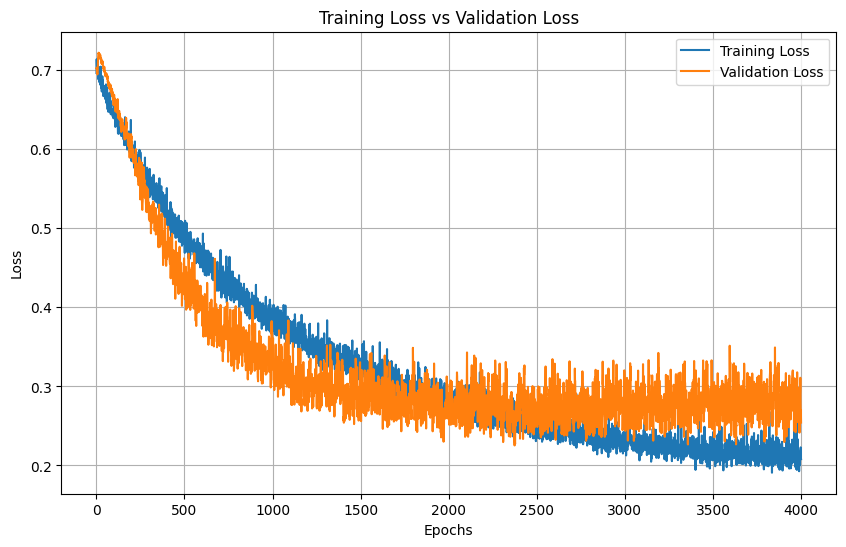

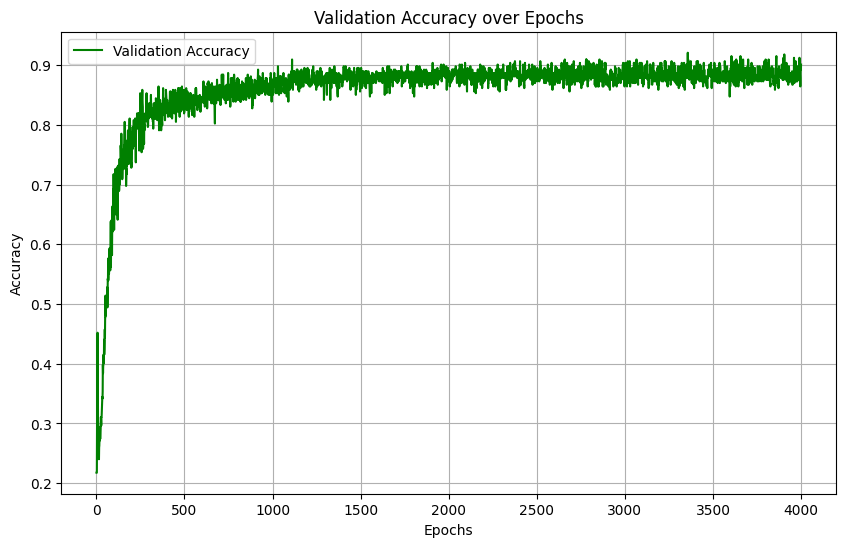

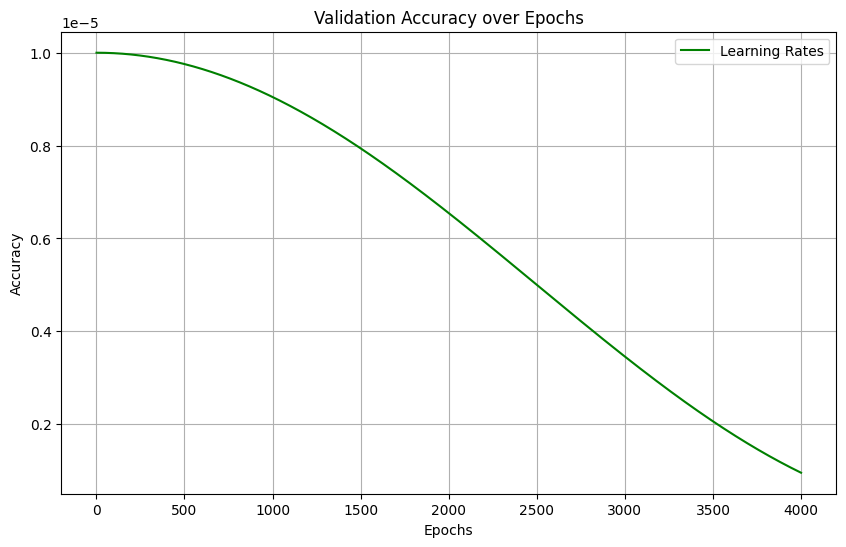

Model for bin 28 saved to GCNModels-5A_exp4/model_bin_28.pth
Training on bin 29/50
Bin 29, Epoch 1/4000, Train Loss: 0.6697, Validation Loss: 0.6728,  Accuracy: 0.7825, LR: 0.000010
Bin 29, Epoch 101/4000, Train Loss: 0.6054, Validation Loss: 0.5703,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 201/4000, Train Loss: 0.5439, Validation Loss: 0.4958,  Accuracy: 0.8616, LR: 0.000010
Bin 29, Epoch 301/4000, Train Loss: 0.5104, Validation Loss: 0.4452,  Accuracy: 0.8559, LR: 0.000010
Bin 29, Epoch 401/4000, Train Loss: 0.4702, Validation Loss: 0.4353,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 501/4000, Train Loss: 0.4547, Validation Loss: 0.4072,  Accuracy: 0.8616, LR: 0.000010
Bin 29, Epoch 601/4000, Train Loss: 0.4461, Validation Loss: 0.3762,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 701/4000, Train Loss: 0.4170, Validation Loss: 0.3825,  Accuracy: 0.8616, LR: 0.000010
Bin 29, Epoch 801/4000, Train Loss: 0.3872, Validation Loss: 0.3395,  Accuracy: 0.8729, LR: 0.000009
Bin 29, Ep

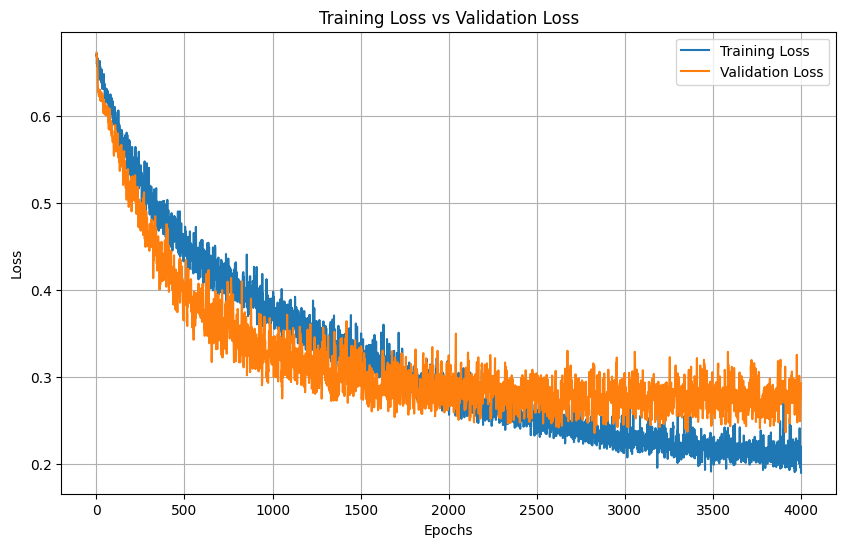

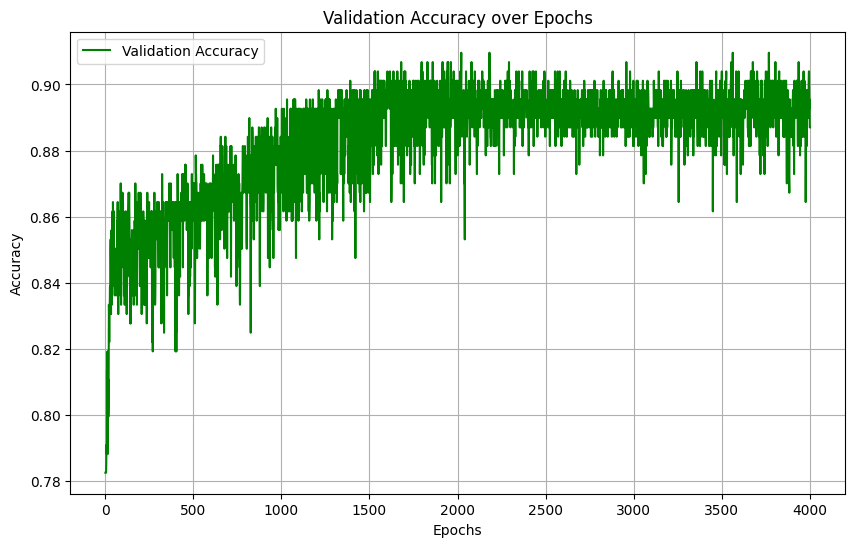

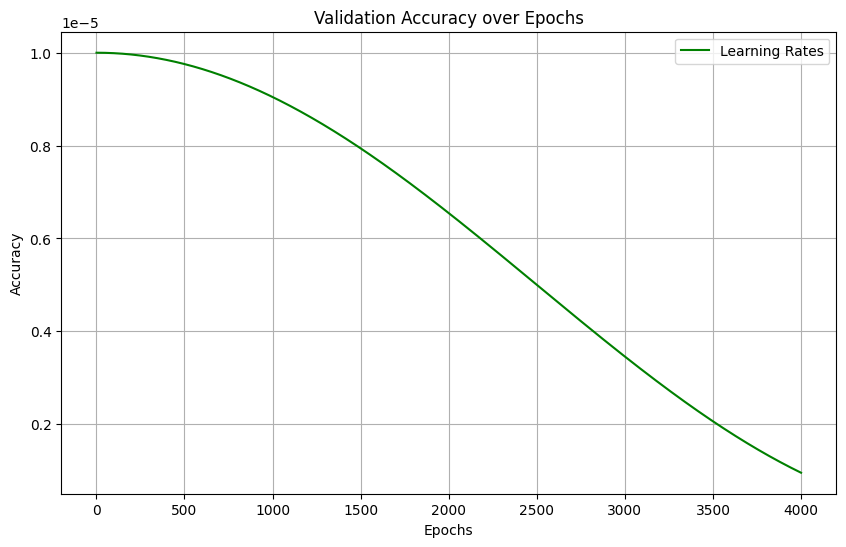

Model for bin 29 saved to GCNModels-5A_exp4/model_bin_29.pth
Training on bin 30/50
Bin 30, Epoch 1/4000, Train Loss: 0.7208, Validation Loss: 0.7065,  Accuracy: 0.2175, LR: 0.000010
Bin 30, Epoch 101/4000, Train Loss: 0.6283, Validation Loss: 0.6479,  Accuracy: 0.7712, LR: 0.000010
Bin 30, Epoch 201/4000, Train Loss: 0.5688, Validation Loss: 0.5842,  Accuracy: 0.7966, LR: 0.000010
Bin 30, Epoch 301/4000, Train Loss: 0.5203, Validation Loss: 0.5087,  Accuracy: 0.8362, LR: 0.000010
Bin 30, Epoch 401/4000, Train Loss: 0.4832, Validation Loss: 0.4492,  Accuracy: 0.8503, LR: 0.000010
Bin 30, Epoch 501/4000, Train Loss: 0.4579, Validation Loss: 0.4093,  Accuracy: 0.8588, LR: 0.000010
Bin 30, Epoch 601/4000, Train Loss: 0.4331, Validation Loss: 0.3874,  Accuracy: 0.8729, LR: 0.000010
Bin 30, Epoch 701/4000, Train Loss: 0.4144, Validation Loss: 0.3395,  Accuracy: 0.8842, LR: 0.000010
Bin 30, Epoch 801/4000, Train Loss: 0.3855, Validation Loss: 0.3337,  Accuracy: 0.8842, LR: 0.000009
Bin 30, Ep

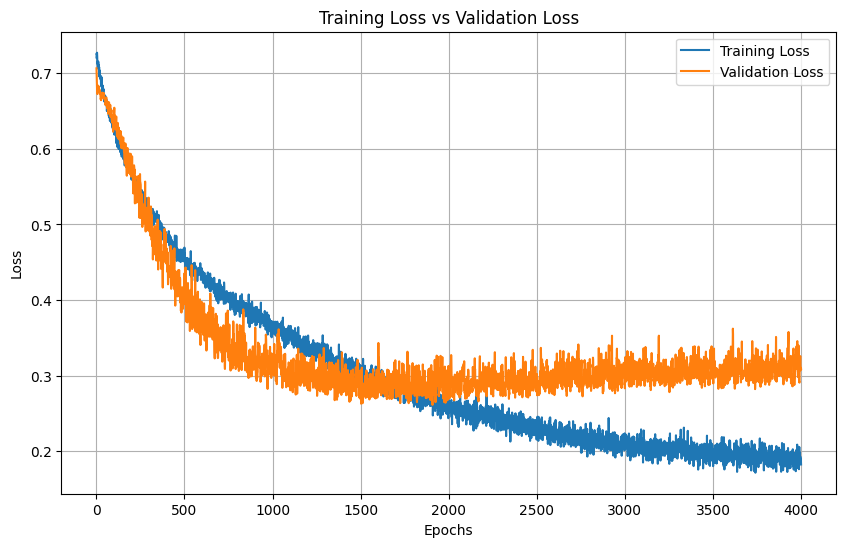

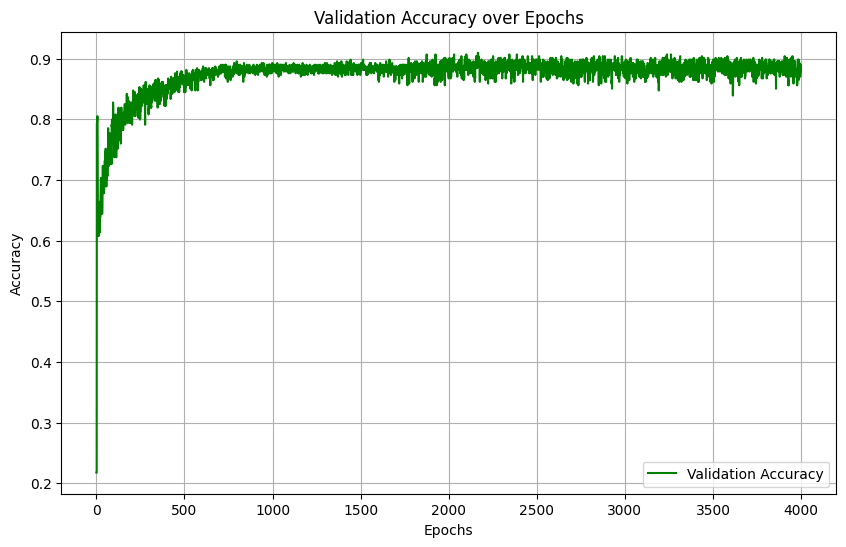

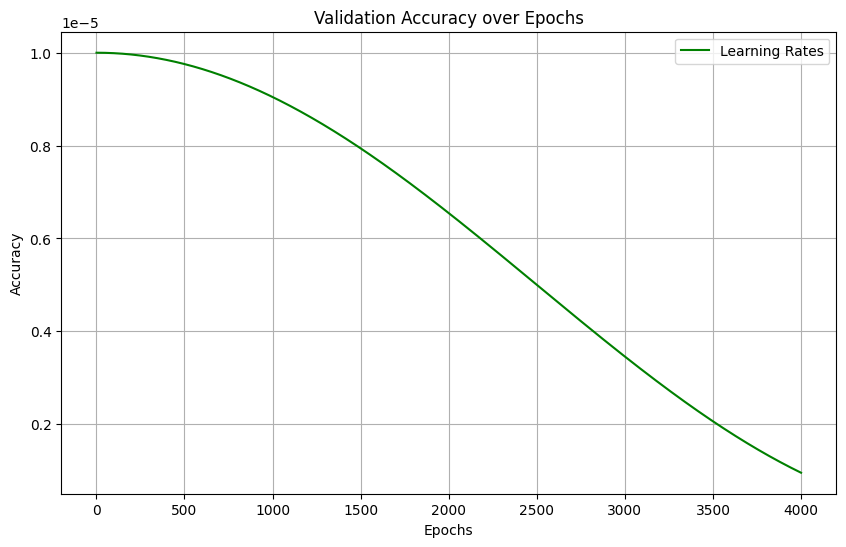

Model for bin 30 saved to GCNModels-5A_exp4/model_bin_30.pth
Training on bin 31/50
Bin 31, Epoch 1/4000, Train Loss: 0.6902, Validation Loss: 0.6872,  Accuracy: 0.7825, LR: 0.000010
Bin 31, Epoch 101/4000, Train Loss: 0.6272, Validation Loss: 0.6032,  Accuracy: 0.8079, LR: 0.000010
Bin 31, Epoch 201/4000, Train Loss: 0.5723, Validation Loss: 0.5403,  Accuracy: 0.8362, LR: 0.000010
Bin 31, Epoch 301/4000, Train Loss: 0.5004, Validation Loss: 0.4807,  Accuracy: 0.8390, LR: 0.000010
Bin 31, Epoch 401/4000, Train Loss: 0.4748, Validation Loss: 0.4204,  Accuracy: 0.8390, LR: 0.000010
Bin 31, Epoch 501/4000, Train Loss: 0.4312, Validation Loss: 0.3814,  Accuracy: 0.8531, LR: 0.000010
Bin 31, Epoch 601/4000, Train Loss: 0.4259, Validation Loss: 0.3760,  Accuracy: 0.8588, LR: 0.000010
Bin 31, Epoch 701/4000, Train Loss: 0.4004, Validation Loss: 0.3221,  Accuracy: 0.8757, LR: 0.000010
Bin 31, Epoch 801/4000, Train Loss: 0.3636, Validation Loss: 0.3252,  Accuracy: 0.8729, LR: 0.000009
Bin 31, Ep

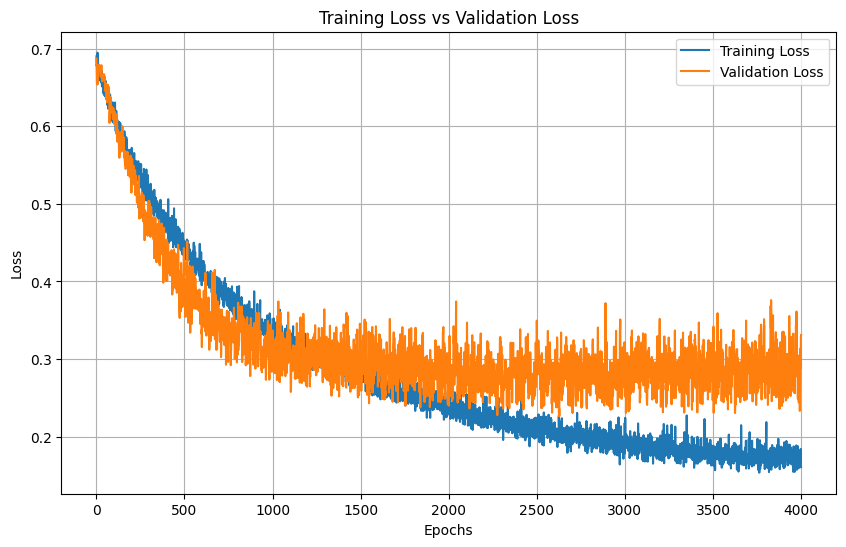

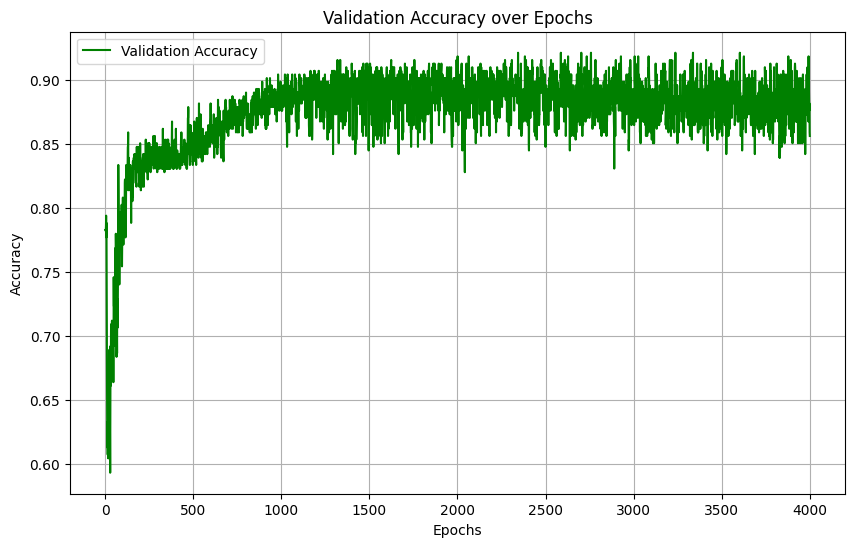

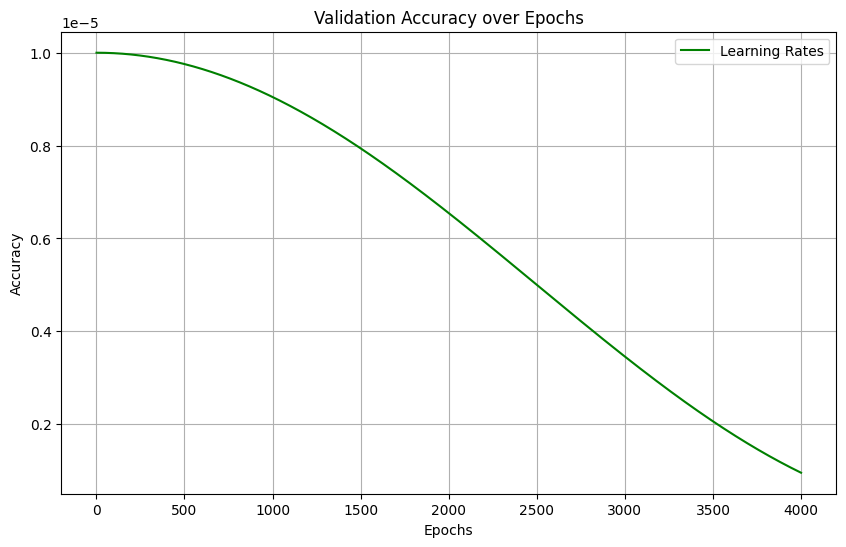

Model for bin 31 saved to GCNModels-5A_exp4/model_bin_31.pth
Training on bin 32/50
Bin 32, Epoch 1/4000, Train Loss: 0.7345, Validation Loss: 0.7160,  Accuracy: 0.2175, LR: 0.000010
Bin 32, Epoch 101/4000, Train Loss: 0.6359, Validation Loss: 0.6518,  Accuracy: 0.7034, LR: 0.000010
Bin 32, Epoch 201/4000, Train Loss: 0.5803, Validation Loss: 0.5920,  Accuracy: 0.8023, LR: 0.000010
Bin 32, Epoch 301/4000, Train Loss: 0.5053, Validation Loss: 0.4845,  Accuracy: 0.8644, LR: 0.000010
Bin 32, Epoch 401/4000, Train Loss: 0.4668, Validation Loss: 0.4272,  Accuracy: 0.8616, LR: 0.000010
Bin 32, Epoch 501/4000, Train Loss: 0.4318, Validation Loss: 0.3702,  Accuracy: 0.8701, LR: 0.000010
Bin 32, Epoch 601/4000, Train Loss: 0.4090, Validation Loss: 0.3508,  Accuracy: 0.8588, LR: 0.000010
Bin 32, Epoch 701/4000, Train Loss: 0.4029, Validation Loss: 0.3524,  Accuracy: 0.8644, LR: 0.000010
Bin 32, Epoch 801/4000, Train Loss: 0.3834, Validation Loss: 0.3316,  Accuracy: 0.8701, LR: 0.000009
Bin 32, Ep

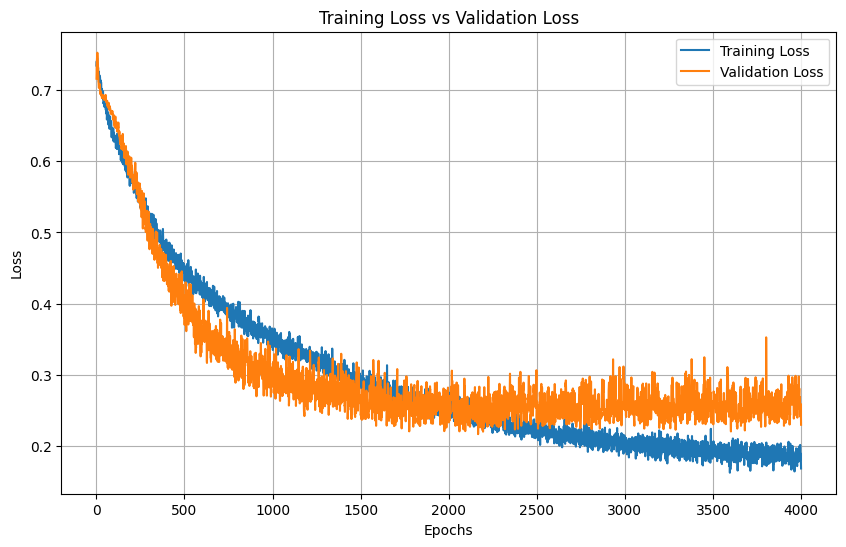

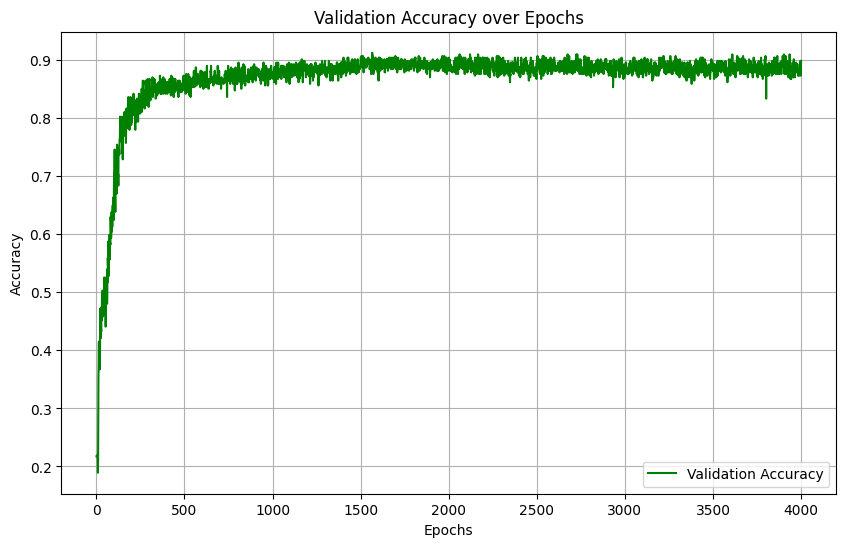

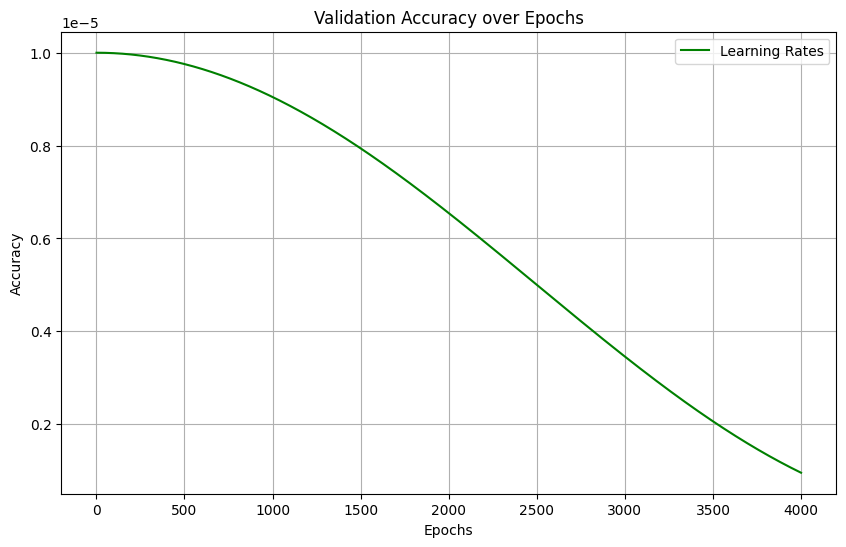

Model for bin 32 saved to GCNModels-5A_exp4/model_bin_32.pth
Training on bin 33/50
Bin 33, Epoch 1/4000, Train Loss: 0.7159, Validation Loss: 0.7310,  Accuracy: 0.2175, LR: 0.000010
Bin 33, Epoch 101/4000, Train Loss: 0.6377, Validation Loss: 0.6658,  Accuracy: 0.6412, LR: 0.000010
Bin 33, Epoch 201/4000, Train Loss: 0.5917, Validation Loss: 0.5978,  Accuracy: 0.7542, LR: 0.000010
Bin 33, Epoch 301/4000, Train Loss: 0.5367, Validation Loss: 0.5258,  Accuracy: 0.8192, LR: 0.000010
Bin 33, Epoch 401/4000, Train Loss: 0.5031, Validation Loss: 0.4551,  Accuracy: 0.8418, LR: 0.000010
Bin 33, Epoch 501/4000, Train Loss: 0.4766, Validation Loss: 0.4154,  Accuracy: 0.8475, LR: 0.000010
Bin 33, Epoch 601/4000, Train Loss: 0.4645, Validation Loss: 0.4372,  Accuracy: 0.8446, LR: 0.000010
Bin 33, Epoch 701/4000, Train Loss: 0.4459, Validation Loss: 0.4051,  Accuracy: 0.8446, LR: 0.000010
Bin 33, Epoch 801/4000, Train Loss: 0.4265, Validation Loss: 0.3827,  Accuracy: 0.8475, LR: 0.000009
Bin 33, Ep

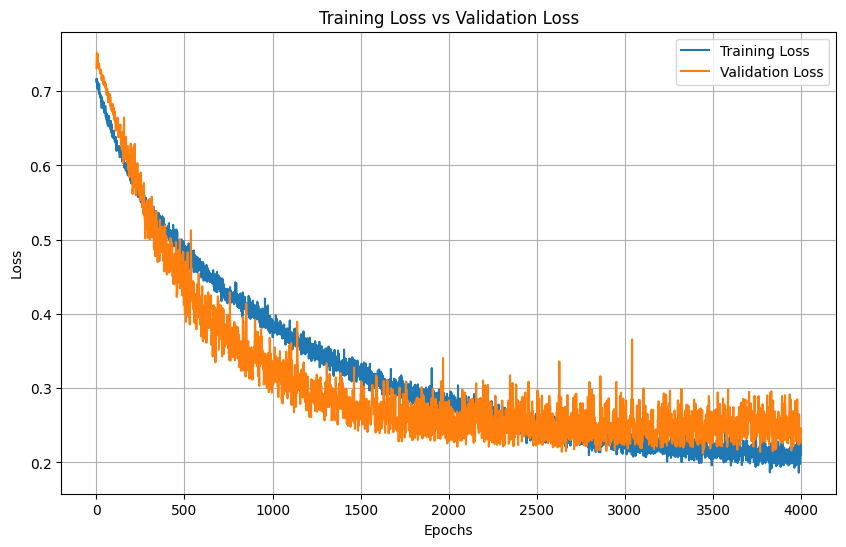

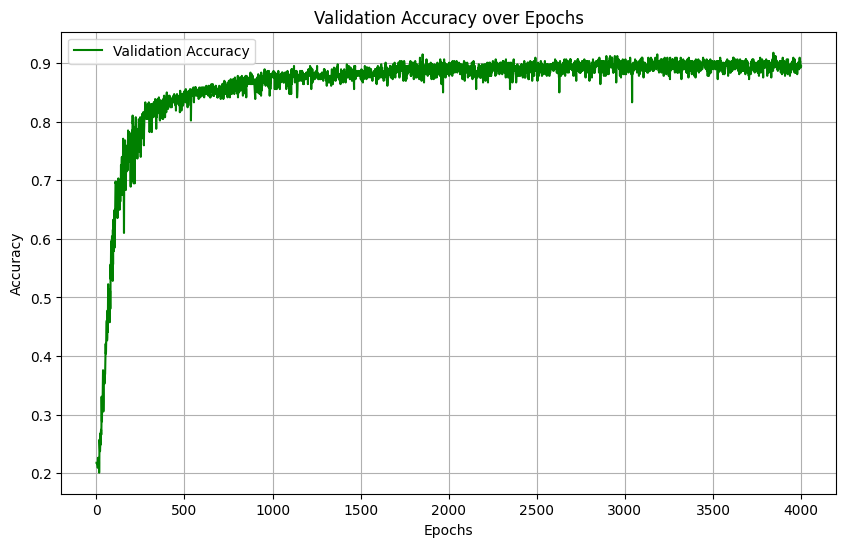

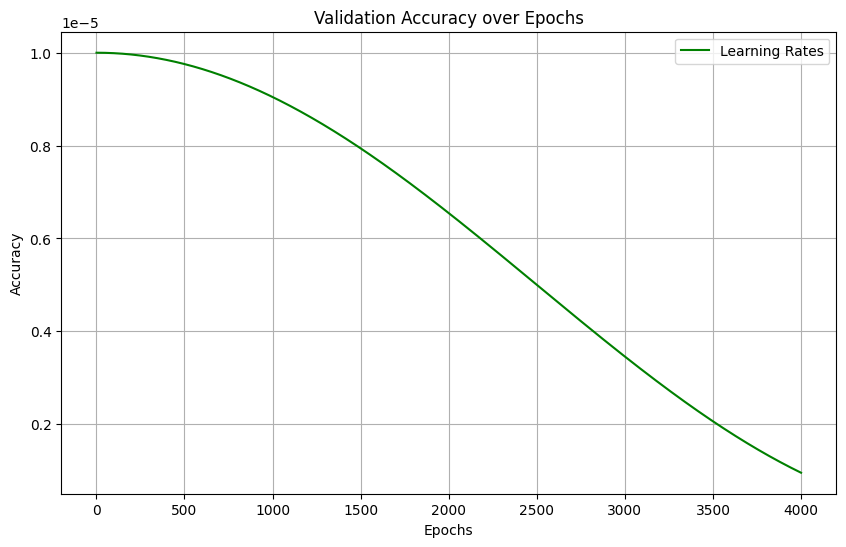

Model for bin 33 saved to GCNModels-5A_exp4/model_bin_33.pth
Training on bin 34/50
Bin 34, Epoch 1/4000, Train Loss: 0.7134, Validation Loss: 0.6828,  Accuracy: 0.7825, LR: 0.000010
Bin 34, Epoch 101/4000, Train Loss: 0.6133, Validation Loss: 0.6109,  Accuracy: 0.8362, LR: 0.000010
Bin 34, Epoch 201/4000, Train Loss: 0.5621, Validation Loss: 0.5159,  Accuracy: 0.8559, LR: 0.000010
Bin 34, Epoch 301/4000, Train Loss: 0.5139, Validation Loss: 0.4488,  Accuracy: 0.8559, LR: 0.000010
Bin 34, Epoch 401/4000, Train Loss: 0.4757, Validation Loss: 0.3937,  Accuracy: 0.8672, LR: 0.000010
Bin 34, Epoch 501/4000, Train Loss: 0.4486, Validation Loss: 0.3520,  Accuracy: 0.8757, LR: 0.000010
Bin 34, Epoch 601/4000, Train Loss: 0.4417, Validation Loss: 0.3486,  Accuracy: 0.8785, LR: 0.000010
Bin 34, Epoch 701/4000, Train Loss: 0.4159, Validation Loss: 0.3255,  Accuracy: 0.8842, LR: 0.000010
Bin 34, Epoch 801/4000, Train Loss: 0.3972, Validation Loss: 0.3057,  Accuracy: 0.8814, LR: 0.000009
Bin 34, Ep

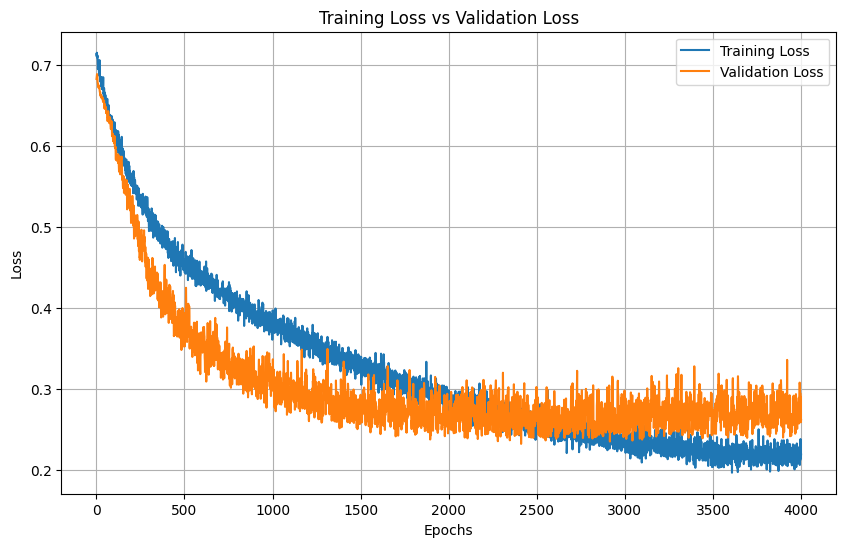

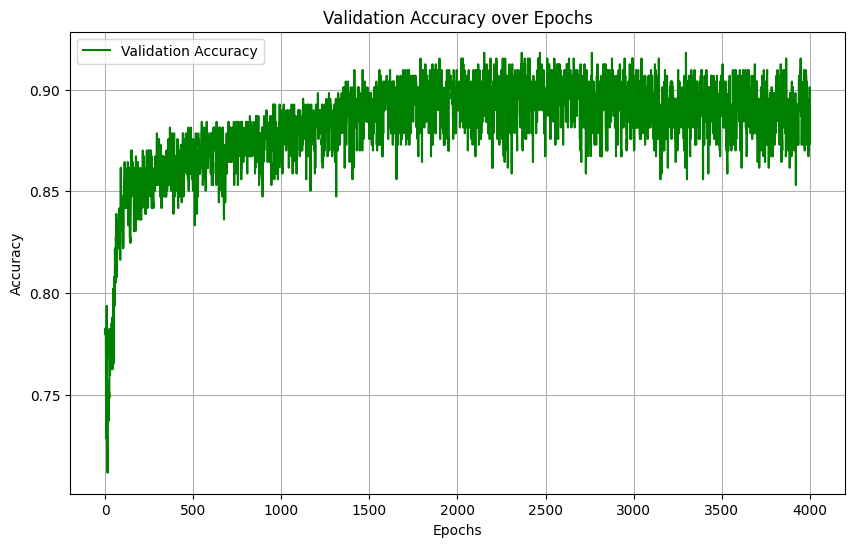

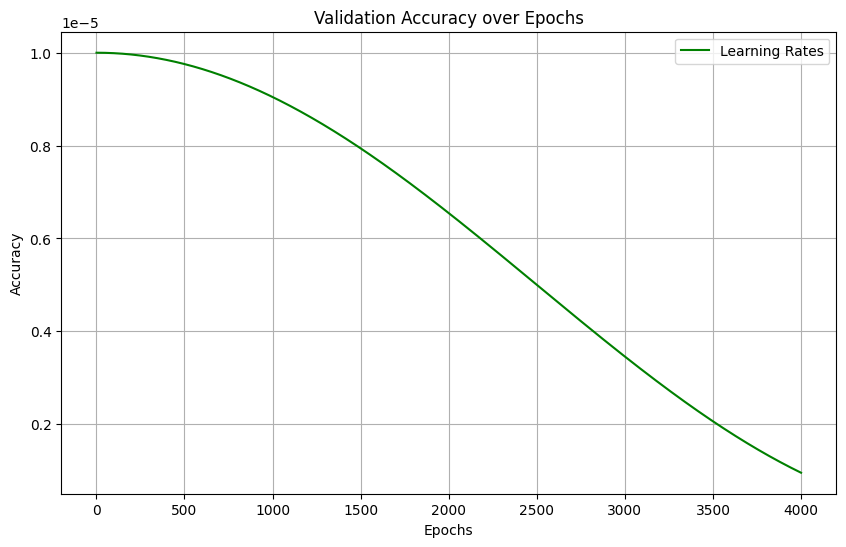

Model for bin 34 saved to GCNModels-5A_exp4/model_bin_34.pth
Training on bin 35/50
Bin 35, Epoch 1/4000, Train Loss: 0.7106, Validation Loss: 0.7057,  Accuracy: 0.2175, LR: 0.000010
Bin 35, Epoch 101/4000, Train Loss: 0.6102, Validation Loss: 0.6277,  Accuracy: 0.7655, LR: 0.000010
Bin 35, Epoch 201/4000, Train Loss: 0.5480, Validation Loss: 0.6001,  Accuracy: 0.7514, LR: 0.000010
Bin 35, Epoch 301/4000, Train Loss: 0.4897, Validation Loss: 0.5145,  Accuracy: 0.8051, LR: 0.000010
Bin 35, Epoch 401/4000, Train Loss: 0.4564, Validation Loss: 0.4393,  Accuracy: 0.8305, LR: 0.000010
Bin 35, Epoch 501/4000, Train Loss: 0.4138, Validation Loss: 0.4312,  Accuracy: 0.8220, LR: 0.000010
Bin 35, Epoch 601/4000, Train Loss: 0.3952, Validation Loss: 0.3744,  Accuracy: 0.8644, LR: 0.000010
Bin 35, Epoch 701/4000, Train Loss: 0.3759, Validation Loss: 0.3389,  Accuracy: 0.8729, LR: 0.000010
Bin 35, Epoch 801/4000, Train Loss: 0.3495, Validation Loss: 0.3559,  Accuracy: 0.8644, LR: 0.000009
Bin 35, Ep

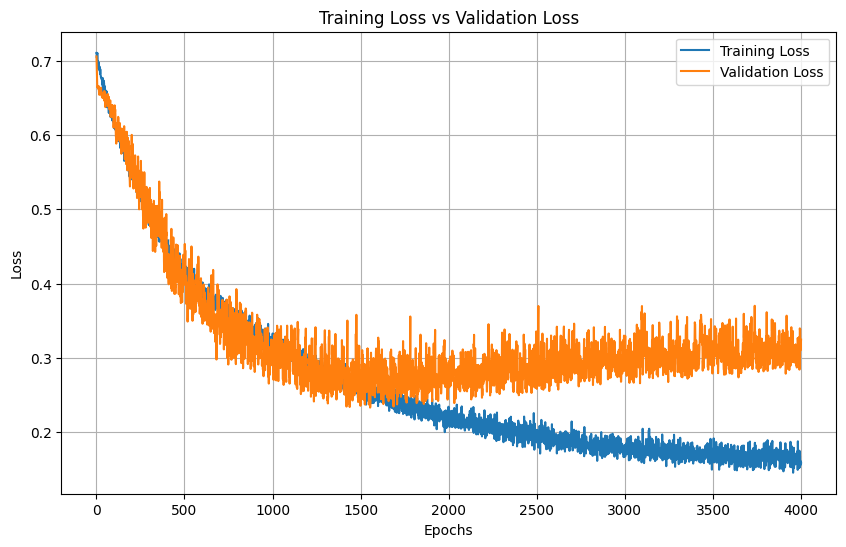

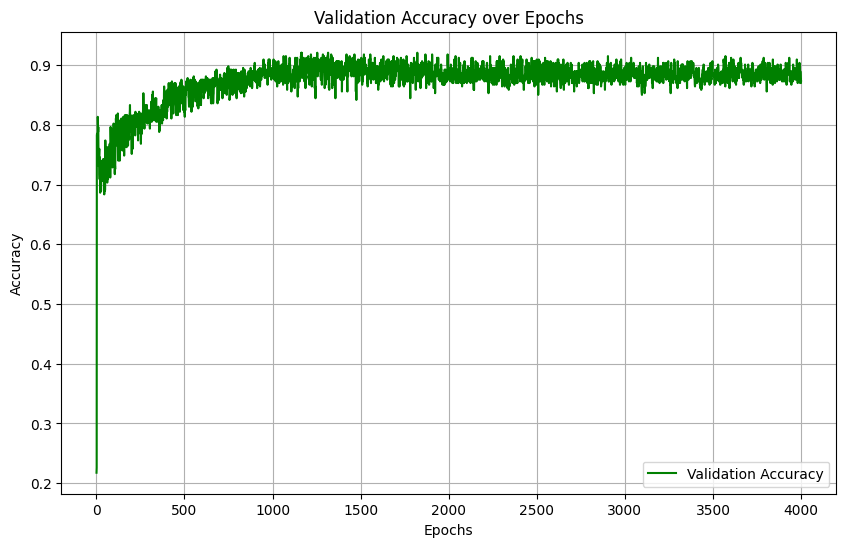

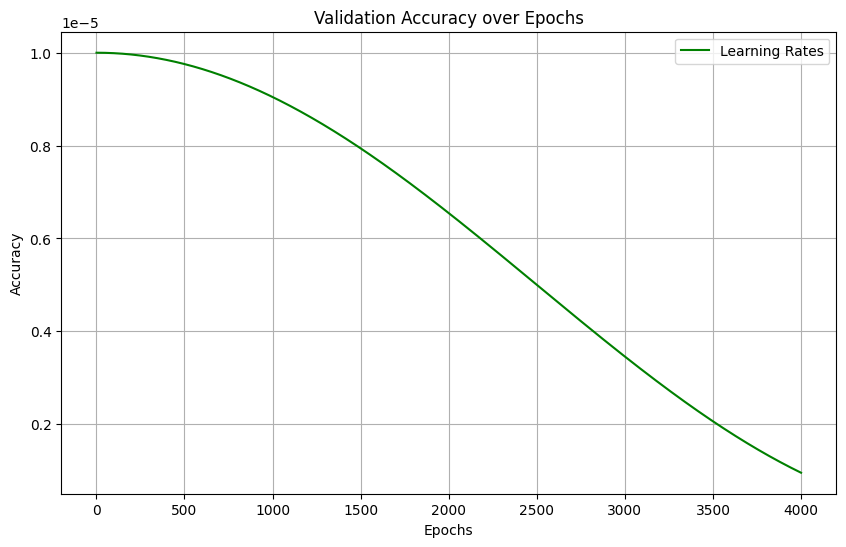

Model for bin 35 saved to GCNModels-5A_exp4/model_bin_35.pth
Training on bin 36/50
Bin 36, Epoch 1/4000, Train Loss: 0.7165, Validation Loss: 0.6613,  Accuracy: 0.7825, LR: 0.000010
Bin 36, Epoch 101/4000, Train Loss: 0.6278, Validation Loss: 0.6098,  Accuracy: 0.8164, LR: 0.000010
Bin 36, Epoch 201/4000, Train Loss: 0.5871, Validation Loss: 0.5330,  Accuracy: 0.8192, LR: 0.000010
Bin 36, Epoch 301/4000, Train Loss: 0.5401, Validation Loss: 0.4849,  Accuracy: 0.8277, LR: 0.000010
Bin 36, Epoch 401/4000, Train Loss: 0.4938, Validation Loss: 0.4402,  Accuracy: 0.8362, LR: 0.000010
Bin 36, Epoch 501/4000, Train Loss: 0.4598, Validation Loss: 0.4046,  Accuracy: 0.8446, LR: 0.000010
Bin 36, Epoch 601/4000, Train Loss: 0.4423, Validation Loss: 0.3646,  Accuracy: 0.8588, LR: 0.000010
Bin 36, Epoch 701/4000, Train Loss: 0.4235, Validation Loss: 0.3380,  Accuracy: 0.8588, LR: 0.000010
Bin 36, Epoch 801/4000, Train Loss: 0.3769, Validation Loss: 0.3385,  Accuracy: 0.8672, LR: 0.000009
Bin 36, Ep

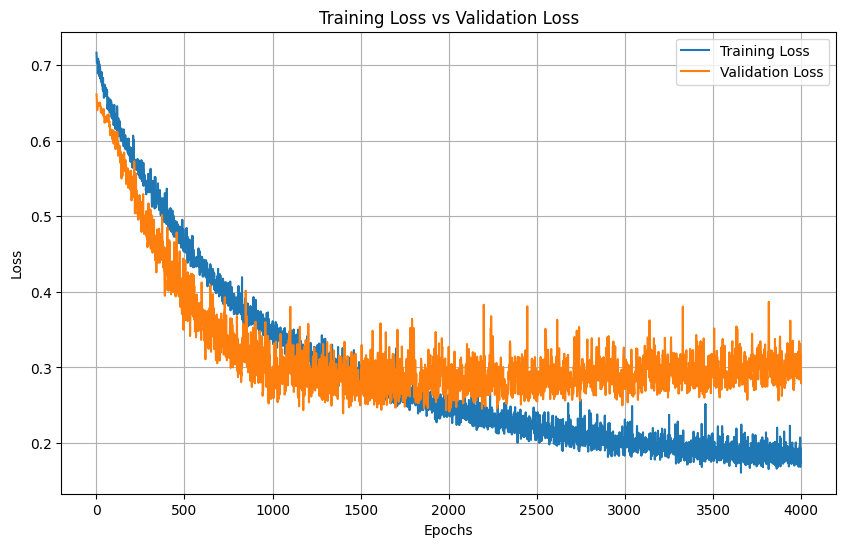

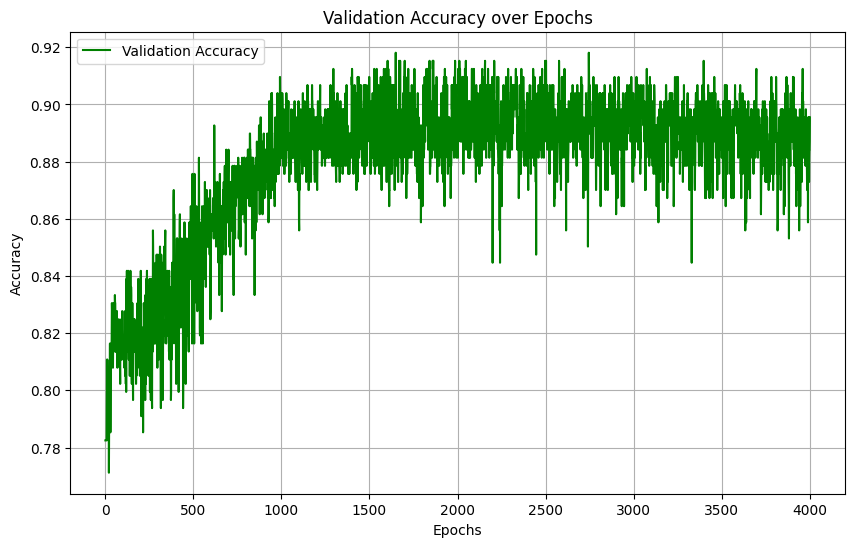

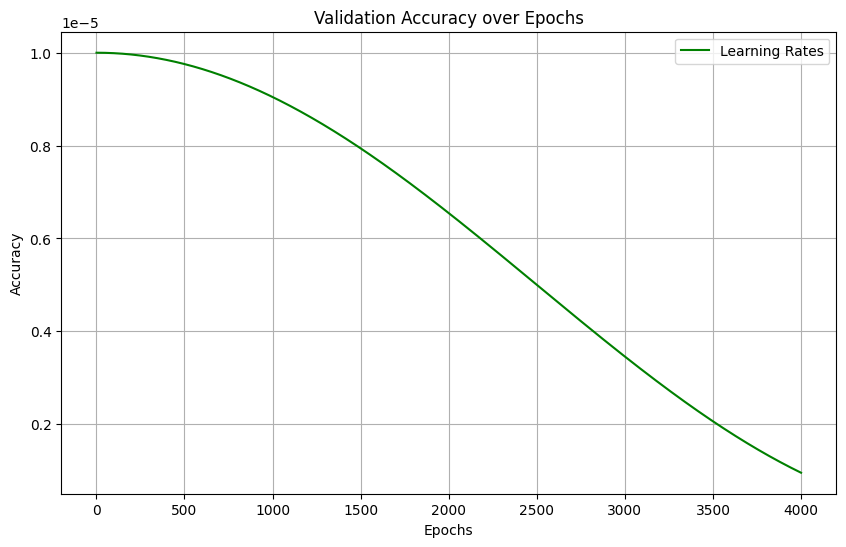

Model for bin 36 saved to GCNModels-5A_exp4/model_bin_36.pth
Training on bin 37/50
Bin 37, Epoch 1/4000, Train Loss: 0.7077, Validation Loss: 0.6855,  Accuracy: 0.7825, LR: 0.000010
Bin 37, Epoch 101/4000, Train Loss: 0.6354, Validation Loss: 0.6437,  Accuracy: 0.7797, LR: 0.000010
Bin 37, Epoch 201/4000, Train Loss: 0.5809, Validation Loss: 0.5591,  Accuracy: 0.8672, LR: 0.000010
Bin 37, Epoch 301/4000, Train Loss: 0.5034, Validation Loss: 0.5001,  Accuracy: 0.8729, LR: 0.000010
Bin 37, Epoch 401/4000, Train Loss: 0.4545, Validation Loss: 0.4382,  Accuracy: 0.8785, LR: 0.000010
Bin 37, Epoch 501/4000, Train Loss: 0.4183, Validation Loss: 0.3963,  Accuracy: 0.8814, LR: 0.000010
Bin 37, Epoch 601/4000, Train Loss: 0.3989, Validation Loss: 0.3699,  Accuracy: 0.8814, LR: 0.000010
Bin 37, Epoch 701/4000, Train Loss: 0.3813, Validation Loss: 0.3098,  Accuracy: 0.8842, LR: 0.000010
Bin 37, Epoch 801/4000, Train Loss: 0.3362, Validation Loss: 0.3070,  Accuracy: 0.8898, LR: 0.000009
Bin 37, Ep

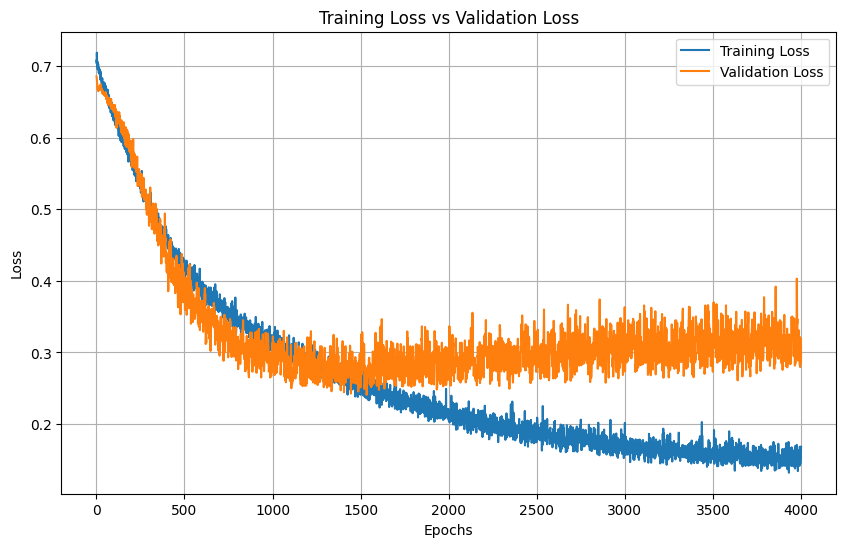

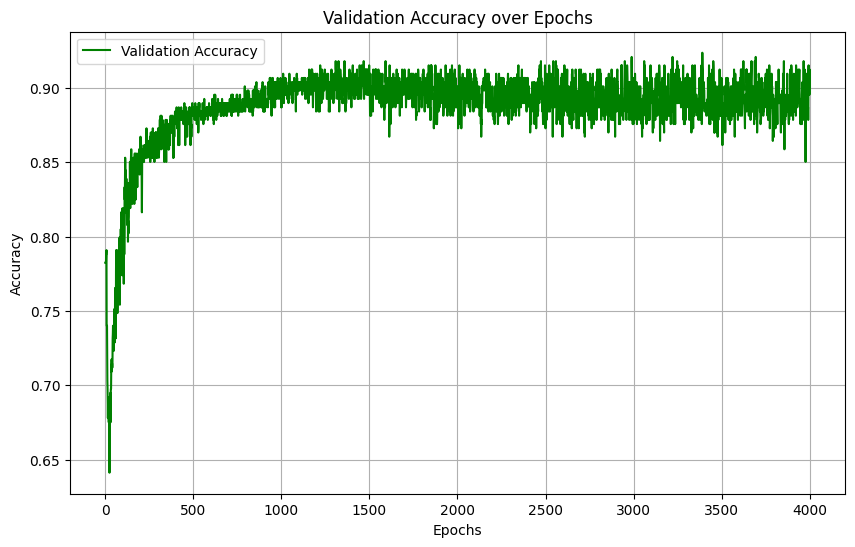

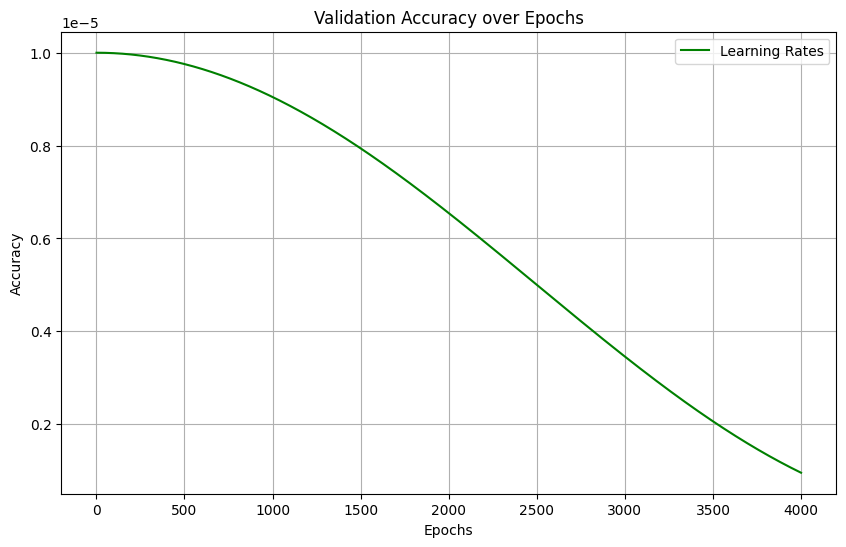

Model for bin 37 saved to GCNModels-5A_exp4/model_bin_37.pth
Training on bin 38/50
Bin 38, Epoch 1/4000, Train Loss: 0.6987, Validation Loss: 0.6777,  Accuracy: 0.7825, LR: 0.000010
Bin 38, Epoch 101/4000, Train Loss: 0.6259, Validation Loss: 0.6303,  Accuracy: 0.8249, LR: 0.000010
Bin 38, Epoch 201/4000, Train Loss: 0.5639, Validation Loss: 0.5700,  Accuracy: 0.8305, LR: 0.000010
Bin 38, Epoch 301/4000, Train Loss: 0.5067, Validation Loss: 0.5028,  Accuracy: 0.8418, LR: 0.000010
Bin 38, Epoch 401/4000, Train Loss: 0.4700, Validation Loss: 0.4412,  Accuracy: 0.8588, LR: 0.000010
Bin 38, Epoch 501/4000, Train Loss: 0.4462, Validation Loss: 0.3968,  Accuracy: 0.8616, LR: 0.000010
Bin 38, Epoch 601/4000, Train Loss: 0.4190, Validation Loss: 0.3970,  Accuracy: 0.8616, LR: 0.000010
Bin 38, Epoch 701/4000, Train Loss: 0.3991, Validation Loss: 0.3534,  Accuracy: 0.8785, LR: 0.000010
Bin 38, Epoch 801/4000, Train Loss: 0.3925, Validation Loss: 0.3320,  Accuracy: 0.8757, LR: 0.000009
Bin 38, Ep

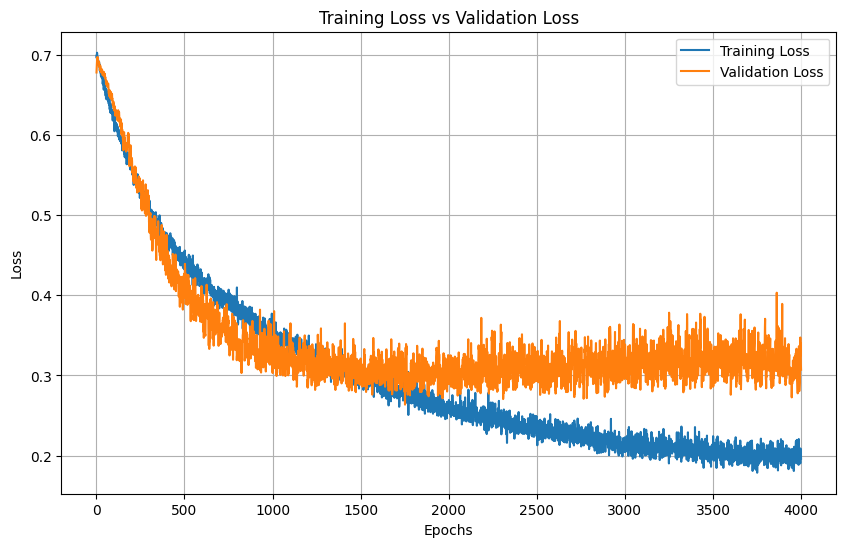

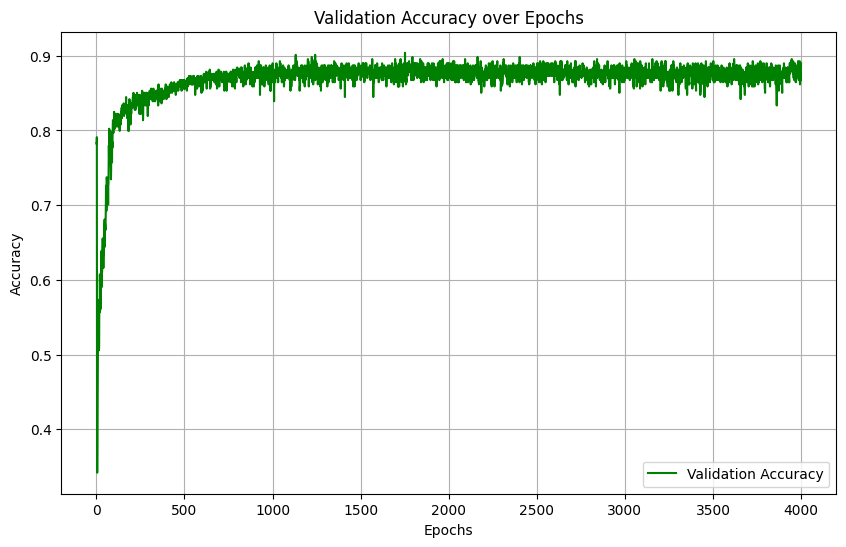

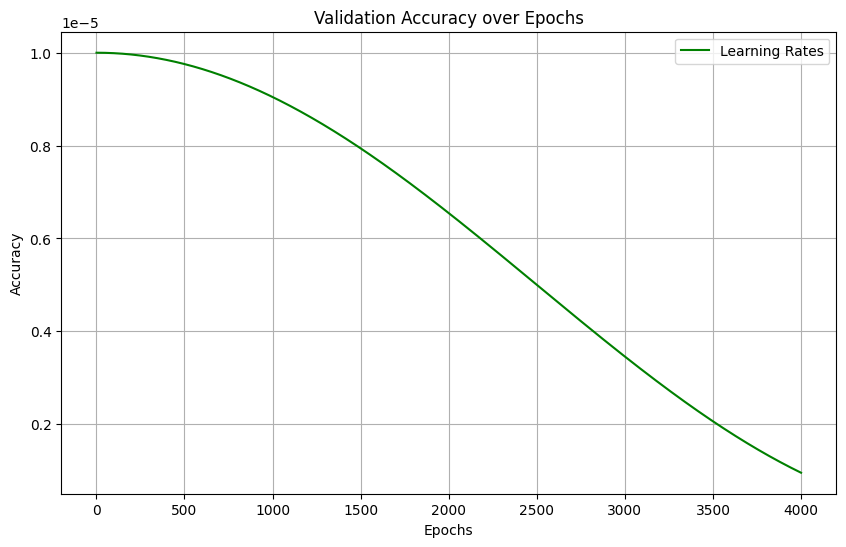

Model for bin 38 saved to GCNModels-5A_exp4/model_bin_38.pth
Training on bin 39/50
Bin 39, Epoch 1/4000, Train Loss: 0.6970, Validation Loss: 0.6853,  Accuracy: 0.7825, LR: 0.000010
Bin 39, Epoch 101/4000, Train Loss: 0.6208, Validation Loss: 0.6758,  Accuracy: 0.6243, LR: 0.000010
Bin 39, Epoch 201/4000, Train Loss: 0.5681, Validation Loss: 0.5810,  Accuracy: 0.8079, LR: 0.000010
Bin 39, Epoch 301/4000, Train Loss: 0.4924, Validation Loss: 0.5345,  Accuracy: 0.8192, LR: 0.000010
Bin 39, Epoch 401/4000, Train Loss: 0.4705, Validation Loss: 0.4657,  Accuracy: 0.8390, LR: 0.000010
Bin 39, Epoch 501/4000, Train Loss: 0.4271, Validation Loss: 0.4339,  Accuracy: 0.8446, LR: 0.000010
Bin 39, Epoch 601/4000, Train Loss: 0.4006, Validation Loss: 0.3790,  Accuracy: 0.8729, LR: 0.000010
Bin 39, Epoch 701/4000, Train Loss: 0.3778, Validation Loss: 0.3440,  Accuracy: 0.8785, LR: 0.000010
Bin 39, Epoch 801/4000, Train Loss: 0.3604, Validation Loss: 0.3313,  Accuracy: 0.8814, LR: 0.000009
Bin 39, Ep

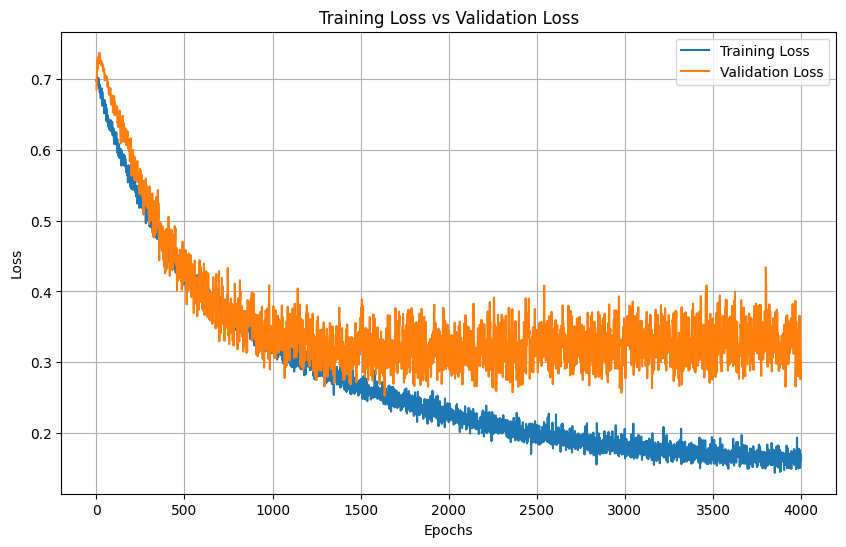

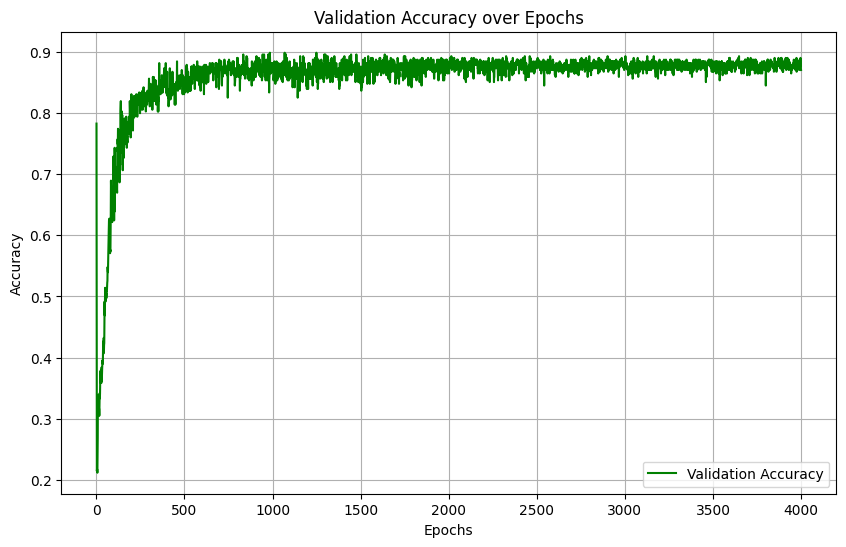

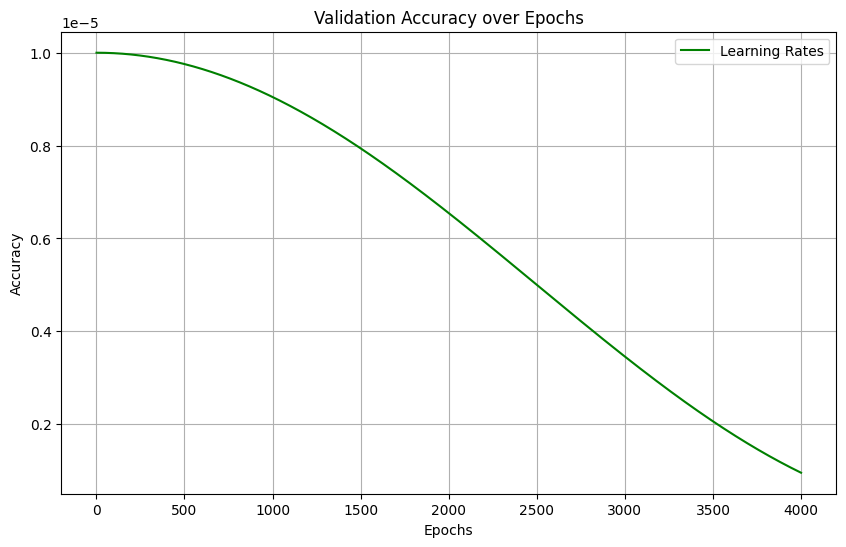

Model for bin 39 saved to GCNModels-5A_exp4/model_bin_39.pth
Training on bin 40/50
Bin 40, Epoch 1/4000, Train Loss: 0.6922, Validation Loss: 0.6779,  Accuracy: 0.7825, LR: 0.000010
Bin 40, Epoch 101/4000, Train Loss: 0.6179, Validation Loss: 0.6265,  Accuracy: 0.7881, LR: 0.000010
Bin 40, Epoch 201/4000, Train Loss: 0.5525, Validation Loss: 0.5529,  Accuracy: 0.8333, LR: 0.000010
Bin 40, Epoch 301/4000, Train Loss: 0.4983, Validation Loss: 0.4707,  Accuracy: 0.8559, LR: 0.000010
Bin 40, Epoch 401/4000, Train Loss: 0.4495, Validation Loss: 0.4147,  Accuracy: 0.8757, LR: 0.000010
Bin 40, Epoch 501/4000, Train Loss: 0.4134, Validation Loss: 0.3501,  Accuracy: 0.8870, LR: 0.000010
Bin 40, Epoch 601/4000, Train Loss: 0.3816, Validation Loss: 0.3104,  Accuracy: 0.8955, LR: 0.000010
Bin 40, Epoch 701/4000, Train Loss: 0.3544, Validation Loss: 0.3193,  Accuracy: 0.8870, LR: 0.000010
Bin 40, Epoch 801/4000, Train Loss: 0.3333, Validation Loss: 0.3136,  Accuracy: 0.8870, LR: 0.000009
Bin 40, Ep

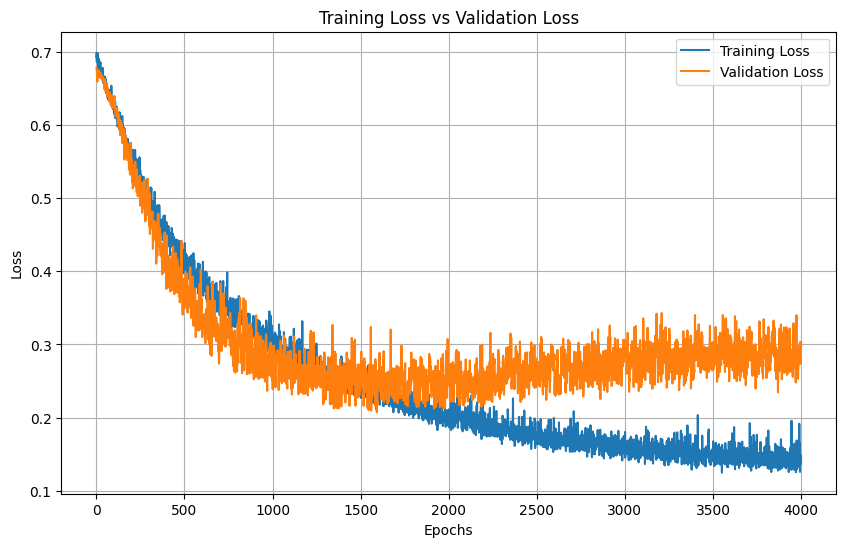

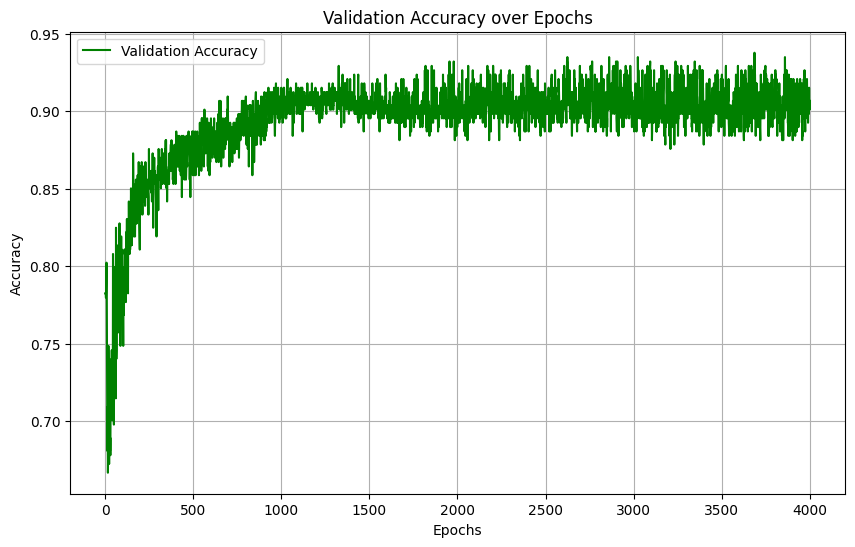

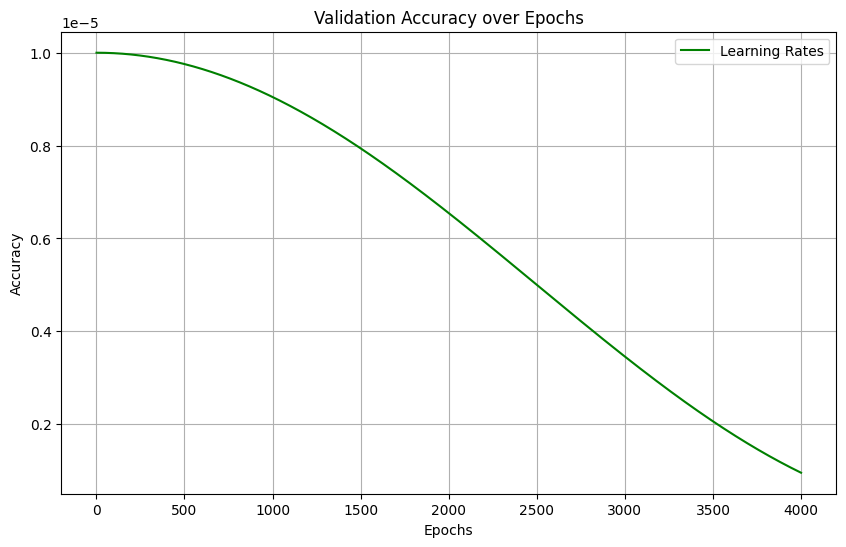

Model for bin 40 saved to GCNModels-5A_exp4/model_bin_40.pth
Training on bin 41/50
Bin 41, Epoch 1/4000, Train Loss: 0.7039, Validation Loss: 0.6866,  Accuracy: 0.7825, LR: 0.000010
Bin 41, Epoch 101/4000, Train Loss: 0.6173, Validation Loss: 0.6110,  Accuracy: 0.7994, LR: 0.000010
Bin 41, Epoch 201/4000, Train Loss: 0.5577, Validation Loss: 0.5592,  Accuracy: 0.7994, LR: 0.000010
Bin 41, Epoch 301/4000, Train Loss: 0.5080, Validation Loss: 0.5100,  Accuracy: 0.8220, LR: 0.000010
Bin 41, Epoch 401/4000, Train Loss: 0.4614, Validation Loss: 0.4264,  Accuracy: 0.8616, LR: 0.000010
Bin 41, Epoch 501/4000, Train Loss: 0.4362, Validation Loss: 0.4078,  Accuracy: 0.8644, LR: 0.000010
Bin 41, Epoch 601/4000, Train Loss: 0.4103, Validation Loss: 0.3957,  Accuracy: 0.8616, LR: 0.000010
Bin 41, Epoch 701/4000, Train Loss: 0.3642, Validation Loss: 0.3656,  Accuracy: 0.8757, LR: 0.000010
Bin 41, Epoch 801/4000, Train Loss: 0.3418, Validation Loss: 0.3448,  Accuracy: 0.8701, LR: 0.000009
Bin 41, Ep

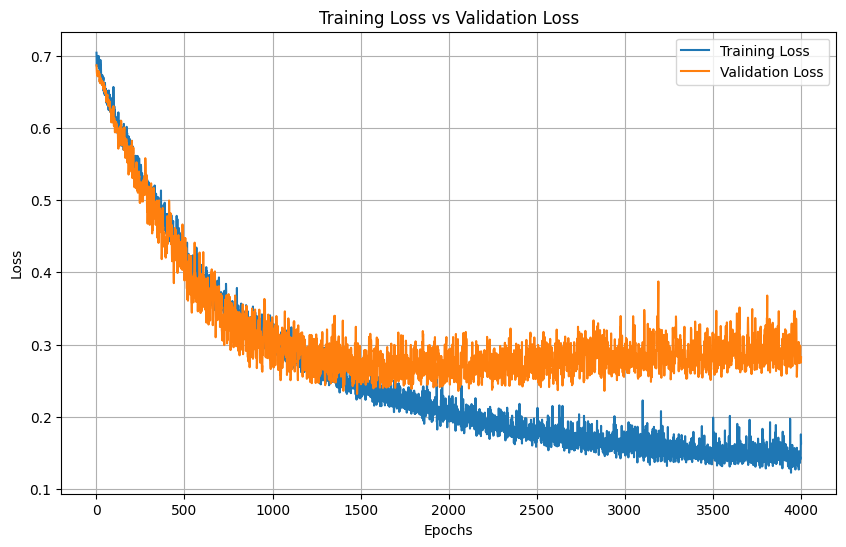

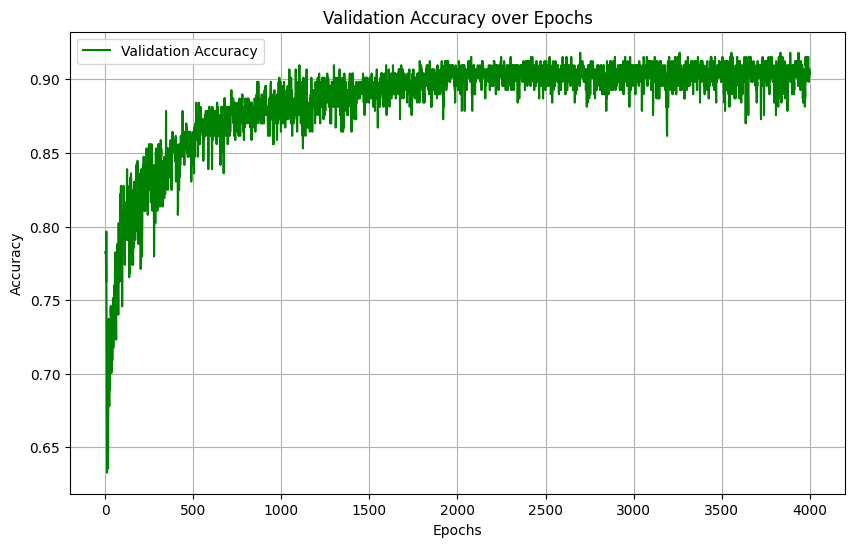

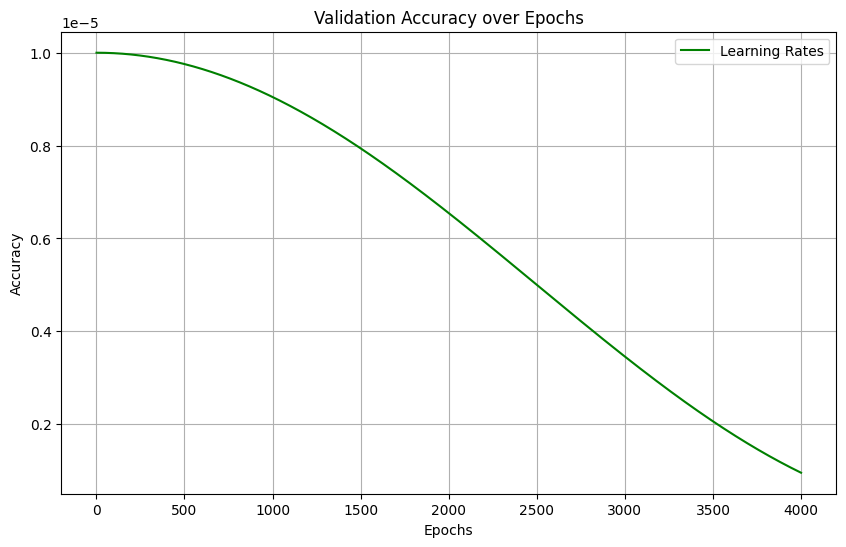

Model for bin 41 saved to GCNModels-5A_exp4/model_bin_41.pth
Training on bin 42/50
Bin 42, Epoch 1/4000, Train Loss: 0.6930, Validation Loss: 0.7158,  Accuracy: 0.2175, LR: 0.000010
Bin 42, Epoch 101/4000, Train Loss: 0.6328, Validation Loss: 0.6256,  Accuracy: 0.8164, LR: 0.000010
Bin 42, Epoch 201/4000, Train Loss: 0.5685, Validation Loss: 0.5638,  Accuracy: 0.8277, LR: 0.000010
Bin 42, Epoch 301/4000, Train Loss: 0.5264, Validation Loss: 0.5061,  Accuracy: 0.8418, LR: 0.000010
Bin 42, Epoch 401/4000, Train Loss: 0.4678, Validation Loss: 0.4537,  Accuracy: 0.8531, LR: 0.000010
Bin 42, Epoch 501/4000, Train Loss: 0.4531, Validation Loss: 0.3962,  Accuracy: 0.8729, LR: 0.000010
Bin 42, Epoch 601/4000, Train Loss: 0.4093, Validation Loss: 0.3582,  Accuracy: 0.8701, LR: 0.000010
Bin 42, Epoch 701/4000, Train Loss: 0.4053, Validation Loss: 0.3207,  Accuracy: 0.8814, LR: 0.000010
Bin 42, Epoch 801/4000, Train Loss: 0.3951, Validation Loss: 0.3486,  Accuracy: 0.8701, LR: 0.000009
Bin 42, Ep

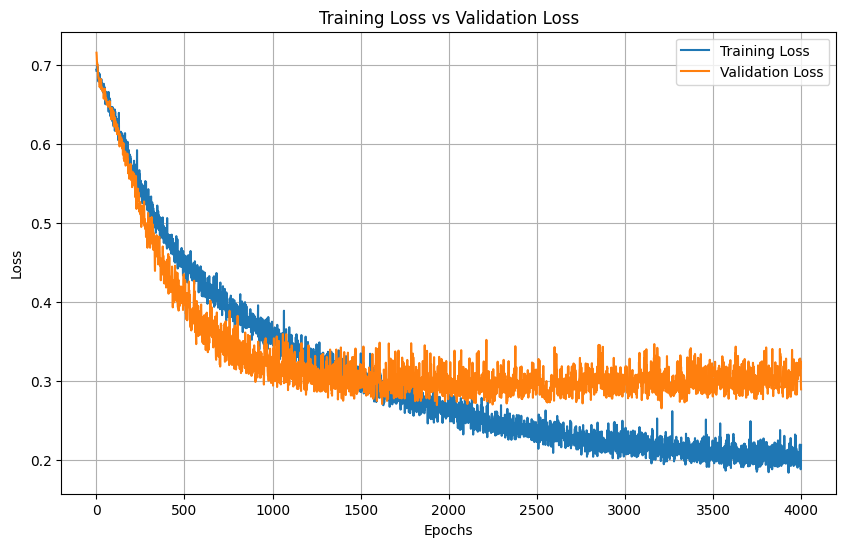

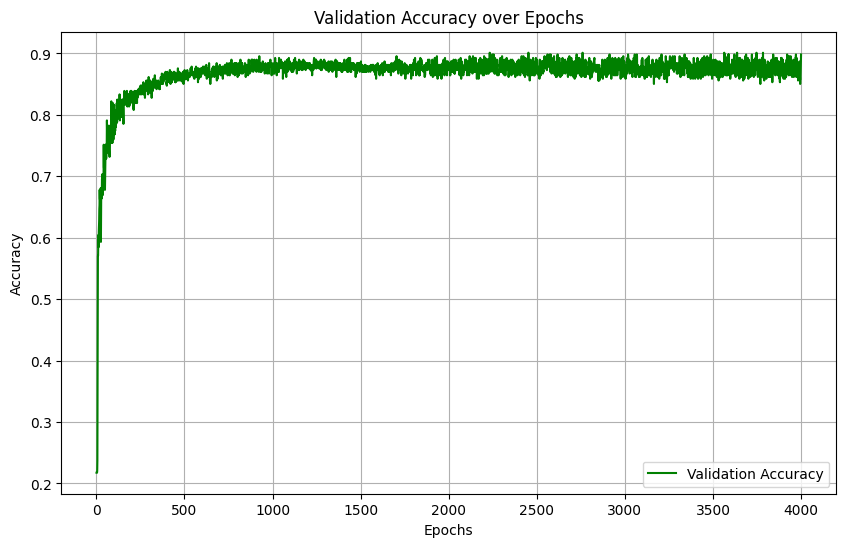

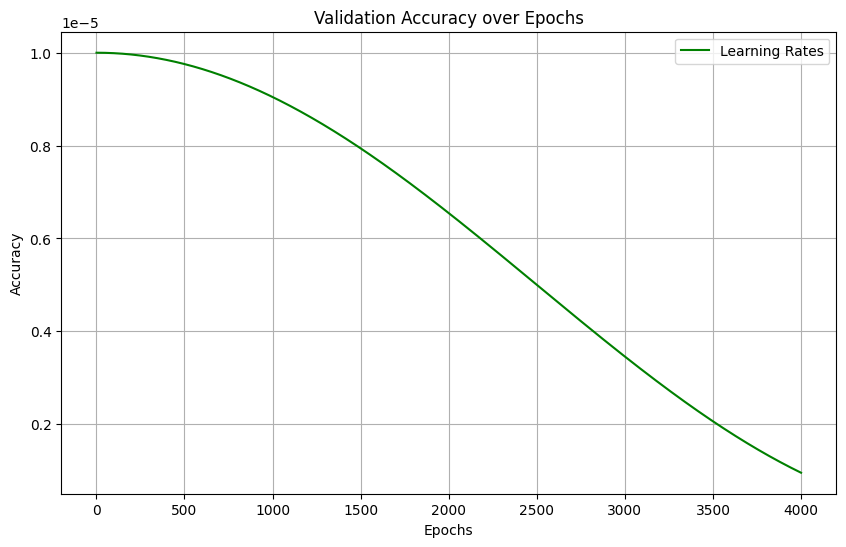

Model for bin 42 saved to GCNModels-5A_exp4/model_bin_42.pth
Training on bin 43/50
Bin 43, Epoch 1/4000, Train Loss: 0.6957, Validation Loss: 0.6799,  Accuracy: 0.7825, LR: 0.000010
Bin 43, Epoch 101/4000, Train Loss: 0.6361, Validation Loss: 0.6291,  Accuracy: 0.7910, LR: 0.000010
Bin 43, Epoch 201/4000, Train Loss: 0.5853, Validation Loss: 0.5742,  Accuracy: 0.8192, LR: 0.000010
Bin 43, Epoch 301/4000, Train Loss: 0.5298, Validation Loss: 0.5347,  Accuracy: 0.8220, LR: 0.000010
Bin 43, Epoch 401/4000, Train Loss: 0.5023, Validation Loss: 0.4742,  Accuracy: 0.8446, LR: 0.000010
Bin 43, Epoch 501/4000, Train Loss: 0.4611, Validation Loss: 0.4401,  Accuracy: 0.8531, LR: 0.000010
Bin 43, Epoch 601/4000, Train Loss: 0.4271, Validation Loss: 0.4042,  Accuracy: 0.8616, LR: 0.000010
Bin 43, Epoch 701/4000, Train Loss: 0.4288, Validation Loss: 0.3727,  Accuracy: 0.8672, LR: 0.000010
Bin 43, Epoch 801/4000, Train Loss: 0.3788, Validation Loss: 0.3569,  Accuracy: 0.8729, LR: 0.000009
Bin 43, Ep

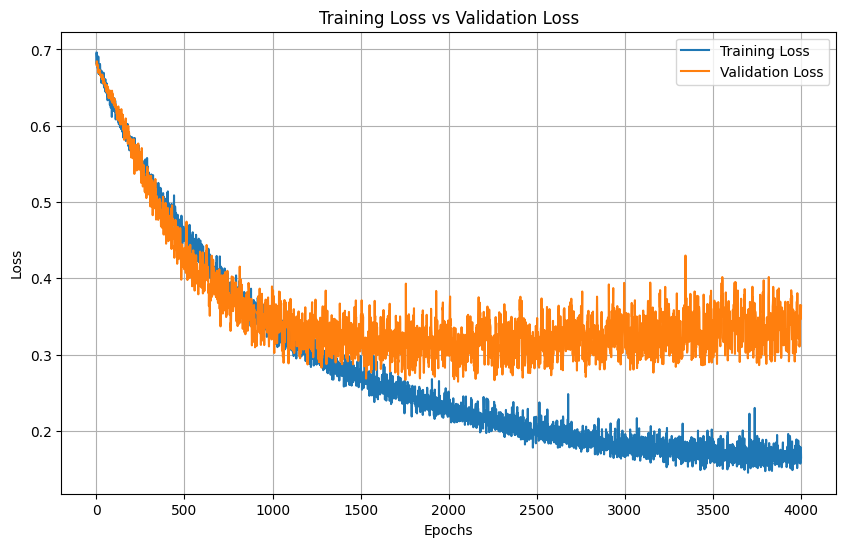

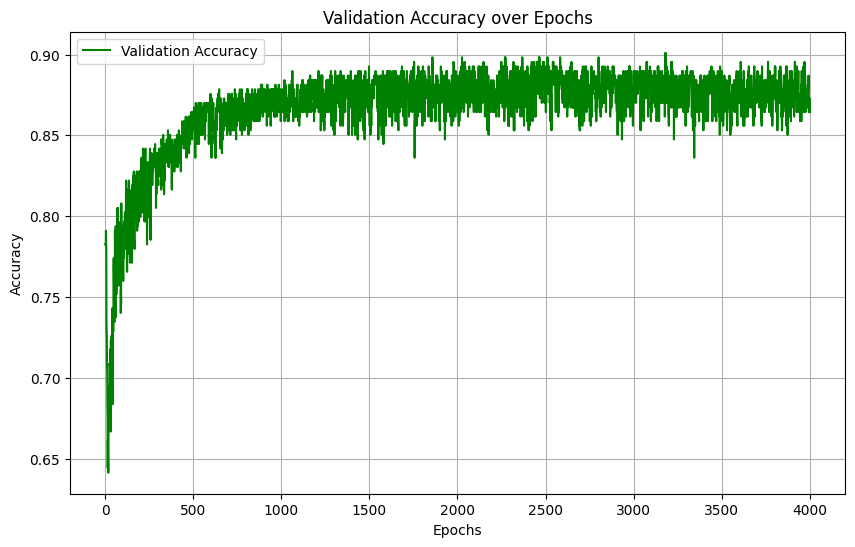

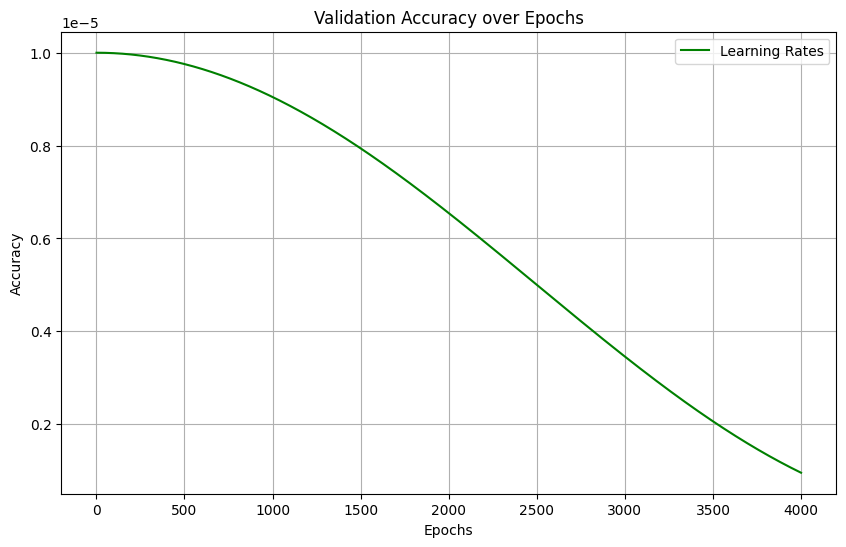

Model for bin 43 saved to GCNModels-5A_exp4/model_bin_43.pth
Training on bin 44/50
Bin 44, Epoch 1/4000, Train Loss: 0.7291, Validation Loss: 0.6713,  Accuracy: 0.7825, LR: 0.000010
Bin 44, Epoch 101/4000, Train Loss: 0.6090, Validation Loss: 0.5937,  Accuracy: 0.8249, LR: 0.000010
Bin 44, Epoch 201/4000, Train Loss: 0.5315, Validation Loss: 0.5265,  Accuracy: 0.8305, LR: 0.000010
Bin 44, Epoch 301/4000, Train Loss: 0.4921, Validation Loss: 0.4413,  Accuracy: 0.8588, LR: 0.000010
Bin 44, Epoch 401/4000, Train Loss: 0.4652, Validation Loss: 0.4337,  Accuracy: 0.8390, LR: 0.000010
Bin 44, Epoch 501/4000, Train Loss: 0.4238, Validation Loss: 0.3721,  Accuracy: 0.8559, LR: 0.000010
Bin 44, Epoch 601/4000, Train Loss: 0.3981, Validation Loss: 0.3795,  Accuracy: 0.8475, LR: 0.000010
Bin 44, Epoch 701/4000, Train Loss: 0.3498, Validation Loss: 0.3867,  Accuracy: 0.8390, LR: 0.000010
Bin 44, Epoch 801/4000, Train Loss: 0.3494, Validation Loss: 0.3259,  Accuracy: 0.8644, LR: 0.000009
Bin 44, Ep

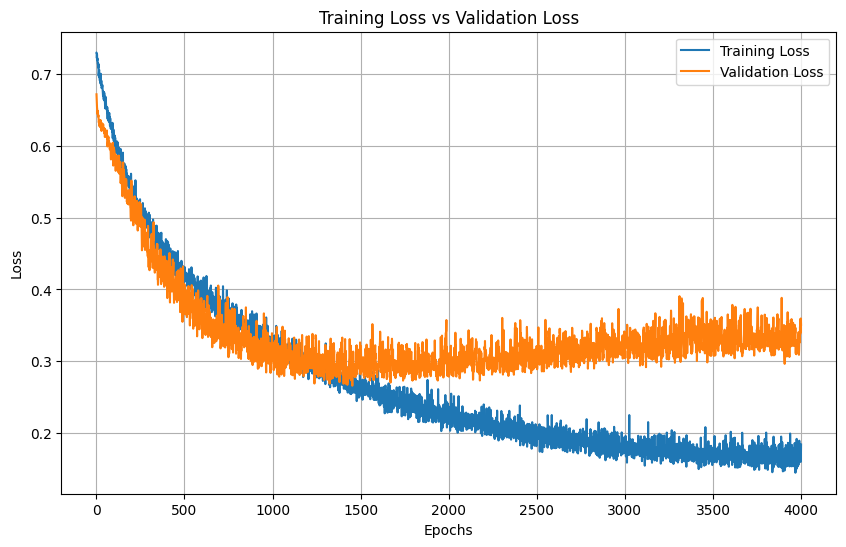

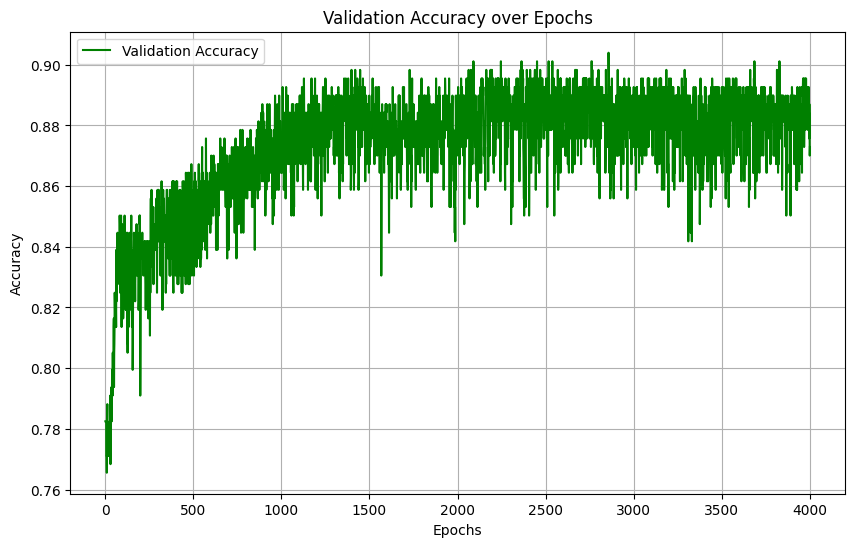

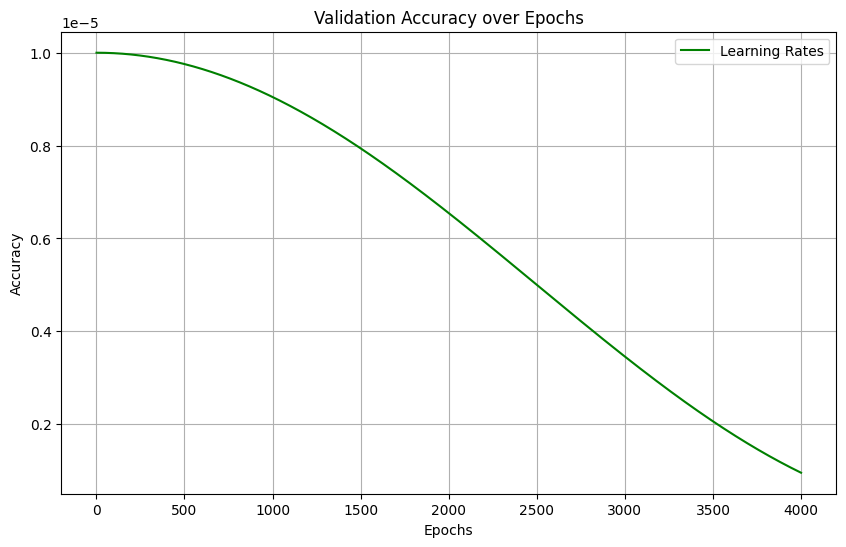

Model for bin 44 saved to GCNModels-5A_exp4/model_bin_44.pth
Training on bin 45/50
Bin 45, Epoch 1/4000, Train Loss: 0.7085, Validation Loss: 0.7065,  Accuracy: 0.2175, LR: 0.000010
Bin 45, Epoch 101/4000, Train Loss: 0.5925, Validation Loss: 0.5975,  Accuracy: 0.8107, LR: 0.000010
Bin 45, Epoch 201/4000, Train Loss: 0.5191, Validation Loss: 0.5193,  Accuracy: 0.8277, LR: 0.000010
Bin 45, Epoch 301/4000, Train Loss: 0.4653, Validation Loss: 0.4281,  Accuracy: 0.8531, LR: 0.000010
Bin 45, Epoch 401/4000, Train Loss: 0.4205, Validation Loss: 0.3788,  Accuracy: 0.8559, LR: 0.000010
Bin 45, Epoch 501/4000, Train Loss: 0.3847, Validation Loss: 0.3505,  Accuracy: 0.8729, LR: 0.000010
Bin 45, Epoch 601/4000, Train Loss: 0.3810, Validation Loss: 0.3148,  Accuracy: 0.8927, LR: 0.000010
Bin 45, Epoch 701/4000, Train Loss: 0.3579, Validation Loss: 0.2917,  Accuracy: 0.8955, LR: 0.000010
Bin 45, Epoch 801/4000, Train Loss: 0.3389, Validation Loss: 0.3204,  Accuracy: 0.8729, LR: 0.000009
Bin 45, Ep

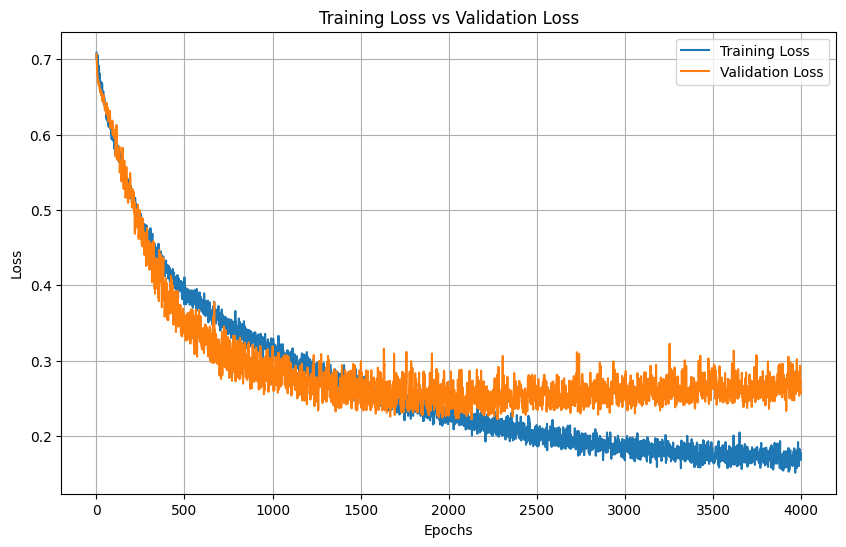

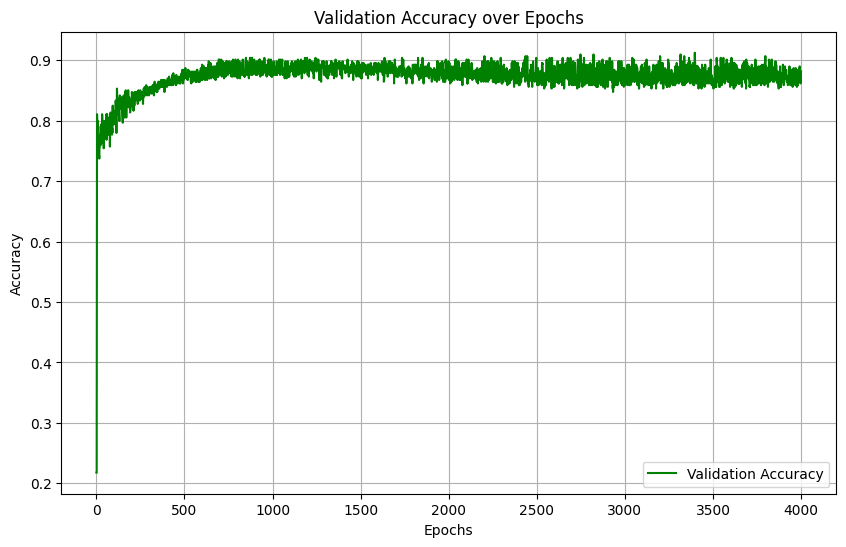

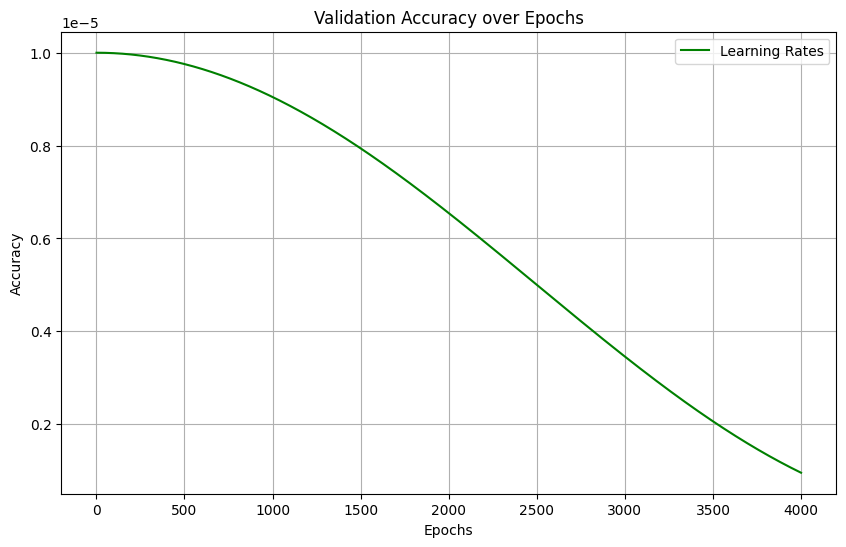

Model for bin 45 saved to GCNModels-5A_exp4/model_bin_45.pth
Training on bin 46/50
Bin 46, Epoch 1/4000, Train Loss: 0.7219, Validation Loss: 0.6645,  Accuracy: 0.7825, LR: 0.000010
Bin 46, Epoch 101/4000, Train Loss: 0.6522, Validation Loss: 0.6285,  Accuracy: 0.7853, LR: 0.000010
Bin 46, Epoch 201/4000, Train Loss: 0.6075, Validation Loss: 0.5823,  Accuracy: 0.8107, LR: 0.000010
Bin 46, Epoch 301/4000, Train Loss: 0.5461, Validation Loss: 0.5410,  Accuracy: 0.8249, LR: 0.000010
Bin 46, Epoch 401/4000, Train Loss: 0.5199, Validation Loss: 0.4678,  Accuracy: 0.8390, LR: 0.000010
Bin 46, Epoch 501/4000, Train Loss: 0.4743, Validation Loss: 0.4550,  Accuracy: 0.8418, LR: 0.000010
Bin 46, Epoch 601/4000, Train Loss: 0.4439, Validation Loss: 0.4116,  Accuracy: 0.8475, LR: 0.000010
Bin 46, Epoch 701/4000, Train Loss: 0.4172, Validation Loss: 0.3985,  Accuracy: 0.8559, LR: 0.000010
Bin 46, Epoch 801/4000, Train Loss: 0.4097, Validation Loss: 0.3438,  Accuracy: 0.8814, LR: 0.000009
Bin 46, Ep

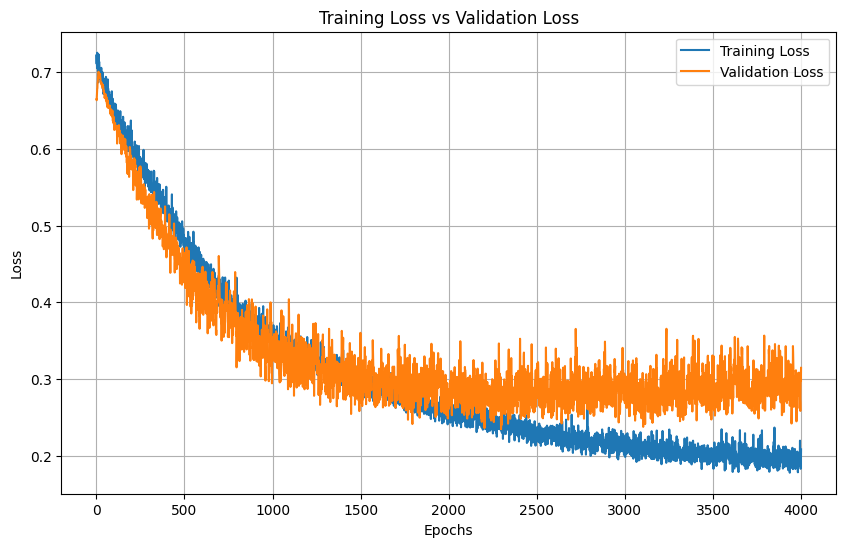

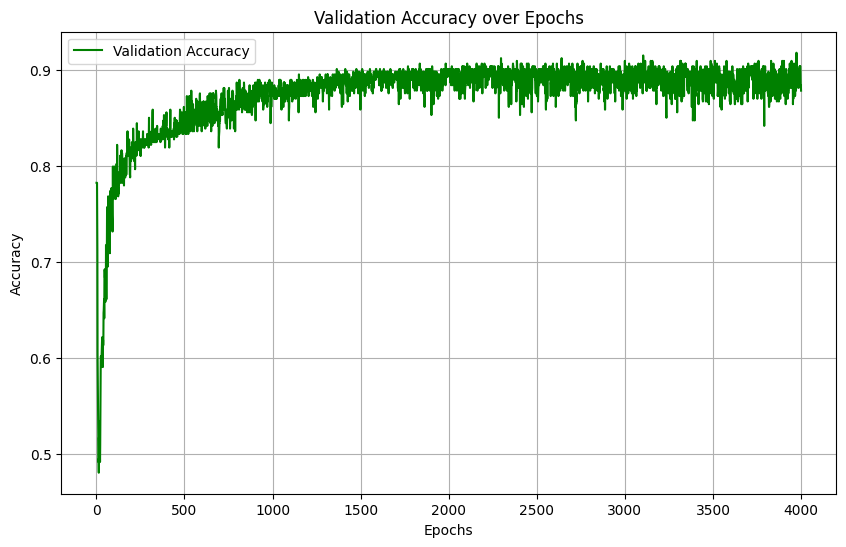

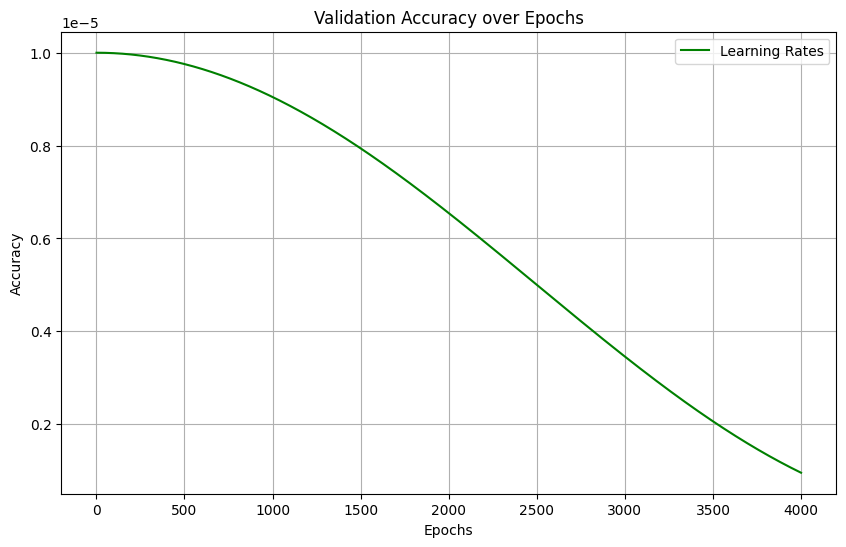

Model for bin 46 saved to GCNModels-5A_exp4/model_bin_46.pth
Training on bin 47/50
Bin 47, Epoch 1/4000, Train Loss: 0.6870, Validation Loss: 0.6741,  Accuracy: 0.7825, LR: 0.000010
Bin 47, Epoch 101/4000, Train Loss: 0.6032, Validation Loss: 0.5879,  Accuracy: 0.8531, LR: 0.000010
Bin 47, Epoch 201/4000, Train Loss: 0.5446, Validation Loss: 0.5342,  Accuracy: 0.8277, LR: 0.000010
Bin 47, Epoch 301/4000, Train Loss: 0.4832, Validation Loss: 0.4695,  Accuracy: 0.8446, LR: 0.000010
Bin 47, Epoch 401/4000, Train Loss: 0.4848, Validation Loss: 0.4203,  Accuracy: 0.8531, LR: 0.000010
Bin 47, Epoch 501/4000, Train Loss: 0.4330, Validation Loss: 0.3813,  Accuracy: 0.8644, LR: 0.000010
Bin 47, Epoch 601/4000, Train Loss: 0.3842, Validation Loss: 0.3667,  Accuracy: 0.8785, LR: 0.000010
Bin 47, Epoch 701/4000, Train Loss: 0.3868, Validation Loss: 0.3708,  Accuracy: 0.8616, LR: 0.000010
Bin 47, Epoch 801/4000, Train Loss: 0.3919, Validation Loss: 0.3178,  Accuracy: 0.8898, LR: 0.000009
Bin 47, Ep

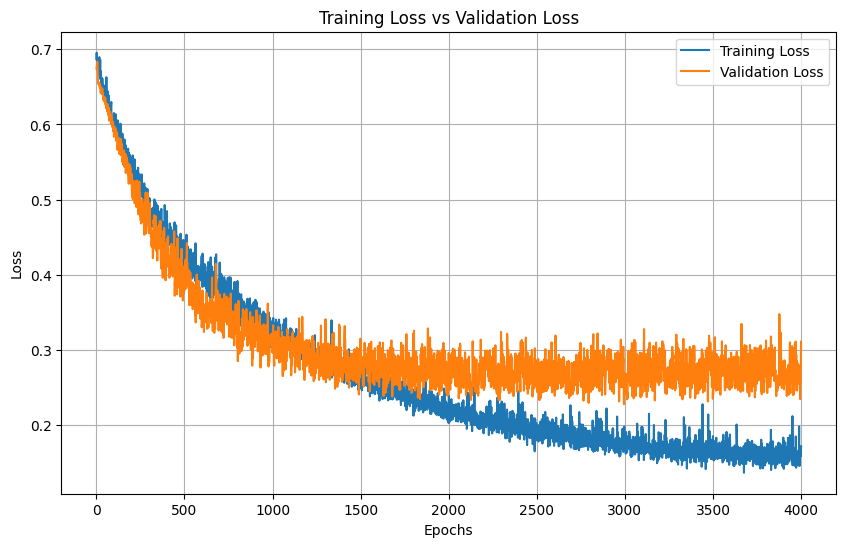

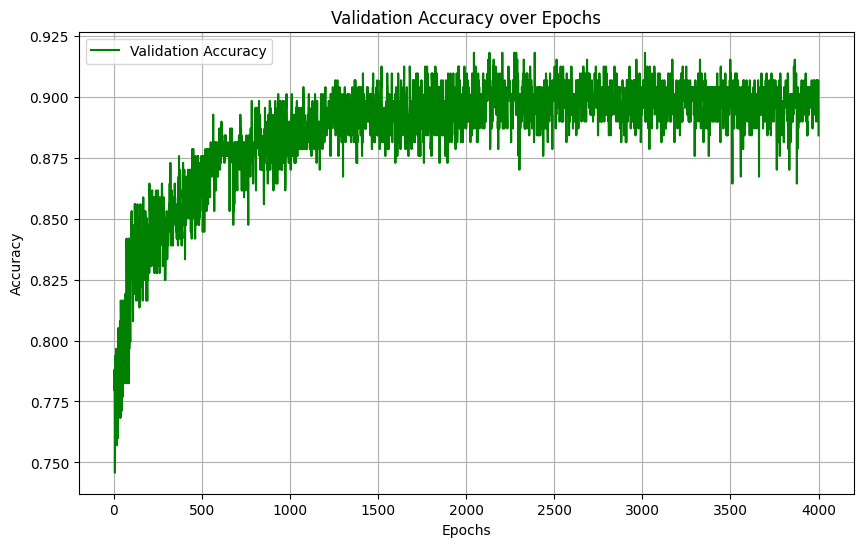

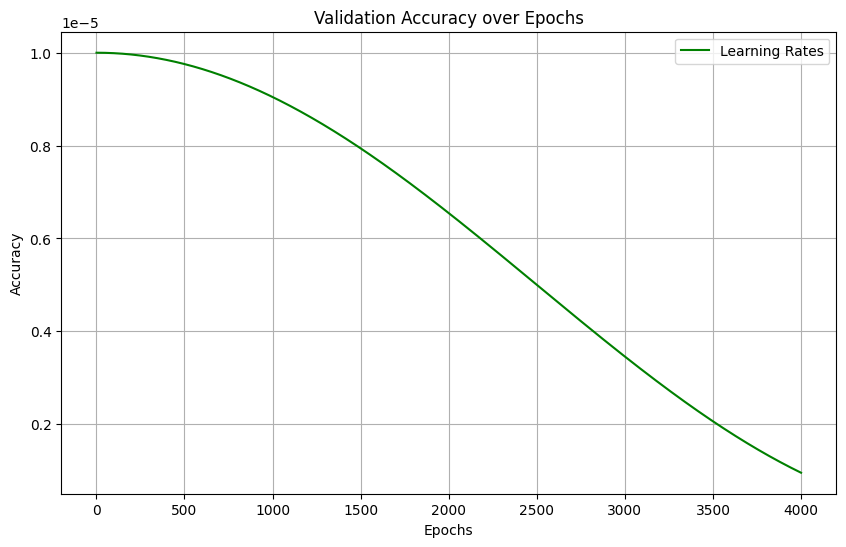

Model for bin 47 saved to GCNModels-5A_exp4/model_bin_47.pth
Training on bin 48/50
Bin 48, Epoch 1/4000, Train Loss: 0.6942, Validation Loss: 0.6930,  Accuracy: 0.6215, LR: 0.000010
Bin 48, Epoch 101/4000, Train Loss: 0.6281, Validation Loss: 0.6237,  Accuracy: 0.7740, LR: 0.000010
Bin 48, Epoch 201/4000, Train Loss: 0.5778, Validation Loss: 0.5635,  Accuracy: 0.8136, LR: 0.000010
Bin 48, Epoch 301/4000, Train Loss: 0.5418, Validation Loss: 0.5077,  Accuracy: 0.8305, LR: 0.000010
Bin 48, Epoch 401/4000, Train Loss: 0.4997, Validation Loss: 0.4450,  Accuracy: 0.8475, LR: 0.000010
Bin 48, Epoch 501/4000, Train Loss: 0.4721, Validation Loss: 0.4227,  Accuracy: 0.8418, LR: 0.000010
Bin 48, Epoch 601/4000, Train Loss: 0.4451, Validation Loss: 0.3921,  Accuracy: 0.8418, LR: 0.000010
Bin 48, Epoch 701/4000, Train Loss: 0.4274, Validation Loss: 0.3947,  Accuracy: 0.8390, LR: 0.000010
Bin 48, Epoch 801/4000, Train Loss: 0.4434, Validation Loss: 0.3955,  Accuracy: 0.8390, LR: 0.000009
Bin 48, Ep

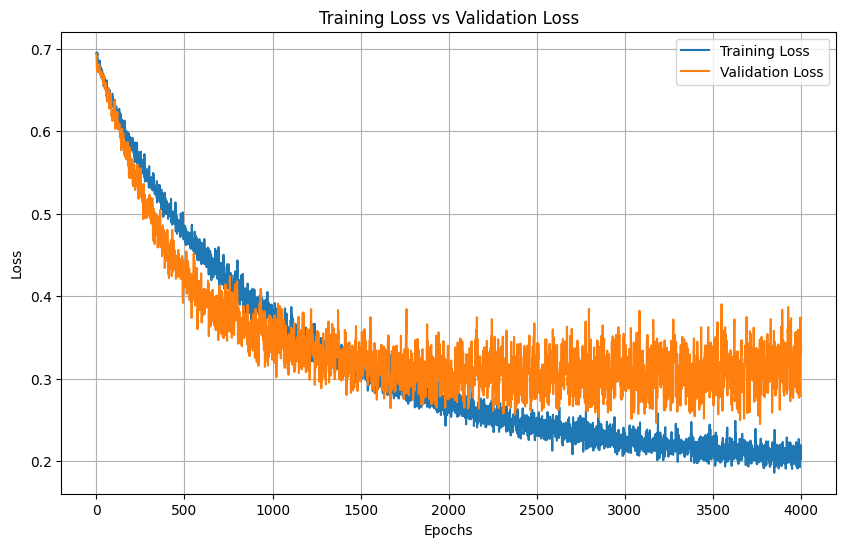

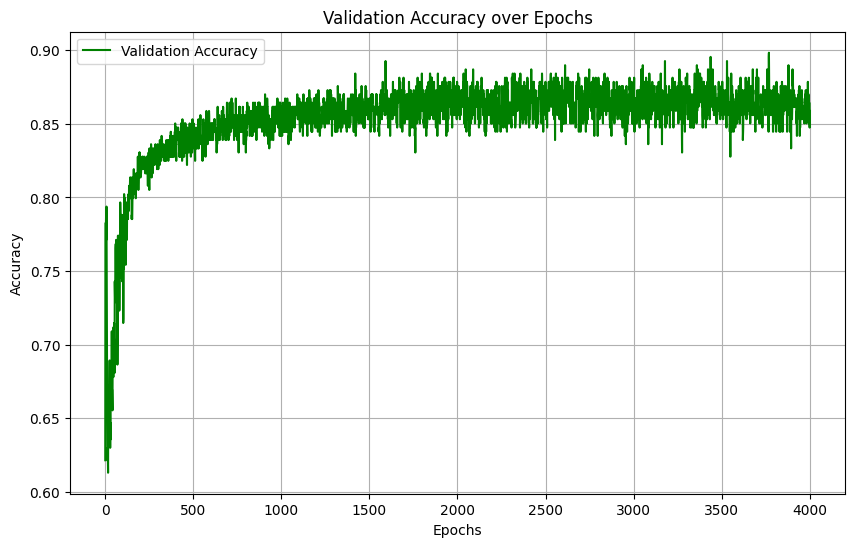

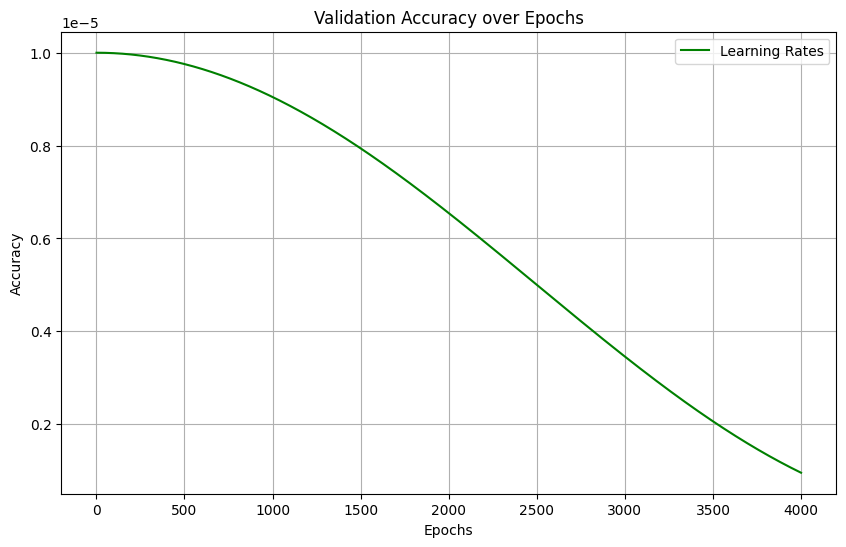

Model for bin 48 saved to GCNModels-5A_exp4/model_bin_48.pth
Training on bin 49/50
Bin 49, Epoch 1/4000, Train Loss: 0.6945, Validation Loss: 0.7481,  Accuracy: 0.2175, LR: 0.000010
Bin 49, Epoch 101/4000, Train Loss: 0.6295, Validation Loss: 0.6741,  Accuracy: 0.6271, LR: 0.000010
Bin 49, Epoch 201/4000, Train Loss: 0.5824, Validation Loss: 0.5890,  Accuracy: 0.8107, LR: 0.000010
Bin 49, Epoch 301/4000, Train Loss: 0.5195, Validation Loss: 0.4874,  Accuracy: 0.8644, LR: 0.000010
Bin 49, Epoch 401/4000, Train Loss: 0.4739, Validation Loss: 0.4343,  Accuracy: 0.8672, LR: 0.000010
Bin 49, Epoch 501/4000, Train Loss: 0.4427, Validation Loss: 0.3841,  Accuracy: 0.8757, LR: 0.000010
Bin 49, Epoch 601/4000, Train Loss: 0.4113, Validation Loss: 0.3593,  Accuracy: 0.8814, LR: 0.000010
Bin 49, Epoch 701/4000, Train Loss: 0.3967, Validation Loss: 0.3273,  Accuracy: 0.8814, LR: 0.000010
Bin 49, Epoch 801/4000, Train Loss: 0.3723, Validation Loss: 0.3199,  Accuracy: 0.8898, LR: 0.000009
Bin 49, Ep

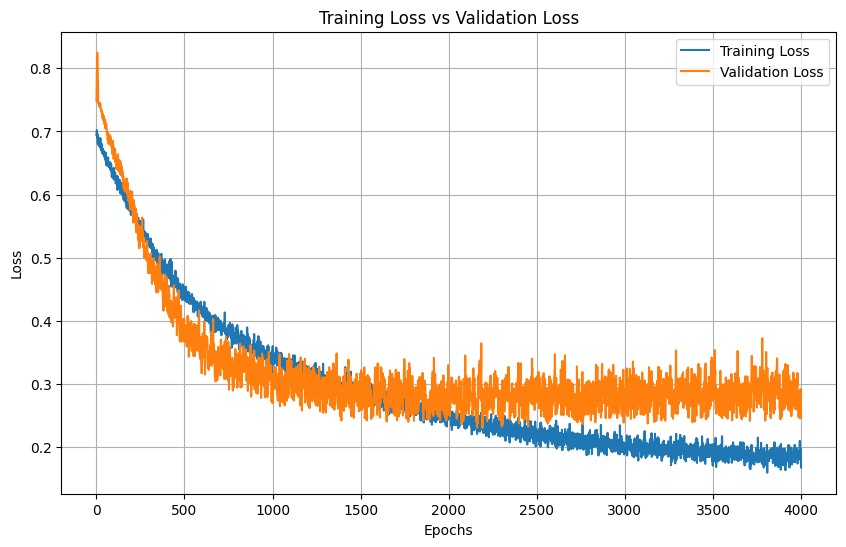

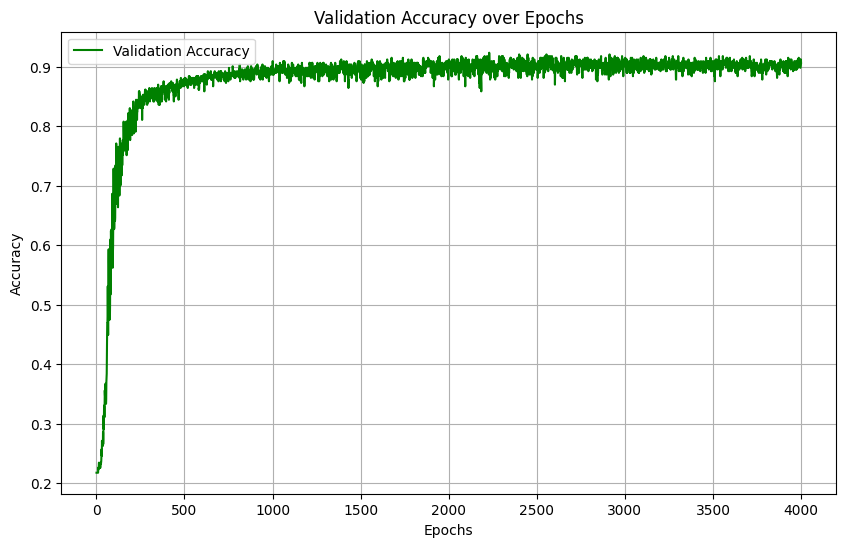

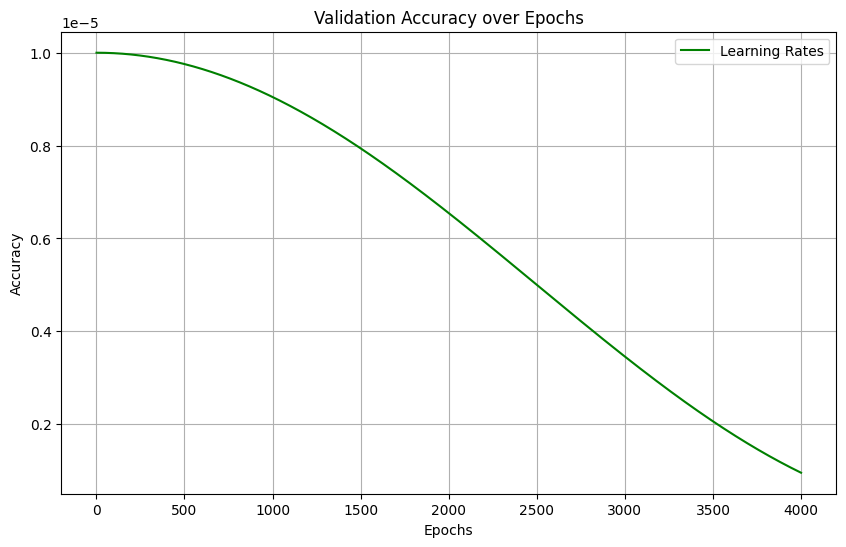

Model for bin 49 saved to GCNModels-5A_exp4/model_bin_49.pth
Training on bin 50/50
Bin 50, Epoch 1/4000, Train Loss: 0.6866, Validation Loss: 0.7160,  Accuracy: 0.2175, LR: 0.000010
Bin 50, Epoch 101/4000, Train Loss: 0.5994, Validation Loss: 0.6215,  Accuracy: 0.7373, LR: 0.000010
Bin 50, Epoch 201/4000, Train Loss: 0.5371, Validation Loss: 0.5335,  Accuracy: 0.8277, LR: 0.000010
Bin 50, Epoch 301/4000, Train Loss: 0.4645, Validation Loss: 0.4998,  Accuracy: 0.8164, LR: 0.000010
Bin 50, Epoch 401/4000, Train Loss: 0.4393, Validation Loss: 0.4520,  Accuracy: 0.8305, LR: 0.000010
Bin 50, Epoch 501/4000, Train Loss: 0.3981, Validation Loss: 0.4409,  Accuracy: 0.8249, LR: 0.000010
Bin 50, Epoch 601/4000, Train Loss: 0.3853, Validation Loss: 0.3812,  Accuracy: 0.8475, LR: 0.000010
Bin 50, Epoch 701/4000, Train Loss: 0.3507, Validation Loss: 0.3497,  Accuracy: 0.8644, LR: 0.000010
Bin 50, Epoch 801/4000, Train Loss: 0.3255, Validation Loss: 0.3335,  Accuracy: 0.8757, LR: 0.000009
Bin 50, Ep

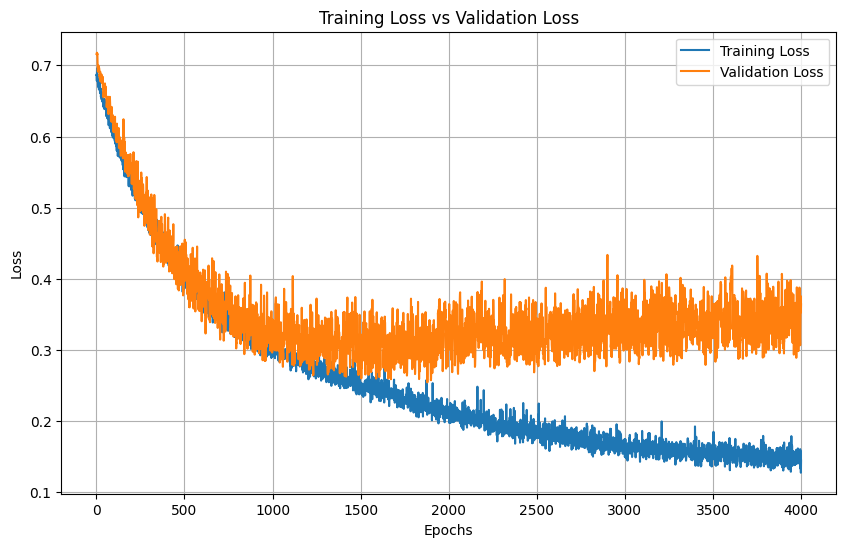

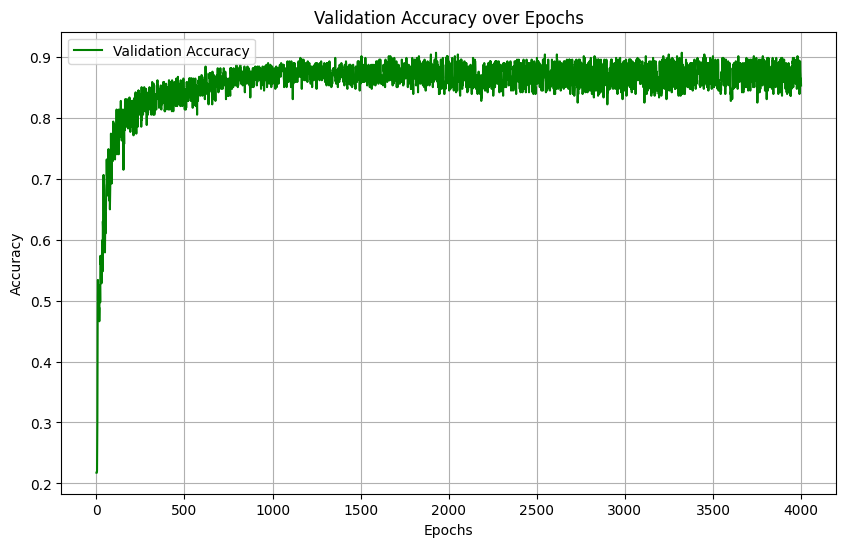

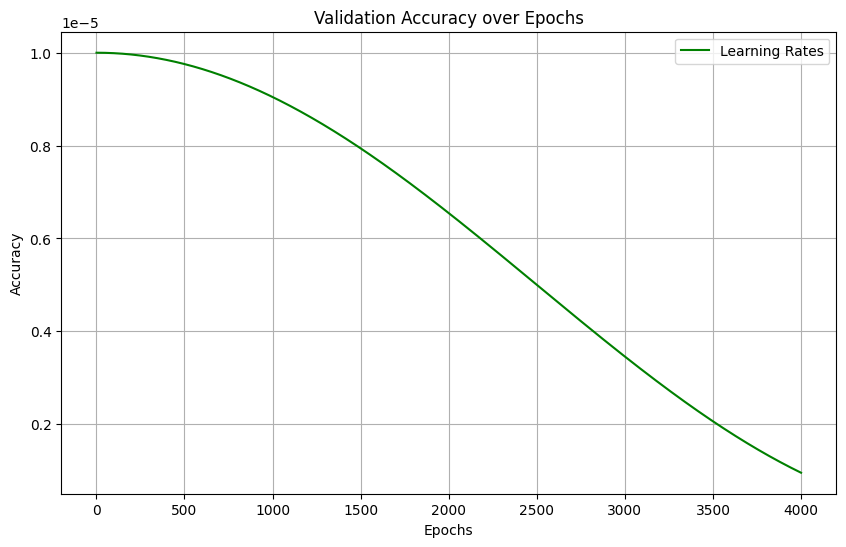

Model for bin 50 saved to GCNModels-5A_exp4/model_bin_50.pth
Training complete.


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GCNModels-5A_exp4"
os.makedirs(f"{save_dir}/Models", exist_ok=True)

# Training loop
epochs = 4000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = GCN(input_dim=37).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    train_loader = DataLoader(bins[i], batch_size=batch_size, shuffle=True)    

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

print("Training complete.")